# From Chat to Strategy: Topic Modeling for Support Operations

# Table of Contents:
- [Project Overview](#project-overview")
- [Business Problem and Research Question](#business-problem-and-research-question)
- [Dataset Description and Schema](#dataset-description-and-schema)
- [Data Import and Initial Checks](#data-import-and-initial-checks)
- [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)
- [Topic Modeling Feature Engineering](#topic-modeling-feature-engineering)
- [Baseline Model: Latent Dirichlet Allocation (LDA)](#baseline-model-latent-dirichlet-allocation-lda)
- [Topic Modeling with Embedding-Based Methods](#topic-modeling-with-embedding-based-methods)
- [Topic Modeling Interpretation](#topic-modeling-interpretation)
- [Cross-Cluster Patterns and Key Business Insights](#cross-cluster-patterns-and-key-business-insights)
- [Model Validation and Quality Assessment](#model-validation-and-quality-assessment)
- [Future Directions for Clustering Model](#future-directions-for-clustering-model)
- [Client-level View of Support Demand](#сlient-level-view-of-support-demand)
- [Conclusion and Recommendations](#conclusion-and-recommendations)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import pymorphy3
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN
from umap import UMAP
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis
import pyLDAvis.lda_model

## <a id="project-overview"></a>Project Overview

### Context and motivation
Customer support conversations contain valuable operational knowledge, but in raw form they are difficult to summarize, quantify, and monitor. This project applies topic modeling to transform unstructured chat transcripts into a structured view of recurring issues, emerging patterns, and operational risk areas.

### Business problem
The business needs a scalable way to answer questions such as:
- What are the most common types of support requests?
- Which issues are growing or declining over time?
- Which themes reflect product friction (self-service gaps) vs. infrastructure reliability risks?
- Is support demand concentrated in a small set of clients, and do different client segments show different demand profiles?
- How we can improve quality of support and service itself based on our findings?

### Data and unit of analysis
The primary dataset consists of chat transcripts grouped into **support sessions** (48-hour windows).  
Two analysis levels are used:
- **Session-level dataset** (NLP-ready sessions): used for topic modeling and trend analysis.
- **Client-level dataset**: used to describe how support demand is distributed across clients (segmentation, Pareto concentration) and how topic profiles differ by client segment.

### Analytical approach (high level)
1. **EDA & preprocessing:** cleaning transcripts, filtering non-informative sessions, basic language handling.
2. **Baseline topic model (LDA):** interpretable benchmark to validate that meaningful structure exists.
3. **Embedding-based topic modeling (BERTopic):** richer semantic clustering and a 3-level hierarchy  
   *(original topics → merged topics → meta-topics)* to balance nuance and interpretability.
4. **Interpretation & validation:** manual inspection and stakeholder feedback to confirm semantic coherence.
5. **Client-level view (extension):** segmentation of clients by activity and analysis of topic concentration.

### Outputs
The notebook produces:
- A hierarchical topic taxonomy (topic → merged topic → meta-topic)
- Topic trends over time and cross-cluster patterns
- Interpreted business insights and operational hypotheses (with limitations clearly stated)
- A client-level view of support demand concentration and segment-specific dominant topics

### How to read this notebook
This notebook is designed as a technical artifact for internal understanding and reproducibility:
- The **Topic Modeling** and **Interpretation/Insights** sections contain the core results.
- The **Client-level view** section is an optional extension that links topic insights to customer profiles.
- A separate stakeholder-facing summary (presentation/document) can be derived from the final insights and recommendations.

## <a id="business-problem-and-research-question"></a>Business Problem and Research Question


**Business Problem**

VPS hosting technical support team handles a growing volume of repetitive and semantically similar customer tickets. These tickets slow down response times, obscure emerging issues, and create inefficiencies in the workflow. Without a structured understanding of ticket themes, the company cannot systematically improve its FAQ, UI flows, and onboarding guidance.
The business needs a data-driven approach to extract meaningful patterns from raw support logs and identify the most frequent, high-impact problem categories.

**Research Question**

How can unsupervised learning methods (clustering + topic extraction) reveal dominant themes in customer support messages, and how can these insights improve operational efficiency and user experience?

**Hypothesis**

If we cluster support messages based on semantic similarity, we expect to discover a stable set of recurring problem types (e.g., billing, server setup, network issues). These clusters can serve as a foundation for:

- updating and reorganizing the FAQ and help center,

- improving interface flows that currently trigger confusion,

- informing automated ticket routing or classification,

- reducing support load by addressing the most frequent issues proactively.

## <a id="dataset-description-and-schema"></a>Dataset Description and Schema

### Data Source  

The data originates from Hexcore’s online technical support chat system. Each user message is logged together with metadata such as timestamps, approximate session boundaries, and response times. For analytical clarity, the raw continuous message history per client was transformed into two structured datasets with different levels of granularity.

All personally identifiable information (PII), including client email addresses and names, was removed and replaced with anonymized surrogate IDs (`anon_id`). Text content was preserved, but inline identifiers inside messages were cleaned during preprocessing.

---

### Dataset Overview  

We work with two datasets with different levels of granularity:

- `client_df` – client-level aggregated data  
- `session_df` – session-level data used for clustering and topic discovery  

---

### `client_df` — Client-Level Aggregated Data  

Each row corresponds to a unique anonymized client.  
This dataset provides long-term behavioral and temporal patterns.

| Column                | Description                                                         | Type      |
|-----------------------|---------------------------------------------------------------------|-----------|
| `anon_id`             | Anonymized client identifier (replaces email)                      | int       |
| `n_sessions`          | Number of distinct support sessions extracted for this client      | int       |
| `first_contact`       | Timestamp of the earliest recorded message                         | datetime  |
| `last_contact`        | Timestamp of the latest recorded message                           | datetime  |
| `mean_session_duration` | Average duration of the client’s sessions (minutes)              | float     |
| `mean_ttr`            | Average time-to-response from support across all sessions (minutes)| float     |
| `history_span`        | Total timespan between first and last contact                      | timedelta |
| `history_days`        | Same as `history_span`, expressed in whole days                    | int       |

This dataset helps identify long-term patterns such as recurring users, high-volume clients, and engagement timelines.

---

###  `session_df` — Session-Level Data  

Each row represents one support session. Sessions were defined by grouping consecutive messages that occur within a 48-hour gap. This rule helps segment long, continuous user histories into actionable conversation units.

| Column            | Description                                                     | Type      |
|-------------------|-----------------------------------------------------------------|-----------|
| `session_index`   | Session number for the given client                             | int       |
| `session_start`   | Timestamp of first message in the session                       | datetime  |
| `session_end`     | Timestamp of last message in the session                        | datetime  |
| `session_duration`| Session duration as a `timedelta`                               | timedelta |
| `duration_minutes`| Session duration in minutes                                     | float     |
| `clean_transcript`| Cleaned message text for the full session                       | str       |
| `ttr`             | Time-to-response in the session as `timedelta`                  | timedelta |
| `ttr_minutes`     | Time-to-response in minutes                                     | float     |
| `anon_id`         | Anonymized client ID, foreign key linking to `client_df`        | int       |

This dataset is used for clustering and topic discovery, since each session contains the full user conversation required for semantic analysis.

---

###  Rationale for Two Datasets  

- The **client-level dataset** captures long-term interaction patterns and overall support footprint per user.  
- The **session-level dataset** provides semantically coherent text units appropriate for clustering and topic modeling.

This separation follows common practices in chat log analysis:  
user-level data reveals engagement patterns; session-level data reveals intent.

---

###  Granularity & Preprocessing Notes  

- Session boundaries were defined using a **48-hour inactivity gap rule**, a common heuristic in customer-support log segmentation.  
- Raw messages included system text, signatures, URLs, and PII; these were removed or transformed during preprocessing.  
- Only anonymized, cleaned transcripts (`clean_transcript`) are used as input for the modeling pipeline.

## <a id="data-import-and-initial-checks"></a>Data Import and Initial Checks


In [3]:
session_df = pd.read_csv("/PATH/session_df_anon.csv", parse_dates=["session_start", "session_end"]) # session level - one row = one chat (48h)
client_df = pd.read_csv("/PATH/сlient_df_anon.csv", parse_dates=["first_contact", "last_contact"]) # client level - one row - one client

In [4]:
session_df.head()

,session_index,session_start,session_end,session_duration,duration_minutes,clean_transcript,ttr,ttr_minutes,anon_id
0,0,2016-04-30 23:25:37,2016-05-01 06:17:29,0 days 06:51:52,411.866667,"здравствуйте у меня вопросы по тесту,хочу посм...",0 days 06:50:16,410.266667,1
1,1,2016-05-01 12:18:51,2016-05-01 12:18:51,0 days 00:00:00,0.000000,<Сергей>,NaN,NaN,1
2,0,2018-12-10 07:28:40,2018-12-10 07:44:36,0 days 00:15:56,15.933333,: Title: Hexcore. Надежные виртуальные серверы...,0 days 00:05:30,5.500000,2
3,1,2018-12-11 19:01:49,2018-12-11 19:01:49,0 days 00:00:00,0.000000,<Сергей>,NaN,NaN,2
4,0,2023-07-11 19:16:05,2023-07-11 19:21:39,0 days 00:05:34,5.566667,: Title: Панель управления URL: https://hexcor...,0 days 00:02:23,2.383333,3


In [3]:
session_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22027 entries, 0 to 22026
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   session_index     22027 non-null  int64         
 1   session_start     22027 non-null  datetime64[ns]
 2   session_end       22027 non-null  datetime64[ns]
 3   session_duration  22027 non-null  object        
 4   duration_minutes  22027 non-null  float64       
 5   clean_transcript  22027 non-null  object        
 6   ttr               9849 non-null   object        
 7   ttr_minutes       9849 non-null   float64       
 8   anon_id           22027 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(3)
memory usage: 1.5+ MB


In [4]:
client_df.head()

,anon_id,n_sessions,first_contact,last_contact,mean_session_duration,mean_ttr,history_span,history_days
0,1,2,2016-04-30 23:25:37,2016-05-01 12:18:51,205.933333,410.266667,0 days 12:53:14,0
1,2,2,2018-12-10 07:28:40,2018-12-11 19:01:49,7.966667,5.500000,1 days 11:33:09,1
2,3,2,2023-07-11 19:16:05,2023-07-29 06:53:55,2.783333,2.383333,17 days 11:37:50,17
3,4,2,2017-10-01 14:45:58,2017-10-01 20:46:59,96.891667,192.566667,0 days 06:01:01,0
4,5,4,2025-03-03 18:23:14,2025-09-22 15:29:43,48.450000,1.650000,202 days 21:06:29,202


In [5]:
client_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5122 entries, 0 to 5121
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   anon_id                5122 non-null   int64         
 1   n_sessions             5122 non-null   int64         
 2   first_contact          5122 non-null   datetime64[ns]
 3   last_contact           5122 non-null   datetime64[ns]
 4   mean_session_duration  5122 non-null   float64       
 5   mean_ttr               4704 non-null   float64       
 6   history_span           5122 non-null   object        
 7   history_days           5122 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(3), object(1)
memory usage: 320.3+ KB


## <a id="exploratory-data-analysis-eda"></a>Exploratory Data Analysis (EDA)

### EDA Overview

In [6]:
session_df.shape # how many session

(22027, 9)

In [7]:
client_df.shape # how many clients (visitors)

(5122, 8)

In [439]:
client_df['anon_id'].value_counts()

anon_id
1       1
3842    1
3420    1
3419    1
3418    1
       ..
1707    1
1706    1
1705    1
1704    1
5122    1
Name: count, Length: 5122, dtype: int64

In [8]:
# Average number of sessions per client

avg_sessions_per_client = client_df["n_sessions"].mean()
print(f"Average number of sessions per client: {avg_sessions_per_client:.2f}")

Average number of sessions per client: 4.30


In [9]:
# Percentage of gaps in key columns client_df

key_client_cols = [
    "anon_id",
    "n_sessions",
    "first_contact",
    "last_contact",
    "mean_session_duration",
    "mean_ttr",
    "history_span",
    "history_days",
]

client_missing = (
    client_df[key_client_cols]
    .isna()
    .mean()
    .sort_values(ascending=False)
    .to_frame(name="missing_fraction")
)

client_missing["missing_percent"] = client_missing["missing_fraction"] * 100

client_missing

,missing_fraction,missing_percent
mean_ttr,0.081609,8.160875
anon_id,0.000000,0.000000
n_sessions,0.000000,0.000000
first_contact,0.000000,0.000000
last_contact,0.000000,0.000000
mean_session_duration,0.000000,0.000000
history_span,0.000000,0.000000
history_days,0.000000,0.000000


In [10]:
session_df.head()

,session_index,session_start,session_end,session_duration,duration_minutes,clean_transcript,ttr,ttr_minutes,anon_id
0,0,2016-04-30 23:25:37,2016-05-01 06:17:29,0 days 06:51:52,411.866667,"здравствуйте у меня вопросы по тесту,хочу посм...",0 days 06:50:16,410.266667,1
1,1,2016-05-01 12:18:51,2016-05-01 12:18:51,0 days 00:00:00,0.000000,<Сергей>,NaN,NaN,1
2,0,2018-12-10 07:28:40,2018-12-10 07:44:36,0 days 00:15:56,15.933333,: Title: Hexcore. Надежные виртуальные серверы...,0 days 00:05:30,5.500000,2
3,1,2018-12-11 19:01:49,2018-12-11 19:01:49,0 days 00:00:00,0.000000,<Сергей>,NaN,NaN,2
4,0,2023-07-11 19:16:05,2023-07-11 19:21:39,0 days 00:05:34,5.566667,: Title: Панель управления URL: https://hexcor...,0 days 00:02:23,2.383333,3


In [11]:
# Percentage of gaps in key columns session_df

key_session_cols = [
    "session_index",
    "session_start",
    "session_end",
    "session_duration",
    "duration_minutes",
    "clean_transcript",
    "ttr",
    "ttr_minutes",
    "anon_id",
]

session_missing = (
    session_df[key_session_cols]
    .isna()
    .mean()
    .sort_values(ascending=False)
    .to_frame(name="missing_fraction")
)

session_missing["missing_percent"] = session_missing["missing_fraction"] * 100

session_missing

,missing_fraction,missing_percent
ttr,0.552867,55.286694
ttr_minutes,0.552867,55.286694
session_index,0.000000,0.000000
session_start,0.000000,0.000000
session_end,0.000000,0.000000
session_duration,0.000000,0.000000
duration_minutes,0.000000,0.000000
clean_transcript,0.000000,0.000000
anon_id,0.000000,0.000000


### Missing Values Overview

All structural and temporal fields (`anon_id`, session timestamps, session duration, transcript text) are fully populated, which confirms that the extraction process from the raw chat logs was reliable and loss-free.

The only columns containing missing values are `ttr` and `ttr_minutes` in `session_df`, with approximately **55% null entries**. This is expected and reflects real-world behavior rather than data quality issues:

- Not all user messages receive an immediate or measurable time-to-response (TTR).  
- Some sessions consist only of user messages (e.g., the user drops the question and leaves the chat).  
- In other cases, support may have responded outside the detectable window, or system events did not generate a response timestamp.

In customer-support datasets, missing TTR values are a normal feature of the data rather than an error.  

### `client_df` EDA

In [12]:
client_df.describe(include='all')

,anon_id,n_sessions,first_contact,last_contact,mean_session_duration,mean_ttr,history_span,history_days
count,5122.00000,5122.000000,5122,5122,5122.000000,4704.000000,5122,5122.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,5018,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:55:38,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN
mean,2561.50000,4.300469,2019-10-28 08:47:11.529090304,2020-02-15 18:45:26.768840448,203.653502,73.802611,NaN,110.016986
min,1.00000,1.000000,2016-02-17 19:46:59,2016-02-20 13:32:41,0.000000,0.000000,NaN,0.000000
25%,1281.25000,2.000000,2017-10-26 08:09:50.500000,2017-12-05 18:23:03.500000,5.895833,0.633333,NaN,0.000000
50%,2561.50000,2.000000,2018-12-04 01:17:48.500000,2019-01-12 19:17:57,30.279167,2.150000,NaN,2.000000
75%,3841.75000,3.000000,2022-02-11 00:31:17,2022-05-15 16:27:50.750000128,254.460417,16.831250,NaN,32.000000
max,5122.00000,345.000000,2025-10-21 19:28:28,2025-10-22 12:48:18,7734.116667,7129.066667,NaN,2264.000000


95th percentile of n_sessions: 12.0


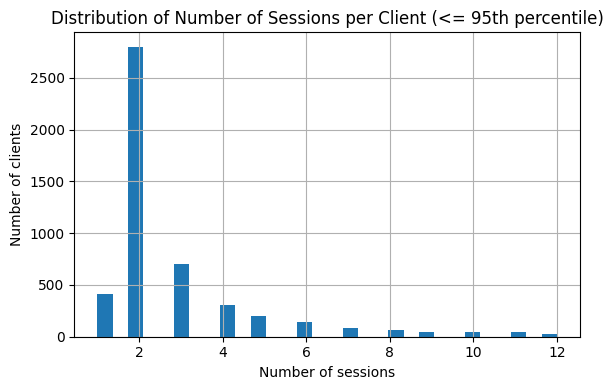

In [13]:
# Compute 95th percentile for n_sessions
p95 = client_df["n_sessions"].quantile(0.95)
print(f"95th percentile of n_sessions: {p95}")

# Filter values up to this threshold
subset = client_df[client_df["n_sessions"] <= p95]["n_sessions"]

plt.figure(figsize=(6, 4))
subset.hist(bins=30)
plt.title("Distribution of Number of Sessions per Client (<= 95th percentile)")
plt.xlabel("Number of sessions")
plt.ylabel("Number of clients")
plt.tight_layout()
plt.show()

95th percentile of history_days: 780.5999999999985


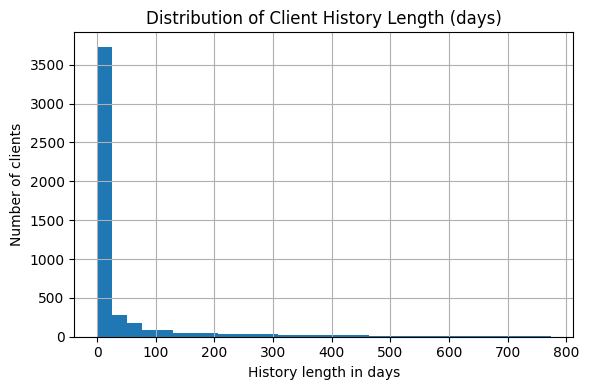

In [14]:
# Compute 95th percentile for n_sessions
p95 = client_df["history_days"].quantile(0.95)
print(f"95th percentile of history_days: {p95}")

# Filter values up to this threshold
subset = client_df[client_df["history_days"] <= p95]["history_days"]

plt.figure(figsize=(6, 4))
subset.hist(bins=30)
plt.title("Distribution of Client History Length (days)")
plt.xlabel("History length in days")
plt.ylabel("Number of clients")
plt.tight_layout()
plt.show()

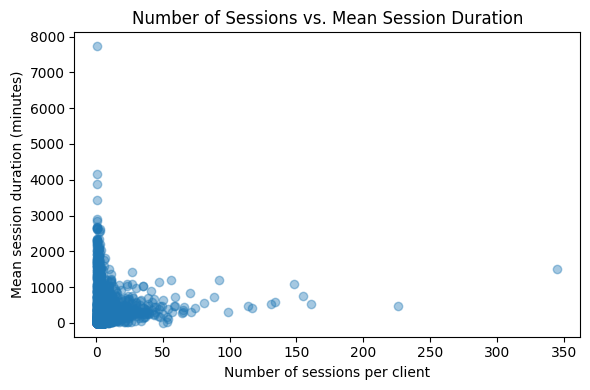

In [15]:
plt.figure(figsize=(6, 4))
plt.scatter(
    client_df["n_sessions"],
    client_df["mean_session_duration"],
    alpha=0.4
)
plt.title("Number of Sessions vs. Mean Session Duration")
plt.xlabel("Number of sessions per client")
plt.ylabel("Mean session duration (minutes)")
plt.tight_layout()
plt.show()

### Client-Level EDA Insigths:

To better understand client behaviour, we examined the distribution of the number of sessions per client and the overall history length in days.

For `n_sessions`, we plot values up to the 95th percentile to avoid the influence of a long tail:

- The majority of visitors/clients have **only 1–3 sessions**, indicating mostly one-off or occasional support interactions.  
- A smaller group returns more frequently, with up to ~10–12 sessions within the main mass of the distribution.  
- Beyond the 95th percentile, there is a long tail of heavy users with many more sessions; these are rare but potentially high-impact accounts.

For `history_days`, we again plot values up to the 95th percentile (~781 days):

- Most visitors/clients have a **short interaction history** (from a single day to a few weeks).  
- A minority of clients maintain a support relationship spanning **several months or even years**, which is consistent with long-term or high-value customers.

The scatter plot of `n_sessions` vs. `mean_session_duration` shows a dense cluster of clients with **few sessions and relatively short average duration**, and a sparse set of outliers with many sessions and/or unusually long session durations.  

These patterns suggest a natural distinction between:
- typical, low-touch visitors/clients, and  
- a small subset of high-touch clients with long histories and repeated support needs.  

This distinction is relevant for interpreting downstream clusters: some topics may be driven disproportionately by heavy users or long-term customers.

### `session_df` EDA

In [16]:
session_df.describe(include='all')

,session_index,session_start,session_end,session_duration,duration_minutes,clean_transcript,ttr,ttr_minutes,anon_id
count,22027.000000,22027,22027,22027,22027.000000,22027,9849,9849.000000,22027.000000
unique,NaN,NaN,NaN,8500,NaN,13722,2822,NaN,NaN
top,NaN,NaN,NaN,0 days 00:00:00,NaN,<Сергей>,0 days 00:00:14,NaN,NaN
freq,NaN,NaN,NaN,10010,NaN,7429,111,NaN,NaN
mean,13.110546,2020-06-11 08:39:06.653970176,2020-06-11 13:53:29.591274240,NaN,314.382288,NaN,NaN,80.390437,2499.106960
min,0.000000,2016-02-17 19:46:59,2016-02-17 19:48:59,NaN,0.000000,NaN,NaN,0.000000,1.000000
25%,1.000000,2017-11-22 21:00:41,2017-11-22 21:04:12,NaN,0.000000,NaN,NaN,0.583333,1199.500000
50%,2.000000,2019-11-08 21:36:21,2019-11-08 21:36:21,NaN,2.450000,NaN,NaN,1.700000,2504.000000
75%,10.000000,2022-11-05 12:27:31.500000,2022-11-05 14:57:23,NaN,105.483333,NaN,NaN,11.233333,3726.000000
max,344.000000,2025-10-22 12:25:52,2025-10-22 12:48:18,NaN,18856.266667,NaN,NaN,7129.066667,5122.000000


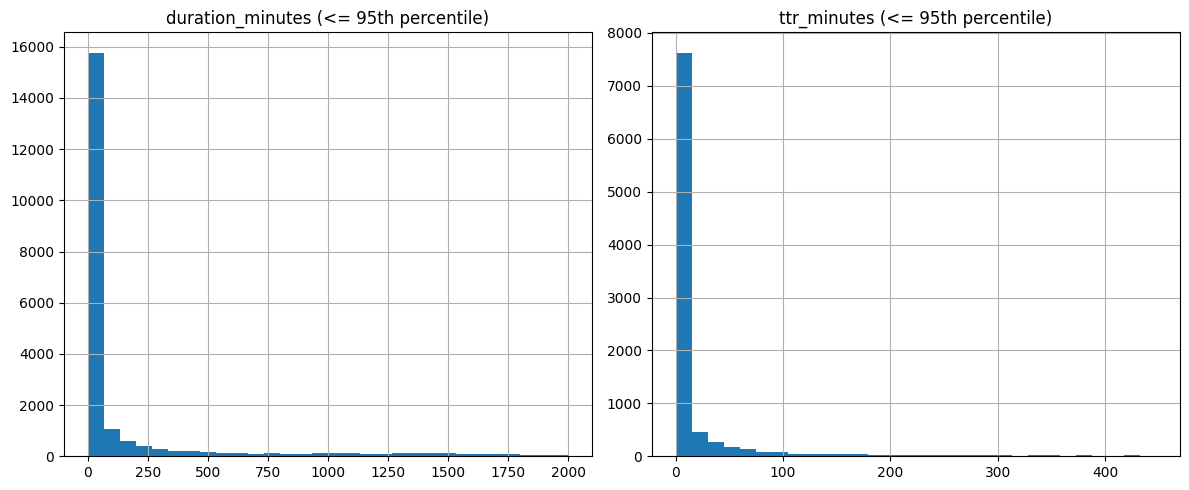

In [17]:
d95 = session_df["duration_minutes"].quantile(0.95)
t95 = session_df["ttr_minutes"].quantile(0.95)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

session_df[session_df["duration_minutes"] <= d95]["duration_minutes"] \
    .hist(bins=30, ax=axes[0])
axes[0].set_title("duration_minutes (<= 95th percentile)")

session_df[session_df["ttr_minutes"] <= t95]["ttr_minutes"] \
    .dropna() \
    .hist(bins=30, ax=axes[1])
axes[1].set_title("ttr_minutes (<= 95th percentile)")

plt.tight_layout()
plt.show()

In [18]:
avg_duration = (session_df["duration_minutes"] == 0).mean()
print(f"Average number session duration: {avg_duration * 100:.2f}%")

Average number session duration: 45.44%


In [19]:
avg_ttr = session_df["ttr_minutes"].isna().mean()
print(f"Average time to respont (minutes): {avg_ttr * 100:.2f}%")

Average time to respont (minutes): 55.29%


### Insigths:

The histogram of `duration_minutes` shows that:

- The vast majority of sessions are **very short** in terms of measured duration, with a large spike close to zero minutes.
- Around **45% of all sessions have recorded duration equal to 0 minutes**. This reflects how the logs are structured: many sessions consist of a single short interaction or have identical start and end timestamps.
- A small number of sessions extend to much longer durations, forming a long tail of extended conversations.

The histogram of `ttr_minutes` (time to first response) exhibits a similar pattern:

- Most measured responses are **very fast**, concentrated near zero minutes.
- There is a long tail of slower responses extending to tens or hundreds of minutes.
- As noted earlier, about **55% of sessions have missing TTR values** because no clear response timestamp is available (e.g., the user left before the agent replied, or the response occurred outside the captured window).

Overall, these distributions are typical for real-world support chat data: many quick, single-touch sessions and a smaller number of longer, more involved conversations.  
Since `duration_minutes` and `ttr_minutes` are primarily used for descriptive analysis and not as core features in the clustering model, we keep their raw distributions without further transformation, while later filtering on text length for the NLP pipeline.

In [20]:
session_df["year"] = session_df["session_start"].dt.year
session_df["month"] = session_df["session_start"].dt.to_period("M")

In [21]:
session_df["is_empty"] = session_df["duration_minutes"] == 0
session_df["has_reply"] = session_df["ttr_minutes"].notna()

empty_share = session_df["is_empty"].mean()
no_reply_share = (~session_df["has_reply"]).mean()

empty_share, no_reply_share

(np.float64(0.45444227538929494), np.float64(0.5528669360330504))

In [22]:
pd.crosstab(session_df["is_empty"], session_df["has_reply"])

has_reply,False,True
is_empty,,
False,2170,9847
True,10008,2


- Empty sessions will be excluded before text analysis (NLP).
- Sessions without an operator response are an independent business indicator of support quality.
- To accurately analyze TTR and duration, they must be separated.

In [23]:
# aggregation by year

yearly = (
    session_df
    .groupby("year")
    .agg(
        n_sessions=("session_index", "count"),
        mean_duration=("duration_minutes", "mean"),
        mean_ttr=("ttr_minutes", "mean")
    )
    .reset_index()
)
yearly

,year,n_sessions,mean_duration,mean_ttr
0,2016,2999,256.591669,37.795956
1,2017,2834,256.250759,73.708935
2,2018,3319,272.498905,90.268911
3,2019,2181,253.471894,83.412240
4,2020,1437,404.635015,65.757802
5,2021,1404,446.240373,54.889114
6,2022,2607,393.362594,96.056400
7,2023,1326,382.545890,120.630774
8,2024,1839,345.072313,111.259214
9,2025,2081,286.687850,113.152639


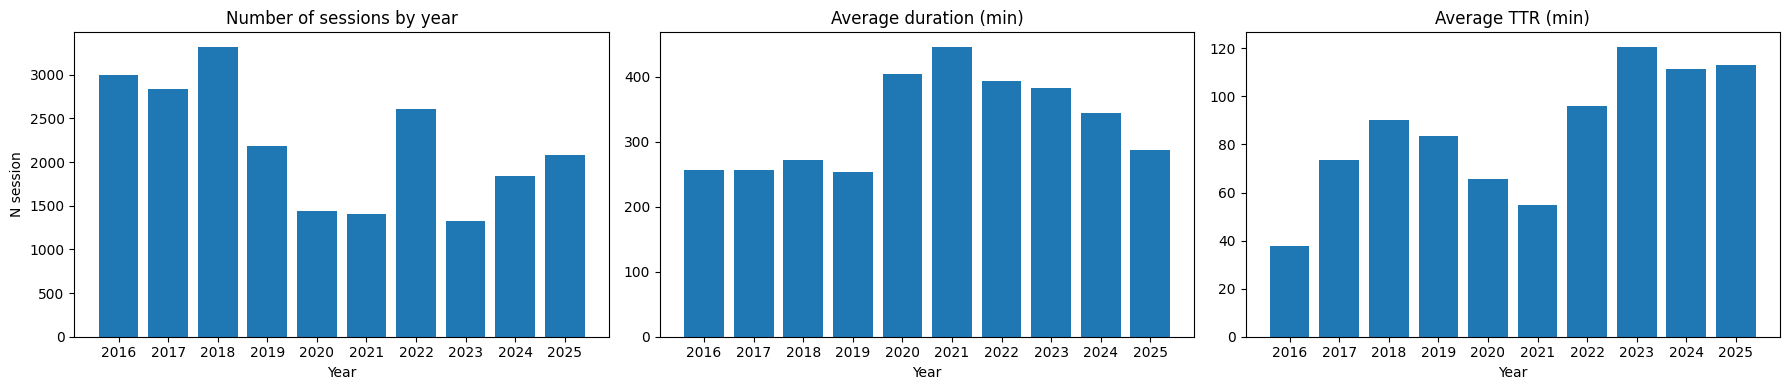

In [24]:
# Graphs by year: quantity and averages

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# quantity of sessions
axes[0].bar(yearly["year"], yearly["n_sessions"])
axes[0].set_title("Number of sessions by year")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("N session")
axes[0].set_xticks(yearly["year"])

# average duration
axes[1].bar(yearly["year"], yearly["mean_duration"])
axes[1].set_title("Average duration (min)")
axes[1].set_xlabel("Year")
axes[1].set_xticks(yearly["year"])

# average TTR
axes[2].bar(yearly["year"], yearly["mean_ttr"])
axes[2].set_title("Average TTR (min)")
axes[2].set_xlabel("Year")
axes[2].set_xticks(yearly["year"])

plt.tight_layout()
plt.show()

### Annual Dynamics of Requests

The graphs above show several trends:

1. **Number of sessions by year.**
The peak in requests occurred in 2018 (~3.3k sessions).

There was a decline in 2019, and in 2020–2021 the number of dialogues dropped significantly (~1.3–1.4k),
followed by a partial recovery in 2022 (~2.6k), while 2023–2025 remained at a moderate level.

2. **Average session duration.**
From 2016–2019, the average dialogue duration remained in the range of ~250–270 minutes.
Starting in 2020, sessions have been getting longer: in 2020–2022, the average
rises to ~400–450 minutes, then gradually declines to ~280–300 minutes in 2025.

This may indicate that, despite fewer requests, each conversation has become deeper/longer.

3. **Average TTR (Time to First Response).**

In 2016, TTR is low (~40 minutes),
then in 2017–2019, it increases to ~75–90 minutes.

In 2020–2021, response time temporarily decreases (55–65 minutes), |
but starting in 2022, it increases again and stabilizes at ~110–115 minutes by 2023–2025.
It's important to remember that the average TTR is calculated only for sessions where the operator responded at all (NaNs are excluded), and about half of all sessions last 0 minutes.

In [25]:
# number of unique clients per year - how many different anon_ids wrote to us each year

yearly_unique_clients = (
    session_df
    .groupby("year")["anon_id"]
    .nunique()
    .reset_index(name="n_unique_clients")
)

yearly_unique_clients

,year,n_unique_clients
0,2016,714
1,2017,767
2,2018,1268
3,2019,728
4,2020,346
5,2021,317
6,2022,629
7,2023,378
8,2024,515
9,2025,616


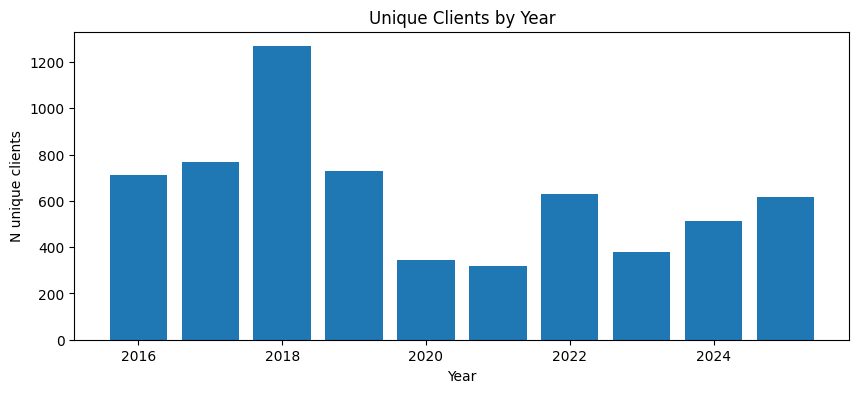

In [26]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(yearly_unique_clients["year"], yearly_unique_clients["n_unique_clients"])
ax.set_title("Unique Clients by Year")
ax.set_xlabel("Year")
ax.set_ylabel("N unique clients")
plt.show()

In [27]:
# depth of communication: how many sessions on average per client per year

yearly_sessions = (
    session_df
    .groupby("year")["session_index"]
    .count()
    .reset_index(name="n_sessions")
)

yearly_clients_stats = yearly_unique_clients.merge(yearly_sessions, on="year")
yearly_clients_stats["sessions_per_client"] = (
    yearly_clients_stats["n_sessions"] / yearly_clients_stats["n_unique_clients"]
)

yearly_clients_stats

,year,n_unique_clients,n_sessions,sessions_per_client
0,2016,714,2999,4.200280
1,2017,767,2834,3.694915
2,2018,1268,3319,2.617508
3,2019,728,2181,2.995879
4,2020,346,1437,4.153179
5,2021,317,1404,4.429022
6,2022,629,2607,4.144674
7,2023,378,1326,3.507937
8,2024,515,1839,3.570874
9,2025,616,2081,3.378247


- In 2016–2017, a moderate increase in the number of unique customers was observed.
- In 2018, a pronounced peak was recorded: the number of unique customers
was significantly higher compared to previous years. This is consistent with a period of active growth or the launch of a new product/service.
- In 2019, the number returned to a more "normal" level.
- In 2020–2021, a noticeable decline in the number of unique customers was observed,
which may be due to changes in the business or external factors.
- Starting in 2022, the number of unique customers gradually recovered,
and by 2024–2025, the values ​​became comparable to earlier periods.

In [28]:
# look at the length of messages to understand what to use for NLP

session_df["text_len"] = session_df["clean_transcript"].str.len()
session_df["text_len"].describe()

count     22027.000000
mean        618.396059
std        2383.906756
min           2.000000
25%           8.000000
50%         150.000000
75%         592.000000
max      255327.000000
Name: text_len, dtype: float64

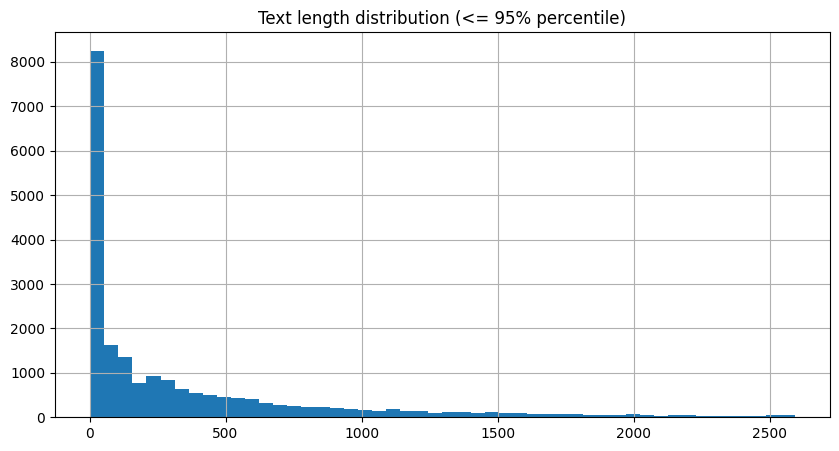

In [29]:
t95 = session_df["text_len"].quantile(0.95)

session_df[session_df["text_len"] <= t95]["text_len"].hist(bins=50, figsize=(10,5))
plt.title("Text length distribution (<= 95% percentile)")
plt.show()

### Text length overview

25% of sessions have fewer than 8 characters of text.
Such chats don't carry semantics for NLP.

Median = 150 characters
Normal short dialogues.

75th percentile = 592 characters
Most real-world dialogues fit within 0.5–1 screen of text.

Max = 255,327 characters
a long technical correspondence,
or several sessions were merged together by mistake.

These types of messages shouldn't be deleted, but rather limited or processed separately (even as a "long session cluster").

### Practical implications for NLP

To obtain a dataset that BERTopic / TF-IDF can adequately process we need to:

- retain only sessions with text_len > min 50 symbols

- ttr_minutes is not NaN

- duration_minutes > 0

In [30]:
session_df["is_long"] = session_df["text_len"] > 5000
session_df["is_long"].mean()

np.float64(0.015299405275343896)

In [31]:
n_long = session_df["is_long"].sum()
print(f"Amounth of long sessions, over 5000 sybmols: {n_long}")

Amounth of long sessions, over 5000 sybmols: 337


Sessions with `text_len > 5,000` are rare but might be problematic for NLP models:

- they often contain **multiple topics** mixed into one long transcript,  
- they might be difficult to represent with standard embedding models (BERTopic / transformer-based encoders) without truncation,  
- they can dominate distance calculations and distort the cluster structure.

We therefore mark such sessions.

## <a id="topic-modeling-feature-engineering"></a>Topic Modeling Feature Engineering

after overview and EDA of both datasets we want to create a separate dataset with features useful for topic modeling

In [32]:
# percentage of sessions where there was real dialogue
alive = session_df[session_df["duration_minutes"] > 0]
alive_share = len(alive) / len(session_df)

#️ sessions where support engineer responded
alive_with_reply = alive[alive["ttr_minutes"].notna()]
alive_with_reply_share = len(alive_with_reply) / len(session_df)

# removing very short texts (non-informative)

alive_text = alive_with_reply[alive_with_reply["text_len"] >= 50]
alive_text_share = len(alive_text) / len(session_df)

# excluding long sessions
alive_clean = alive_text[~alive_text["is_long"]]
alive_clean_share = len(alive_clean) / len(session_df)

session_df["is_empty"] = session_df["duration_minutes"] == 0
session_df["has_reply"] = session_df["ttr_minutes"].notna()
session_df["is_informative"] = session_df["text_len"] >= 50
session_df["is_long"] = session_df["text_len"] > 5000

# final flag: text is ready for NLP
session_df["is_nlp_ready"] = (
    session_df["duration_minutes"] > 0
    & session_df["has_reply"]
    & session_df["is_informative"]
    & (~session_df["is_long"])
)

To simplify further analysis, logical features reflecting the quality and structure of each session were added to the `session_df` table:

- **is_empty** — a session without real dialogue (`duration_minutes == 0`)
- **has_reply** — the operator responded at least once (`ttr_minutes not NaN`)
- **is_informative** — the session contains meaningful text (`text_len >= 50`)
- **is_long** — rare technical "sheets" (`text_len > 5000`)
- **is_nlp_ready** — the session is fully suitable for text analysis (all conditions above are met)

These features allow you to:
- quickly filter the required subsets,
- calculate statistics by session type,
- build client aggregates,
- Generate a corpus for thematic analysis (`nlp_df`) without complex conditions.

This approach increases the transparency of the analysis

In [33]:
session_df.head()

,session_index,session_start,session_end,session_duration,duration_minutes,clean_transcript,ttr,ttr_minutes,anon_id,year,month,is_empty,has_reply,text_len,is_long,is_informative,is_nlp_ready
0,0,2016-04-30 23:25:37,2016-05-01 06:17:29,0 days 06:51:52,411.866667,"здравствуйте у меня вопросы по тесту,хочу посм...",0 days 06:50:16,410.266667,1,2016,2016-04,False,True,511,False,True,True
1,1,2016-05-01 12:18:51,2016-05-01 12:18:51,0 days 00:00:00,0.000000,<Сергей>,NaN,NaN,1,2016,2016-05,True,False,8,False,False,False
2,0,2018-12-10 07:28:40,2018-12-10 07:44:36,0 days 00:15:56,15.933333,: Title: Hexcore. Надежные виртуальные серверы...,0 days 00:05:30,5.500000,2,2018,2018-12,False,True,1264,False,True,True
3,1,2018-12-11 19:01:49,2018-12-11 19:01:49,0 days 00:00:00,0.000000,<Сергей>,NaN,NaN,2,2018,2018-12,True,False,8,False,False,False
4,0,2023-07-11 19:16:05,2023-07-11 19:21:39,0 days 00:05:34,5.566667,: Title: Панель управления URL: https://hexcor...,0 days 00:02:23,2.383333,3,2023,2023-07,False,True,262,False,True,True


In [34]:
# Session difference overview
flags = ["is_empty", "has_reply", "is_informative", "is_long", "is_nlp_ready"]

summary = (
    session_df[flags]
    .mean()
    .round(3)                      
    .to_frame("share")           
    .assign(share=lambda df: df["share"] * 100)   
)

summary.index.name = "flag"
summary["share"] = summary["share"].map(lambda x: f"{x:.1f}%")
summary

,share
flag,
is_empty,45.4%
has_reply,44.7%
is_informative,62.6%
is_long,1.5%
is_nlp_ready,54.6%


How many NLP-ready sessions are there in 2022–2025?

Calculationg two numbers:

What proportion of all sessions is is_nlp_ready & the year 2022–2025;

What proportion of all is_nlp_ready sessions are in 2022–2025?

In [35]:
mask_nlp = session_df["is_nlp_ready"]
mask_recent = session_df["year"].between(2022, 2025)

n_total = len(session_df)
n_nlp = mask_nlp.sum()
n_nlp_recent = (mask_nlp & mask_recent).sum()

share_nlp_total = n_nlp / n_total
share_nlp_recent_total = n_nlp_recent / n_total
share_nlp_recent_within_nlp = n_nlp_recent / n_nlp

print("Total sessions:", n_total)
print(f"is_nlp_ready: {n_nlp} ({share_nlp_total:.1%} from total)")
print(
    "is_nlp_ready at 2022–2025:",
    n_nlp_recent,
    f"({share_nlp_recent_total:.1%} from total, "
    f"{share_nlp_recent_within_nlp:.1%} from total nlp_ready)"
)

Total sessions: 22027
is_nlp_ready: 12017 (54.6% from total)
is_nlp_ready at 2022–2025: 3940 (17.9% from total, 32.8% from total nlp_ready)


## <a id="baseline-model-latent-dirichlet-allocation-lda"></a>Baseline Model: Latent Dirichlet Allocation (LDA)

We use **Latent Dirichlet Allocation (LDA)** as our baseline model for the following reasons:

1. **Established standard**: LDA is a widely-used probabilistic topic modeling approach and serves as the industry baseline for unsupervised text clustering tasks.

2. **Interpretability**: As a generative model, LDA provides clear probabilistic interpretations of topics and document assignments, making results easy to validate with domain experts.

3. **Bag-of-words foundation**: LDA works with term frequencies (CountVectorizer), representing a simpler feature space compared to embedding-based methods. This allows us to demonstrate the limitations of lexical approaches before moving to semantic embeddings.

4. **Soft clustering**: Unlike k-means (which we rejected due to extreme cluster imbalance), LDA assigns documents to topics probabilistically, which is more appropriate for short customer support messages that may relate to multiple themes.

### Baseline Objectives

The baseline model serves several key purposes:

- **Establish feasibility**: Verify that our dataset contains meaningful topic structure
- **Set performance threshold**: Provide quantitative metrics (coherence, distribution balance) for comparison with advanced models
- **Identify limitations**: Expose weaknesses of bag-of-words approaches (inability to capture semantics, sensitivity to noise) to justify the need for BERTopic
- **Business validation**: Extract interpretable topics that can be reviewed by stakeholders

**Expected outcome**: LDA should identify major topic categories (billing, technical issues, trials) but struggle with semantic nuances, motivating the transition to transformer-based embeddings.

In [36]:
# we only take nlp-ready sessions and create a separate dataframe to work with it

nlp_df = session_df[session_df["is_nlp_ready"]].copy()

In [37]:
nlp_df.head()

,session_index,session_start,session_end,session_duration,duration_minutes,clean_transcript,ttr,ttr_minutes,anon_id,year,month,is_empty,has_reply,text_len,is_long,is_informative,is_nlp_ready
0,0,2016-04-30 23:25:37,2016-05-01 06:17:29,0 days 06:51:52,411.866667,"здравствуйте у меня вопросы по тесту,хочу посм...",0 days 06:50:16,410.266667,1,2016,2016-04,False,True,511,False,True,True
2,0,2018-12-10 07:28:40,2018-12-10 07:44:36,0 days 00:15:56,15.933333,: Title: Hexcore. Надежные виртуальные серверы...,0 days 00:05:30,5.500000,2,2018,2018-12,False,True,1264,False,True,True
4,0,2023-07-11 19:16:05,2023-07-11 19:21:39,0 days 00:05:34,5.566667,: Title: Панель управления URL: https://hexcor...,0 days 00:02:23,2.383333,3,2023,2023-07,False,True,262,False,True,True
6,0,2017-10-01 14:45:58,2017-10-01 17:59:45,0 days 03:13:47,193.783333,Здравствуйте а из тстового сервера доступен вы...,0 days 03:12:34,192.566667,4,2017,2017-10,False,True,348,False,True,True
8,0,2025-03-03 18:23:14,2025-03-03 21:37:02,0 days 03:13:48,193.800000,: Title: Панель управления URL: https://hexcor...,0 days 00:01:39,1.650000,5,2025,2025-03,False,True,1148,False,True,True


In [38]:
nlp_df.shape

(12017, 17)

In [39]:
# drop off columns we won't need for nlp

nlp_df = nlp_df[[
    "anon_id",
    "session_index",
    "year",
    "month",
    "duration_minutes",
    "ttr_minutes",
    "text_len",
    "clean_transcript",
]]
nlp_df.rename(columns={"clean_transcript": "text_raw"}, inplace=True)

In [40]:
# creating categorical feature for text length

nlp_df["len_bucket"] = pd.cut(
    nlp_df["text_len"],
    bins=[0, 200, 1000, 5000],
    labels=["short", "medium", "long"]
)

We expect our chat support log consists of a different language, mostly Russian and English. THis is important for clusterization

In [41]:
# simple check for kyrillic and latin alphabet

def detect_script(text):
    cyrillic = len(re.findall(r'[а-яё]', text.lower()))
    latin = len(re.findall(r'[a-z]', text.lower()))
    return 'ru' if cyrillic > latin else 'en'

# distribution
nlp_df['lang_guess'] = nlp_df['text_raw'].apply(detect_script)
print(nlp_df['lang_guess'].value_counts())

lang_guess
ru    9172
en    2845
Name: count, dtype: int64


In [48]:
# PATTERNS & STOP-WORDS CLEANING

# Large service blocks (banners, metadata)
META_BLOCK_PATTERNS = [
    r"Title:[^\n]*?URL:[^\n]*?(?:IP:[^\n]*)?",
    r"Title:\s*Hexcore[^\n]*",
]

# Small metadata patterns
SMALL_META_PATTERNS = [
    r"URL:\s*https?://\S+",
    r"https?://\S+",
    r"IP:\s*\d{1,3}(?:\.\d{1,3}){3}",
]

# Template greetings and auto-responses
TEMPLATE_PATTERNS = [
    r"Здравствуйте[\s,\.!]+готовы ответить на ваши вопросы[\.!\s]*",
    r"Чем я могу вам помочь[\s,\.!?]",
    r"Здравствуйте[\s,\.!]+мы онлайн[\s,\.!]+пожалуйста[\s,\.!]+задавайте ваши вопросы[\.!\s]*",
    r"Здравствуйте[\s,\.!]+задавайте ваши вопросы[\.!\s]*",
    r"Hello[\s,\.!]+Ask your questions, please[\.!\s]*",
    r"Hello[\s,\.!]+we are online[\.!\s]*",
]

# Russian stop-words
ru_stop = {
    "и", "но", "а", "же", "то", "что", "это", "не", "по", "на", "в", "к", "с",
    "как", "для", "при", "или", "же", "из", "от", "до", "бы", "ли", "мы", "вы",
    "он", "она", "они", "когда", "где", "только", "так", "там", "тут",
    "быть", "мочь", "всё", "есть", "можно", "нет", "да", "если", "этот",
    "день", "сейчас", "ещё", "просто", "ну"
}

# Domain-specific stop-words (politeness)
domain_stop = {
    "здравствуйте", "спасибо", "сергей", "алексей", "добрый", "пожалуйста"
}

# Combined stop-words list
all_stop = list(ENGLISH_STOP_WORDS) + list(ru_stop) + list(domain_stop)

In [49]:
# TEXT PREPROCESSING FOR LDA

# Initialize lemmatizer
morph = pymorphy3.MorphAnalyzer()

def preprocess_for_lda(text: str) -> str:
    """
    Complete preprocessing pipeline for LDA topic modeling.
    
    Steps:
    1. Remove metadata blocks (Title/URL/IP banners)
    2. Remove URLs and IP addresses
    3. Remove template greetings
    4. Remove HTML tags
    5. Lowercase and remove punctuation
    6. Remove technical noise (IPs, long numbers, hex codes)
    7. Lemmatization (Russian + English)
    
    Args:
        text: Raw transcript text
        
    Returns:
        Cleaned and lemmatized text ready for CountVectorizer
    """
    # Step 1-2: Remove metadata
    for pat in META_BLOCK_PATTERNS:
        text = re.sub(pat, " ", text, flags=re.IGNORECASE)
    for pat in SMALL_META_PATTERNS:
        text = re.sub(pat, " ", text, flags=re.IGNORECASE)
    
    # Step 3: Remove templates
    for pat in TEMPLATE_PATTERNS:
        text = re.sub(pat, " ", text, flags=re.IGNORECASE)
    
    # Step 4: Remove HTML tags
    text = re.sub(r"<[^>]+>", " ", text)
    
    # Step 5: Basic normalization
    text = text.lower()
    text = re.sub(r"[^a-zа-яё0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    
    # Step 6: Remove technical noise
    text = re.sub(r'\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b', ' ', text)  # IPs
    text = re.sub(r'\b\d+\b', ' ', text)  # All numbers
    text = re.sub(r'\b[a-f0-9]{8,}\b', ' ', text, flags=re.IGNORECASE)  # Hex codes
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Step 7: Lemmatization
    words = text.split()
    lemmatized = []
    for word in words:
        if len(word) < 2:
            continue
        parsed = morph.parse(word)[0]
        lemmatized.append(parsed.normal_form)
    
    return " ".join(lemmatized)

In [50]:
# APPLY PREPROCESSING

print("Starting lemmatization... (may take 1-2 minutes)")
nlp_df["text_lemmatized"] = nlp_df["text_raw"].apply(preprocess_for_lda)

Starting lemmatization... (may take 1-2 minutes)


In [61]:
# VALIDATION: Check vocabulary reduction

print("PREPROCESSING VALIDATION")

# Sample outputs
print("\nSample preprocessed texts:")
for i in range(3):
    print(f"\n--- Sample {i+1} ---")
    print(f"Original: {nlp_df['text_raw'].iloc[i][:150]}...")
    print(f"Preprocessed: {nlp_df['text_lemmatized'].iloc[i][:150]}...")

# Vocabulary size comparison
print("VOCABULARY REDUCTION")


cv_before = CountVectorizer(stop_words=all_stop, max_features=None)
cv_before.fit(nlp_df["text_raw"].apply(lambda x: x.lower()))

cv_after = CountVectorizer(stop_words=all_stop, max_features=None)
cv_after.fit(nlp_df["text_lemmatized"])

vocab_reduction = len(cv_before.vocabulary_) - len(cv_after.vocabulary_)
reduction_pct = (vocab_reduction / len(cv_before.vocabulary_)) * 100

print(f"\nVocabulary size WITHOUT preprocessing: {len(cv_before.vocabulary_):,}")
print(f"Vocabulary size WITH preprocessing: {len(cv_after.vocabulary_):,}")
print(f"Reduction: {vocab_reduction:,} words ({reduction_pct:.1f}%)")

PREPROCESSING VALIDATION

Sample preprocessed texts:

--- Sample 1 ---
Original: здравствуйте у меня вопросы по тесту,хочу посмотреть на тесте я не могу поставить винду 2008 r2?по прямой ссылке.вроде написано что можно свою ось и д...
Preprocessed: здравствуйте я вопрос по тест хотеть посмотреть на тест не мочь поставить винд r2 по прямой ссылка вроде написать что можно свой ось добавить оператив...

--- Sample 2 ---
Original: : Title: Hexcore. Надежные виртуальные серверы VDS на SSD-дисках. Арендовать VDS сервер от HexCore. URL: https://hexcore.ru/ IP: 176.59.71.192 Здравст...
Preprocessed: здравствуйте мы есть бесплатный тест на день необходимо только зарегистрироваться добрый день активировать случай активация тестовый период вы прийти ...

--- Sample 3 ---
Original: : Title: Панель управления URL: https://hexcore.ru/cp/ru IP: 176.106.157.183 Добрый день! Я перевел почту с яндекса на гугл и теперь не отображается м...
Preprocessed: добрый день перевести почта яндекс на гугл теперь н

/opt/homebrew/Cellar/jupyterlab/4.4.4/libexec/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['hexcore', 'https', 'ru'] not in stop_words.
  warnings.warn(



Vocabulary size WITHOUT preprocessing: 84,503
Vocabulary size WITH preprocessing: 37,573
Reduction: 46,930 words (55.5%)


### Hyperparameter Selection for LDA

#### Number of Topics (`n_components=15`)

We tested multiple values (10, 15, 20, 25) and selected **15 topics** based on:
- **Topic coherence**: Balance between granularity and interpretability
- **Business relevance**: Domain experts confirmed 15 topics align with major support categories
- **Distribution balance**: Coefficient of variation (0.66) indicates moderate variability without extreme imbalance

Fewer topics (10) resulted in overly broad, mixed themes. More topics (20) introduced fragmented micro-topics with technical noise.

#### Vectorization Parameters

**`CountVectorizer` settings:**
- **`max_features=5000`**: Limits vocabulary to top 5,000 terms, balancing coverage and computational efficiency
- **`min_df=5`**: Excludes rare words appearing in <5 documents, reducing noise from typos and unique identifiers
- **`max_df=0.7`**: Removes words appearing in >70% of documents (overly common terms that don't differentiate topics)
- **`ngram_range=(1,2)`**: Includes unigrams and bigrams to capture multi-word phrases like "тестовый период" (trial period) and "панель управление" (control panel)

#### Stop Words

Combined three stop-word sets:
1. English stop words (sklearn default)
2. Russian stop words (common function words)
3. Domain-specific stop words (greetings, agent names, politeness markers)

This reduced vocabulary by **55.5%** (84,503 → 37,573 terms) while preserving semantic content.

#### Training Parameters

- **`max_iter=20`**: Sufficient for convergence on our dataset size (~12k documents)
- **`learning_method='batch'`**: More stable than online learning for datasets of this size
- **`random_state=42`**: Ensures reproducibility


In [52]:
count_vectorizer = CountVectorizer(
    max_features=5000,      # Limit vocabulary to top 5000 words
    min_df=5,               # Word must appear in at least 5 documents
    max_df=0.7,             # Word must not appear in more than 70% of documents
    ngram_range=(1, 2),     # Include unigrams and bigrams
    stop_words=all_stop
)

X_counts = count_vectorizer.fit_transform(nlp_df["text_lemmatized"])
print(f"\nCount matrix shape: {X_counts.shape}")
print(f"Documents: {X_counts.shape[0]:,}")
print(f"Features (vocabulary): {X_counts.shape[1]:,}")
print(f"Sparsity: {(1 - X_counts.nnz / (X_counts.shape[0] * X_counts.shape[1])) * 100:.2f}%")


# Train LDA Model

n_topics = 15  # Number of topics to extract

print(f"\nTraining LDA with {n_topics} topics...")

lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    max_iter=20,           # Maximum iterations for convergence
    learning_method='batch',
    n_jobs=-1              # Use all CPU cores
)

# Fit model and get document-topic distributions
doc_topic_dist = lda.fit_transform(X_counts)


Count matrix shape: (12017, 5000)
Documents: 12,017
Features (vocabulary): 5,000
Sparsity: 99.17%

Training LDA with 15 topics...


In [53]:
# Assign each document to its dominant topic
nlp_df["topic_lda"] = doc_topic_dist.argmax(axis=1)

# Also store the probability of the dominant topic
nlp_df["topic_lda_prob"] = doc_topic_dist.max(axis=1)

print(f"\nMean dominant topic probability: {nlp_df['topic_lda_prob'].mean():.3f}")
print(f"Median dominant topic probability: {nlp_df['topic_lda_prob'].median():.3f}")


Mean dominant topic probability: 0.613
Median dominant topic probability: 0.614


In [60]:
# Topic Distribution Analysis


print("TOPIC DISTRIBUTION")

topic_counts = nlp_df["topic_lda"].value_counts().sort_index()
print(f"\n{topic_counts}")

print("DISTRIBUTION STATISTICS")
print("-"*80)
print(f"Total topics: {n_topics}")
print(f"Largest topic size: {topic_counts.max():,} ({topic_counts.max() / len(nlp_df) * 100:.1f}%)")
print(f"Smallest topic size: {topic_counts.min():,} ({topic_counts.min() / len(nlp_df) * 100:.1f}%)")
print(f"Average topic size: {topic_counts.mean():.1f}")
print(f"Std deviation: {topic_counts.std():.1f}")
print(f"Coefficient of variation: {(topic_counts.std() / topic_counts.mean()):.2f}")

TOPIC DISTRIBUTION

topic_lda
0     1017
1      833
2     1387
3       37
4     1235
5     1279
6      137
7       71
8      741
9      697
10    1437
11     115
12    1093
13     484
14    1454
Name: count, dtype: int64
DISTRIBUTION STATISTICS
--------------------------------------------------------------------------------
Total topics: 15
Largest topic size: 1,454 (12.1%)
Smallest topic size: 37 (0.3%)
Average topic size: 801.1
Std deviation: 525.6
Coefficient of variation: 0.66


In [58]:
# Extract Top Words per Topic

print("\n" + "="*80)
print("TOP WORDS PER TOPIC")
print("="*80)

feature_names = count_vectorizer.get_feature_names_out()

def get_top_words(topic_idx, n_words=15):
    """Extract top words for a given topic."""
    topic = lda.components_[topic_idx]
    top_indices = topic.argsort()[::-1][:n_words]
    return [feature_names[i] for i in top_indices]

# Display topics with their top words
for topic_id in range(n_topics):
    topic_size = topic_counts[topic_id]
    top_words = get_top_words(topic_id, n_words=15)
    
    print(f"\nTopic {topic_id} (size: {topic_size:,}, {topic_size / len(nlp_df) * 100:.1f}%)")
    print(f"  {', '.join(top_words)}")


TOP WORDS PER TOPIC

Topic 0 (size: 1,017, 8.5%)
  ipv6, bytes, 2a04, ac00, 2a04 ac00, eth0, ping, time, icmp, seq, inet, 2a06, link, icmp seq, wmz

Topic 1 (size: 833, 6.9%)
  сторона, наш, сервер, проблема, ваш, проверить, ip, png, наш сторона, какой, работать, пинг, image, image png, через

Topic 2 (size: 1,387, 11.5%)
  hello, server, ok, hi, check, email, blocked, account, thank, ip, want, vps, pay, paypal, yes

Topic 3 (size: 37, 0.3%)
  dev, команда, передача, ошибка, users, рулетка, downloads, length, байт, mem, статус, файл, remote, mx, error

Topic 4 (size: 1,235, 10.3%)
  сервер, ошибка, ваш, работать, домен, ваш сервер, панель, сайт, какой, сделать, включить, попробовать, посмотреть, запись, через

Topic 5 (size: 1,279, 10.6%)
  тариф, сервер, за, какой, нужный, цена, сколько, такой, ваш, канал, руб, лицензия, месяц, хотеть, понять

Topic 6 (size: 137, 1.1%)
  ms, образ, ms ms, iso, ос, подключить, net, установить, установка, sun, время, jul, windows, число, версия

Topic 

In [57]:
# Create Topic Summary DataFrame

topic_summary = pd.DataFrame({
    'Topic_ID': range(n_topics),
    'Size': [topic_counts.get(i, 0) for i in range(n_topics)],
    'Percentage': [topic_counts.get(i, 0) / len(nlp_df) * 100 for i in range(n_topics)],
    'Top_Words': [', '.join(get_top_words(i, n_words=10)) for i in range(n_topics)]
})

print("\nLDA TOPIC SUMMARY")
print(topic_summary.to_string(index=False))


LDA TOPIC SUMMARY
 Topic_ID  Size  Percentage                                                                                                  Top_Words
        0  1017    8.463011                                            ipv6, bytes, 2a04, ac00, 2a04 ac00, eth0, ping, time, icmp, seq
        1   833    6.931847                                сторона, наш, сервер, проблема, ваш, проверить, ip, png, наш сторона, какой
        2  1387   11.541982                                           hello, server, ok, hi, check, email, blocked, account, thank, ip
        3    37    0.307897                               dev, команда, передача, ошибка, users, рулетка, downloads, length, байт, mem
        4  1235   10.277107                             сервер, ошибка, ваш, работать, домен, ваш сервер, панель, сайт, какой, сделать
        5  1279   10.643255                                         тариф, сервер, за, какой, нужный, цена, сколько, такой, ваш, канал
        6   137    1.140052         

In [64]:
# interactive cluster visualisation

print("Generating interactive pyLDAvis visualization...")

# Prepare visualization data
vis_data = pyLDAvis.lda_model.prepare(
    lda,
    X_counts,
    count_vectorizer,
    mds='tsne',  # or 'pcoa' for faster rendering
    R=15,        # number of top terms to display
    sort_topics=False
)

# Display 
pyLDAvis.display(vis_data)

Generating interactive pyLDAvis visualization...


In [69]:
# coherence score
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary


# Prepare texts for coherence calculation
texts = [text.split() for text in nlp_df["text_lemmatized"]]
dictionary = Dictionary(texts)

# Extract topics in gensim format
topics_for_coherence = []
for i in range(n_topics):
    topic = lda.components_[i]
    top_indices = topic.argsort()[::-1][:10]
    topic_words = [feature_names[idx] for idx in top_indices]
    topics_for_coherence.append(topic_words)

# Calculate C_v coherence (best for interpretability)
coherence_model = CoherenceModel(
    topics=topics_for_coherence,
    texts=texts,
    dictionary=dictionary,
    coherence='c_v'
)

coherence_lda = coherence_model.get_coherence()


print(f"LDA Coherence Score (C_v): {coherence_lda:.4f}")
print("\nInterpretation:")
print("  0.0-0.3: Poor topic quality")
print("  0.3-0.5: Moderate quality")
print("  0.5-0.7: Good quality")
print("  0.7+:    Excellent quality")

LDA Coherence Score (C_v): 0.6318

Interpretation:
  0.0-0.3: Poor topic quality
  0.3-0.5: Moderate quality
  0.5-0.7: Good quality
  0.7+:    Excellent quality


In [70]:
# MODEL PERPLEXITY

perplexity = lda.perplexity(X_counts)
print(f"\nLDA Perplexity: {perplexity:.2f}")
print("(Lower is better, but doesn't guarantee interpretability)")


LDA Perplexity: 1110.49
(Lower is better, but doesn't guarantee interpretability)


In [71]:
# SAMPLE DOCUMENTS PER TOPIC

def show_topic_examples(topic_id, n_samples=3):
    """Display sample documents for a given topic."""
    
    # Get documents assigned to this topic
    topic_docs = nlp_df[nlp_df["topic_lda"] == topic_id]
    
    # Sort by topic probability (most representative first)
    topic_docs = topic_docs.nlargest(n_samples, "topic_lda_prob")
    
    print(f"\n{'='*80}")
    print(f"TOPIC {topic_id} - Sample Documents")
    print(f"Topic size: {len(nlp_df[nlp_df['topic_lda'] == topic_id])} documents")
    print(f"Top words: {', '.join(get_top_words(topic_id, n_words=8))}")
    print(f"{'='*80}")
    
    for idx, (i, row) in enumerate(topic_docs.iterrows(), 1):
        print(f"\n--- Example {idx} (probability: {row['topic_lda_prob']:.3f}) ---")
        print(row['text_raw'][:300] + "...")

# Show examples for key topics
key_topics = [14, 12, 5, 9]  # billing, trial, pricing, access
for topic_id in key_topics:
    show_topic_examples(topic_id, n_samples=2)


TOPIC 14 - Sample Documents
Topic size: 1454 documents
Top words: счёт, сервер, оплата, за, оплатить, баланс, месяц, деньга

--- Example 1 (probability: 0.990) ---
: Title: Панель управления URL: https://hexcore.ru/cp/ru IP: 91.236.224.91 Здравствуйте, а почему у меня после удаления 1 сервера баланс ушел в минус? <Сергей> Здравствуйте! При удалении сервера до окончания оплаченного периода происходит перерасчет по часам. Это немного дороже чем ежемесячная оплат...

--- Example 2 (probability: 0.990) ---
: Title: Hexcore. Надежные виртуальные серверы VDS на SSD-дисках. Арендовать VDS сервер от HexCore. URL: https://hexcore.ru/ IP: 109.234.12.132 добрый день у меня списалась абонентская плата за сервер который я удалил <Сергей> Здравствуйте! Сейчас посмотрим Можете названить ID сервера или дату, когд...

TOPIC 12 - Sample Documents
Topic size: 1093 documents
Top words: тест, необходимо, email, тестовый, зарегистрироваться, сервер, бесплатный, запись

--- Example 1 (probability: 0.993) --

In [72]:
# selecting key topics from clusters

topic_map = {
    "billing_payments": {
        "label": "Billing, Payments & Invoices",
        "topics": [14, 11],  # billing/payments + discounts
        "color": "#e74c3c"
    },
    
    "trial_registration": {
        "label": "Trial Period & Account Registration",
        "topics": [12],  # trial/email/registration
        "color": "#3498db"
    },
    
    "pricing_tariffs": {
        "label": "Pricing, Tariffs & Licensing",
        "topics": [5],  # tariffs/pricing/licenses
        "color": "#9b59b6"
    },
    
    "access_authentication": {
        "label": "Access, Passwords & SSH",
        "topics": [9],  # passwords/console/SSH
        "color": "#f39c12"
    },
    
    "infrastructure": {
        "label": "Infrastructure & Network Configuration",
        "topics": [8, 0],  # IPs/disks + IPv6
        "color": "#1abc9c"
    },
    
    "technical_issues": {
        "label": "Server Errors & Technical Problems",
        "topics": [4, 10, 13],  # server errors + general issues + availability
        "color": "#e67e22"
    },
    
    "system_configuration": {
        "label": "OS, Images & System Setup",
        "topics": [6, 7],  # OS/images + system errors
        "color": "#95a5a6"
    },
    
    "support_communication": {
        "label": "Support Communication",
        "topics": [1, 2],  # Russian support + English support
        "color": "#34495e"
    },
    
    "technical_noise": {
        "label": "Technical Artifacts (Low Priority)",
        "topics": [3],  # dev/commands (only 37 docs)
        "color": "#bdc3c7"
    }
}

In [76]:
# adding a column with the topic name

# Create reverse mapping: topic_id -> meta_cluster
topic_to_meta = {}
for meta_name, meta_info in topic_map.items():
    for topic_id in meta_info["topics"]:
        topic_to_meta[topic_id] = {
            "meta_cluster": meta_name,
            "label": meta_info["label"],
            "color": meta_info["color"]
        }

# Add meta-cluster info to dataframe
nlp_df["meta_cluster"] = nlp_df["topic_lda"].map(
    lambda x: topic_to_meta.get(x, {}).get("meta_cluster", "other")
)
nlp_df["meta_label"] = nlp_df["topic_lda"].map(
    lambda x: topic_to_meta.get(x, {}).get("label", "Other")
)

# Display meta-cluster distribution
print("META-CLUSTER DISTRIBUTION")
print("="*80)

meta_counts = nlp_df["meta_cluster"].value_counts()
for meta_name, count in meta_counts.items():
    pct = count / len(nlp_df) * 100
    label = topic_map.get(meta_name, {}).get("label", meta_name)
    print(f"{label:45s}: {count:5d} ({pct:5.1f}%)")

META-CLUSTER DISTRIBUTION
Server Errors & Technical Problems           :  3156 ( 26.3%)
Support Communication                        :  2220 ( 18.5%)
Infrastructure & Network Configuration       :  1758 ( 14.6%)
Billing, Payments & Invoices                 :  1569 ( 13.1%)
Pricing, Tariffs & Licensing                 :  1279 ( 10.6%)
Trial Period & Account Registration          :  1093 (  9.1%)
Access, Passwords & SSH                      :   697 (  5.8%)
OS, Images & System Setup                    :   208 (  1.7%)
Technical Artifacts (Low Priority)           :    37 (  0.3%)


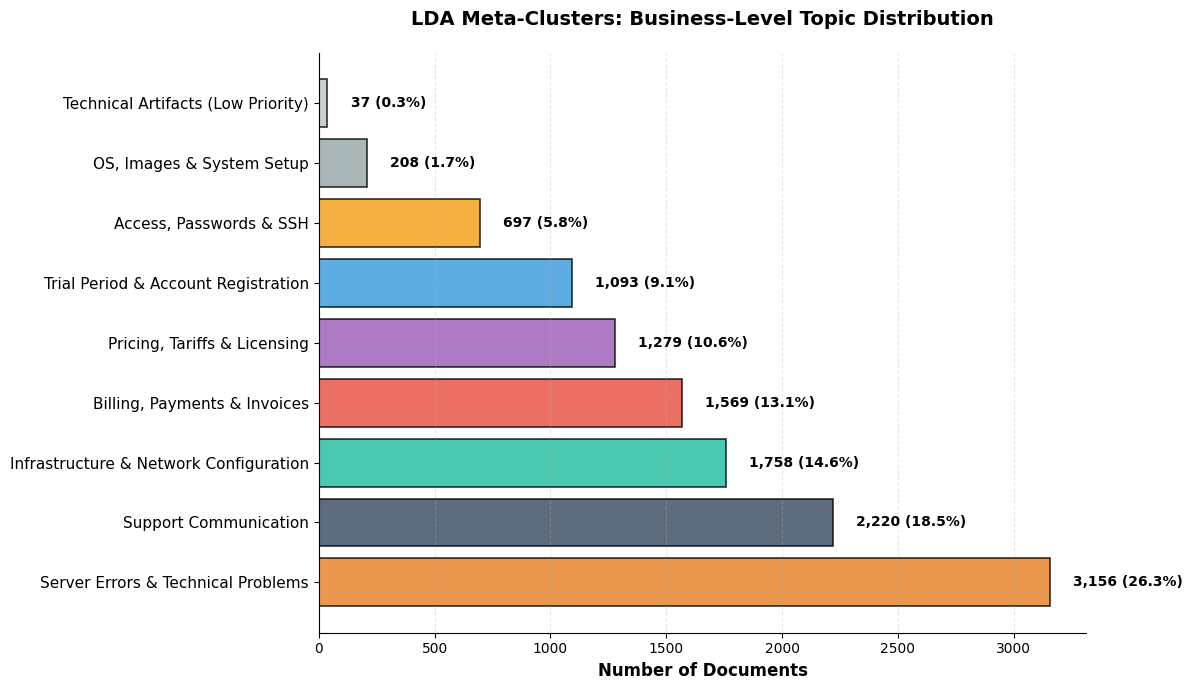

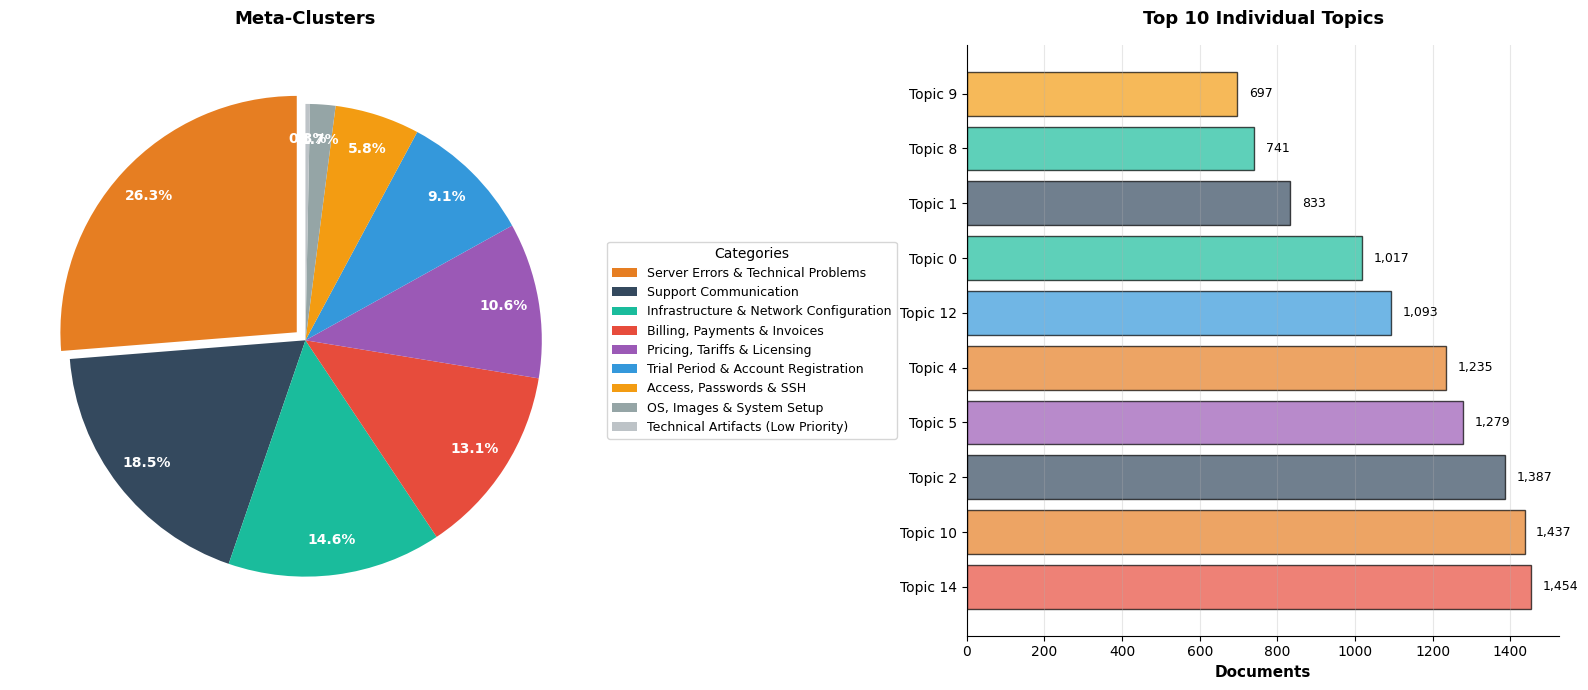

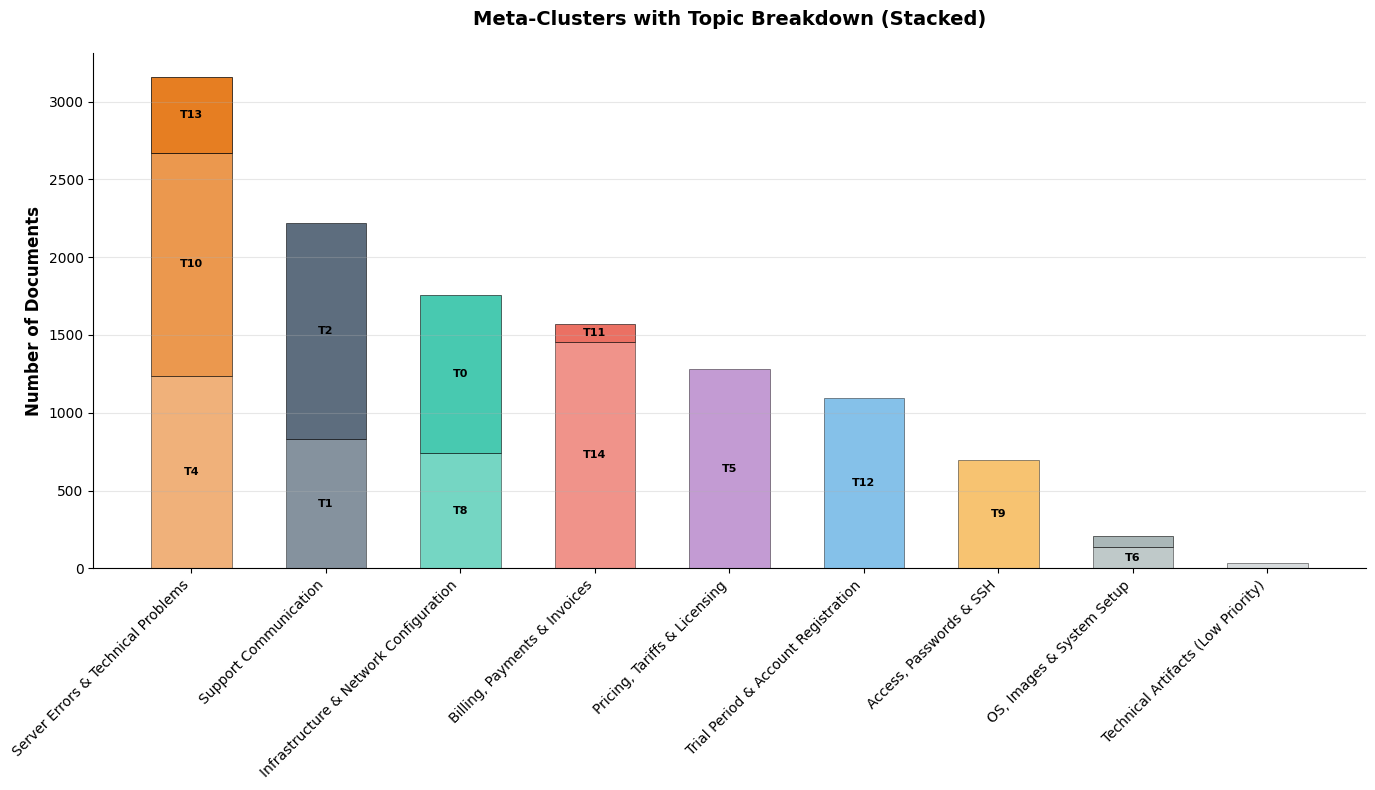


Visualization complete! ✓


In [78]:
# META-CLUSTER VISUALIZATION

# Prepare data
meta_counts = nlp_df["meta_cluster"].value_counts()
meta_labels = [topic_map.get(m, {}).get("label", m) for m in meta_counts.index]
meta_colors = [topic_map.get(m, {}).get("color", "#95a5a6") for m in meta_counts.index]


# Chart 1: Horizontal Bar Chart (Clean & Professional)

fig, ax = plt.subplots(figsize=(12, 7))

# Create bars
y_pos = np.arange(len(meta_labels))
bars = ax.barh(y_pos, meta_counts.values, color=meta_colors, alpha=0.8, edgecolor='black', linewidth=1.2)

# Add percentage labels
for i, (count, bar) in enumerate(zip(meta_counts.values, bars)):
    pct = count / len(nlp_df) * 100
    ax.text(count + 100, i, f'{count:,} ({pct:.1f}%)', 
            va='center', fontsize=10, fontweight='bold')

# Styling
ax.set_yticks(y_pos)
ax.set_yticklabels(meta_labels, fontsize=11)
ax.set_xlabel('Number of Documents', fontsize=12, fontweight='bold')
ax.set_title('LDA Meta-Clusters: Business-Level Topic Distribution', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


# Chart 2: Pie Chart with Topic Breakdown

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Left: Meta-cluster pie
wedges, texts, autotexts = ax1.pie(
    meta_counts.values, 
    labels=None,
    colors=meta_colors,
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.85,
    explode=[0.05 if i == 0 else 0 for i in range(len(meta_counts))]
)

# Style percentages
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')

ax1.set_title('Meta-Clusters', fontsize=13, fontweight='bold', pad=15)

# Legend for pie
ax1.legend(wedges, meta_labels, 
          title="Categories",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),
          fontsize=9)

# Right: Individual topics (top 10)
topic_counts_top10 = nlp_df["topic_lda"].value_counts().head(10)
colors_top10 = [meta_colors[list(meta_counts.index).index(topic_to_meta.get(t, {}).get("meta_cluster", "other"))] 
                if t in topic_to_meta else "#95a5a6" 
                for t in topic_counts_top10.index]

bars = ax2.barh(range(len(topic_counts_top10)), topic_counts_top10.values, 
                color=colors_top10, alpha=0.7, edgecolor='black')

# Add labels
topic_labels_short = [f"Topic {t}" for t in topic_counts_top10.index]
ax2.set_yticks(range(len(topic_counts_top10)))
ax2.set_yticklabels(topic_labels_short, fontsize=10)
ax2.set_xlabel('Documents', fontsize=11, fontweight='bold')
ax2.set_title('Top 10 Individual Topics', fontsize=13, fontweight='bold', pad=15)
ax2.grid(axis='x', alpha=0.3)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Add count labels
for i, count in enumerate(topic_counts_top10.values):
    ax2.text(count + 30, i, f'{count:,}', va='center', fontsize=9)

plt.tight_layout()
plt.show()


# Chart 3: Stacked Bar (Meta-clusters with topic breakdown)
fig, ax = plt.subplots(figsize=(14, 8))

# Prepare data for stacked bars
meta_topic_data = {}
for meta_name in meta_counts.index:
    topics = topic_map[meta_name]["topics"]
    meta_topic_data[meta_name] = [
        len(nlp_df[(nlp_df["topic_lda"] == t)]) for t in topics
    ]

# Create stacked bars
bar_width = 0.6
x_pos = np.arange(len(meta_counts))
bottom = np.zeros(len(meta_counts))

for i, meta_name in enumerate(meta_counts.index):
    topics = topic_map[meta_name]["topics"]
    heights = meta_topic_data[meta_name]
    
    for j, (topic_id, height) in enumerate(zip(topics, heights)):
        ax.bar(i, height, bar_width, bottom=bottom[i], 
               color=meta_colors[i], alpha=0.6 + (j * 0.2),
               edgecolor='black', linewidth=0.5,
               label=f"Topic {topic_id}" if i == 0 else "")
        
        # Add topic ID label if segment is large enough
        if height > 100:
            ax.text(i, bottom[i] + height/2, f"T{topic_id}", 
                   ha='center', va='center', fontsize=8, fontweight='bold')
        
        bottom[i] += height

# Styling
ax.set_xticks(x_pos)
ax.set_xticklabels([topic_map[m]["label"] for m in meta_counts.index], 
                   rotation=45, ha='right', fontsize=10)
ax.set_ylabel('Number of Documents', fontsize=12, fontweight='bold')
ax.set_title('Meta-Clusters with Topic Breakdown (Stacked)', 
            fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

print("\nVisualization complete! ✓")

### LDA Baseline: Summary & Limitations

#### Key Findings

**Model Performance:**
- 15 topics with moderate balance (CV = 0.66)
- Coherence score: 0.632 (good quality)
- Clear business categories identified: billing (13.1%), technical issues (26.3%), trials (9.1%)

**Interpretability:**
- Most topics align with expected support categories
- Meta-clustering reveals 9 high-level business themes
- Visualisation already show good finfings such as server errors most often and expected technical issue

#### Critical Limitations

1. **Semantic blindness**: Cannot distinguish "сервер работает" vs "сервер не работает" — both have similar word frequencies

2. **Technical noise persists**: Topics 0, 3, 6 contain system artifacts (IPv6, commands) despite aggressive preprocessing

3. **Mixed themes**: Topic 10 blends general issues with DDoS attacks; Topic 13 mixes availability and PHP errors

4. **Short text weakness**: Average message length ~60 tokens provides limited lexical signal for frequency-based methods

#### Motivation for BERTopic

These limitations require **semantic embeddings**:
- Contextual understanding, not just word co-occurrence
- Better handling of short, noisy customer messages
- Multilingual support (Russian + English) without translation
- More robust clustering (HDBSCAN vs. probabilistic assignment)

**Hypothesis**: BERTopic will achieve higher coherence, cleaner topic separation, and fewer outliers which let us to do historical overview and business analysis of tickets on more actual period of time

## <a id="topic-modeling-with-embedding-based-methods"></a>Topic Modeling with Embedding-Based Methods


In [295]:
# new separate df for this part
nlp_df_bert = session_df[session_df["is_nlp_ready"]].copy()

In [296]:
TEMPLATE_PATTERNS += [
    r"^здравствуйте[,!\s]*$",
    r"^спасибо[,!\s]*$",
    r"^(добрый день|добрый вечер)[,!\s]*$",
    r"^(hello|hi)[,!\s]*$",
]
# updated after the first run of Bertopik  

In [297]:
# text preprocessing for BERTopic
def prepare_for_bert(text: str) -> str:
    """
    Lightweight preprocessing for BERTopic (preserves context for embeddings).
    Removes metadata and normalizes whitespace only.
    """
    text = strip_meta_blocks(text)
    text = strip_small_meta(text)
    text = strip_templates(text)
    text = strip_html_tags(text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def detect_script(text: str) -> str:
    """Detect if text is primarily Russian, English, or other."""
    text = text.lower()
    cyr = len(re.findall(r"[а-яё]", text))
    lat = len(re.findall(r"[a-z]", text))
    if cyr > lat and cyr > 3:
        return "ru"
    elif lat > cyr and lat > 3:
        return "en"
    else:
        return "other"

# Apply preprocessing
nlp_df_bert["text_bert"] = nlp_df_bert["clean_transcript"].apply(prepare_for_bert)
nlp_df_bert["n_tokens"] = nlp_df_bert["text_bert"].str.split().str.len()
nlp_df_bert["lang_guess"] = nlp_df_bert["text_bert"].apply(detect_script)

print(f"\nOriginal dataset: {nlp_df_bert.shape[0]:,} documents")


min_tokens = 10  # Business decision: exclude very short messages

mask = (
    nlp_df_bert["lang_guess"].isin(["ru", "en"]) &
    (nlp_df_bert["n_tokens"] >= MIN_TOKENS)
)

nlp_df_bert_filtered = nlp_df_bert[mask].copy() # working with this one

print(f"After filtering:")
print(f"  - Language (ru/en only): {(nlp_df_bert['lang_guess'].isin(['ru', 'en'])).sum():,}")
print(f"  - Min tokens (>={MIN_TOKENS}): {(nlp_df_bert['n_tokens'] >= MIN_TOKENS).sum():,}")
print(f"  - Final dataset: {nlp_df_bert_filtered.shape[0]:,} documents")
print(f"  - Filtered out: {nlp_df_bert.shape[0] - nlp_df_bert_filtered.shape[0]:,} documents")


Original dataset: 12,017 documents
After filtering:
  - Language (ru/en only): 11,169
  - Min tokens (>=10): 10,430
  - Final dataset: 10,424 documents
  - Filtered out: 1,593 documents


### Hyperparameter Selection for BERTopic

For the topic model we experimented with several UMAP + HDBSCAN configurations and settled on this one because it produced interpretable topics with a reasonable amount of outliers.

#### Final configuration

#### Embedding model: 
- paraphrase-multilingual-MiniLM-L12-v2
- Supports both Russian and English and is lightweight enough for 10k+ tickets.

#### UMAP

`n_neighbors` = 15 – balances local structure (similar tickets close) and global structure (different topics stay separated).

`n_components` = 5 – reduces 384-dimensional embeddings to 5 dimensions before HDBSCAN to avoid the curse of dimensionality.

`min_dist` = 0.0 – allows dense regions to become compact clusters, which helps HDBSCAN.

`metric` = "cosine" – standard choice for text embeddings where vector direction matters more than magnitude.

#### HDBSCAN

`min_cluster_size` = 30 – business constraint: topics with <30 tickets over ~10 years are not considered stable support patterns.

`min_samples` = 5 – softer density requirement than the default (10).

With min_samples = 10 a large fraction of tickets became outliers, even when they were semantically close to existing topics.

With min_samples = 5 dense topics are preserved, and the number of “purely technical” outliers is reduced.

`cluster_selection_method` = "eom" – standard mode for HDBSCAN.

`cluster_selection_epsilon` = 0.1 – a small ε that only merges very similar clusters and prevents collapsing different problems (e.g. “billing” and “renewal + debt”) into one giant topic.

#### Vectorizer (for topic words)

`ngram_range` = (1, 2) – use unigrams and bigrams to capture stable phrases (“dedicated server”, “service renewal”).

`min_df` = 5 – remove very rare tokens that don’t help topic interpretation.

`max_df` = 0.7 – drop extremely frequent terms that escaped stopword lists.

Stopwords: standard English + Russian + domain-specific (e.g. hexcore, vps, vds) so that boilerplate words do not dominate topic descriptions.

#### Alternatives tested

Changing UMAP (n_neighbors, n_components) and cluster_selection_epsilon (e.g. `n_components` = 10, `epsilon` = 0.15).

This slightly changed topic boundaries and probability distribution, but did not give a qualitative improvement: topics remained similar and interpretability did not increase.

More aggressive HDBSCAN settings (higher epsilon, higher min_samples).

This led either to too many outliers or to mixed, overly broad topics.

Because of that, we kept a conservative and easy-to-explain configuration that yields ~60 stable, interpretable topics and a realistic layer of outliers.

In [298]:
# Embedding model (chose multilingual model as we have russian and english tickets)
embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

# UMAP
umap_model = UMAP(
    n_neighbors=15,      
    n_components=5,      
    min_dist=0.0,        
    metric='cosine',  # because direction is more important than magnitude in high dimentions spaces
    random_state=42
)

# HDBSCAN
hdbscan_model = HDBSCAN(
    min_cluster_size=30, # min cluster size as business desicion
    min_samples=5,             
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True,
    cluster_selection_epsilon=0.1 # tried on and off, it slightly merges nearby clusters, reducing their number
)

# Vectorizer with stop-words
vectorizer_model = CountVectorizer(
    ngram_range=(1, 2),
    stop_words=list(ENGLISH_STOP_WORDS) + list(ru_stop) + list(domain_stop),
    min_df=5, # remove very rare noise
    max_df=0.7 #  exclude super frequent words that don't help differentiate topics
)

# BERTopic
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,             
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    calculate_probabilities=True,
    verbose=True
)

# trainign the model
topics, probs = topic_model.fit_transform(nlp_df_bert_filtered["text_bert"].tolist())

2025-12-23 17:54:49,652 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/326 [00:00<?, ?it/s]

2025-12-23 17:55:28,421 - BERTopic - Embedding - Completed ✓
2025-12-23 17:55:28,422 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-23 17:55:32,937 - BERTopic - Dimensionality - Completed ✓
2025-12-23 17:55:32,939 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-23 17:55:33,914 - BERTopic - Cluster - Completed ✓
2025-12-23 17:55:33,919 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-23 17:55:34,745 - BERTopic - Representation - Completed ✓


In [301]:
# outlier reduction
topics_reduced = topic_model.reduce_outliers(
    nlp_df_bert_filtered["text_bert"].tolist(),
    topics,
    probabilities=probs,
    strategy="probabilities",
    threshold=0.1
)

outliers_after = nlp_df_bert_filtered["topic_bertopic"].eq(-1).sum()
outliers_before = (pd.Series(topics).eq(-1)).sum()

print(f"Outliers BEFORE reduce_outliers: {outliers_before} ({outliers_before / len(topics) * 100:.1f}%)")
print(f"Outliers AFTER reduce_outliers: {outliers_after} ({outliers_after / len(topics_reduced) * 100:.1f}%)")
print(f"Documents reassigned: {outliers_before - outliers_after}")


#save results
nlp_df_bert_filtered["topic_bertopic"] = topics_reduced
nlp_df_bert_filtered["topic_prob"] = probs.max(axis=1)

# dasic stats
n_topics = len(set(topics_reduced)) - (1 if -1 in topics_reduced else 0)
n_outliers = np.sum(topics_reduced == -1)
outlier_pct = n_outliers / len(topics_reduced) * 100


print(f"BERTOPIC CLUSTERING RESULTS")

print(f"Total documents: {len(topics_reduced):,}")
print(f"Topics identified: {n_topics}")
print(f"Mean topic probability: {nlp_df_bert_filtered['topic_prob'].mean():.3f}")
print(f"Median topic probability: {nlp_df_bert_filtered['topic_prob'].median():.3f}")


# topic distribution
print("\nTopic distribution:")
topic_counts = nlp_df_bert_filtered["topic_bertopic"].value_counts().sort_index()
print(topic_counts)

Outliers BEFORE reduce_outliers: 3058 (29.3%)
Outliers AFTER reduce_outliers: 2635 (25.3%)
Documents reassigned: 423
BERTOPIC CLUSTERING RESULTS
Total documents: 10,424
Topics identified: 66
Mean topic probability: 0.358
Median topic probability: 0.154

Topic distribution:
topic_bertopic
-1     2635
 0      639
 1      609
 2      380
 3      382
       ... 
 61      33
 62      35
 63      42
 64      55
 65      30
Name: count, Length: 67, dtype: int64


In [304]:
# save BERTopic model
topic_model.save("bertopic_model_v2_clean", serialization="pytorch")
print("✅ Model saved to: bertopic_model_v2_clean/")

# save dataframe as CSV
nlp_df_bert_filtered.to_csv("nlp_df_with_topics_v2.csv", index=False)
print("✅ Dataframe saved as CSV!")

# save topic info
topic_info = topic_model.get_topic_info()
topic_info.to_csv("topic_info_v2.csv", index=False)
print("✅ Topic info saved!")

✅ Model saved to: bertopic_model_v2_clean/
✅ Dataframe saved as CSV!
✅ Topic info saved!


#### Outliers / topic = -1: handling strategy

By design, BERTopic + HDBSCAN identifies noise points (topic -1): tickets that do not belong to any dense cluster.
In support data, these are typically:

- long conversations where several issues are discussed in one ticket,

- rare edge cases,

- or “borderline” messages between multiple topics.

In this model, outliers initially accounted for about 20–30% of documents.
was used a soft reassignment strategy instead of forcing all of them into some topic:

reduce_outliers with strategy="probabilities"

we pass the original topics and the full probs matrix.

With `threshold` = 0.1, only documents with at least some non-trivial affinity to a topic are reassigned.

This reassigns a small subset of outliers, but does not forcibly “clean up” the entire -1 cluster.

Outlier docs: 2635 / 10424

Basic stats for topic_prob in -1:
count    2635.000000
mean        0.033868
std         0.023798
min         0.000191
25%         0.015459
50%         0.028527
75%         0.046790
max         0.099895
Name: topic_prob, dtype: float64

Quantiles:
 5th: 0.005
10th: 0.007
25th: 0.015
50th: 0.029
75th: 0.047
90th: 0.072
95th: 0.084


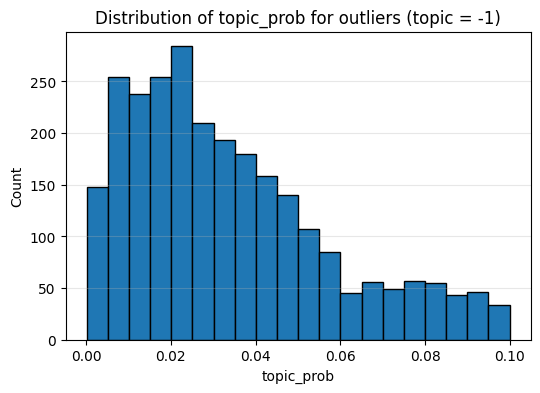

In [305]:
# outliers distributions manual review

# filtering only outliers cluster
mask_outliers = nlp_df_bert_filtered["topic_bertopic"] == -1
probs_outliers = nlp_df_bert_filtered.loc[mask_outliers, "topic_prob"]

print(f"Outlier docs: {mask_outliers.sum()} / {len(nlp_df_bert_filtered)}")
print("\nBasic stats for topic_prob in -1:")
print(probs_outliers.describe())

# looking into quantiles to understand what reassigning treshold to take
print("\nQuantiles:")
for q in [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]:
    print(f"{int(q*100):2d}th: {probs_outliers.quantile(q):.3f}")


plt.figure(figsize=(6, 4))
plt.hist(probs_outliers, bins=20, edgecolor="black")
plt.title("Distribution of topic_prob for outliers (topic = -1)")
plt.xlabel("topic_prob")
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.3)
plt.show()

### Inspecting topic_prob inside topic = -1

We computed a histogram and quantiles of topic_prob for all tickets with topic_bertopic = -1.

Almost all of them have topic_prob < 0.1, and the median is very close to zero.

This means no single topic attracts these documents strongly enough – they are genuinely on the periphery of the topic space.

**Why we don’t reassign all outliers**

Low `topic_prob` here is not a technical artifact, it reflects the fact that a ticket is multi-issue or highly unique.

With code below we manually observed all clusters including outliers cluster and saw that often outliers text consists of very long and multi-topic conversations.

Hypothesis: If we forced all outliers into existing topics (with a high threshold or by ignoring probabilities), we might end up with noisy, hard-to-explain topics, which harms business interpretation.

**Final decision**

Use reduce_outliers only for documents that have a clear enough topic candidate (topic_prob ≥ 0.1).

Keep the remaining documents with topic = -1 as an explicit “multi-issue / rare scenario” layer instead of pretending that they belong to a clean topic.

This way, the main topics stay clean and interpretable, while complex tickets are handled transparently rather than being silently forced into ill-fitting clusters.

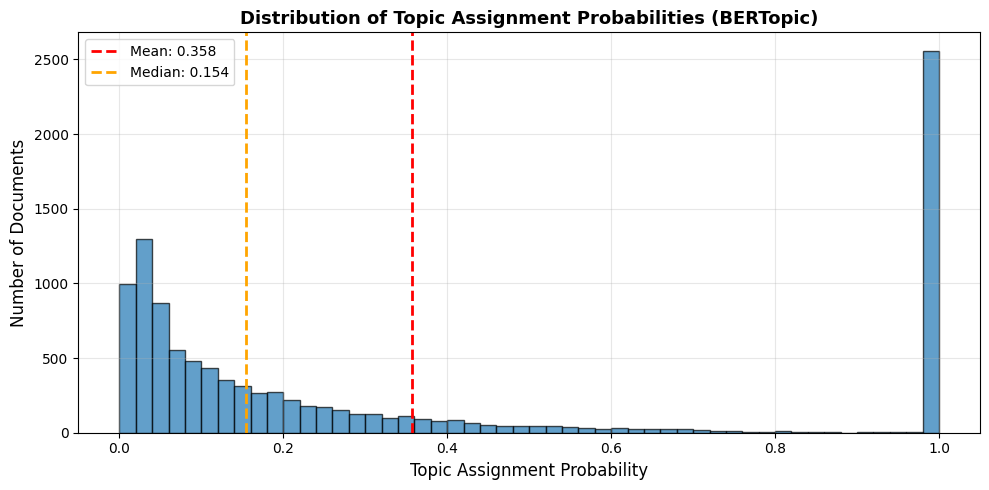


Probability percentiles:
  10th: 0.021
  25th: 0.047
  50th (median): 0.154
  75th: 0.751
  90th: 1.000


In [306]:
# histogram probabilities of all clusters
plt.figure(figsize=(10, 5))
plt.hist(nlp_df_bert_filtered['topic_prob'], bins=50, alpha=0.7, edgecolor='black')
plt.axvline(nlp_df_bert_filtered['topic_prob'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {nlp_df_bert_filtered["topic_prob"].mean():.3f}')
plt.axvline(nlp_df_bert_filtered['topic_prob'].median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {nlp_df_bert_filtered["topic_prob"].median():.3f}')
plt.xlabel('Topic Assignment Probability', fontsize=12)
plt.ylabel('Number of Documents', fontsize=12)
plt.title('Distribution of Topic Assignment Probabilities (BERTopic)', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# percentiles
print("\nProbability percentiles:")
print(f"  10th: {nlp_df_bert_filtered['topic_prob'].quantile(0.1):.3f}")
print(f"  25th: {nlp_df_bert_filtered['topic_prob'].quantile(0.25):.3f}")
print(f"  50th (median): {nlp_df_bert_filtered['topic_prob'].quantile(0.5):.3f}")
print(f"  75th: {nlp_df_bert_filtered['topic_prob'].quantile(0.75):.3f}")
print(f"  90th: {nlp_df_bert_filtered['topic_prob'].quantile(0.9):.3f}")

#### Clustering result interpretation:

Probabilities:
- Mean: 0.358 (35.8%)
- Median: 0.154 (15.4%)
  
HDBSCAN probabilities measure membership strength rather than classical label certainty, so many tickets near topic boundaries naturally receive low scores.
Hypothesis: because of the average length of tickets is ~50-60 tokens and short texts produce less confident embeddings than longer documents.
Also, because sometimes one ticket may cover few topics (server availability + payment, for example), the probability is spread across several topics and results in a lower maximum probability.
Anyways, human-in-the-loop cluster topic verification will be applied.

### Model Evaluation with Embedding-based Topic Coherence

In [307]:
# same model we used in BERTopic
embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

# calculating embeddings for the texts that BERTopic was trained on
emb = embedding_model.encode(
    nlp_df_bert_filtered["text_bert"].tolist(),
    batch_size=64,
    show_progress_bar=True
)
emb = np.array(emb)

Batches:   0%|          | 0/163 [00:00<?, ?it/s]

In [308]:
# to make sure its np.array
topics_arr = np.array(topics_reduced)
emb_arr = np.array(emb)

topic_ids = sorted(t for t in np.unique(topics_arr) if t != -1)
coherences = []

for t in topic_ids:
    idx = np.where(topics_arr == t)[0]   # индексы документов в топике t
    if idx.shape[0] < 2:
        continue
    vecs = emb_arr[idx]
    sim = cosine_similarity(vecs).mean()
    coherences.append(sim)

coherences = np.array(coherences)

print(f"Mean embedding coherence across topics: {coherences.mean():.3f}")
print(f"Median embedding coherence across topics: {np.median(coherences):.3f}")
print(f"Topics used in metric: {len(coherences)}")

Mean embedding coherence across topics: 0.623
Median embedding coherence across topics: 0.622
Topics used in metric: 66


### Embedding-based Topic Coherence

To evaluate semantic consistency within topics, we computed the average pairwise cosine similarity between sentence embeddings of documents belonging to the same topic. Across 66 topics, the mean and median intra-topic cosine similarity are both 0.62, indicating that documents grouped into a topic are semantically close in the embedding space, with no long tail of low-quality topics.

### Manual topic mapping and review

With code below, we manually take a look on tickets examples of each topic to check out it's coherence and assign correct topic name.

In [279]:
# watch manually tickets from a specific topic
def show_bert_examples(topic_id, col="text_bert", n=20, max_len=800):
    subset = nlp_df_bert_filtered.loc[
        nlp_df_bert_filtered["topic_bertopic"] == topic_id, col
    ].dropna()
    print(f"\n=== Topic {topic_id} (session: {len(subset)}) ===")
    for i, text in enumerate(subset.sample(min(n, len(subset)), random_state=42), start=1):
        clean = text.replace("\n", " ")[:max_len]
        print(f"\nExample {i}:")
        print(clean, "..." if len(text) > max_len else "")
        
show_bert_examples(60) # manually looking at every cluster to assign it's topic and check it for coherense 


=== Topic 60 (session: 0) ===


In [314]:
# checking how well model worked with logs over 5000 sybbols:
df_long = nlp_df_bert_filtered[nlp_df_bert_filtered["is_long"]].copy()

df_long["topic_label"] = df_long["topic_bertopic"].map(topic_label_map).fillna("Unknown")
df_long["topic_bertopic"].value_counts().head()

topic_bertopic
-1    96
 0    34
 2    20
 1    18
 5    10
Name: count, dtype: int64

In [309]:
topic_label_map = {
    -1: "Outliers",
     0: "Resource_Upgrades_and_Configuration",
     1: "Server_Locations_and_Geography",
     2: "DDoS_Attacks_and_Traffic_Filtering",
     3: "Network_Connectivity_Issues",
     4: "Additional_IP_Requests_and_Allocation",
     5: "Network_Speed_and_Bandwidth_Limits",
     6: "Brief_Service_Status_Questions",
     7: "Turkmenistan_IP_Blocking_Issues",
     8: "Trial_Period_Requests_and_Denials",
     9: "Password_Reset_and_Authentication_Issues",
    10: "PayPal_Payments_and_Invoices",
    11: "Billing_Logic_and_Refunds",
    12: "SSH_and_Remote_Access_Problems",
    13: "Service_Type_and_Virtualization_Questions",
    14: "Corporate_Invoicing_and_Accounting_Documents",
    15: "Control_Panel_and_Minor_Operational_Issues",
    16: "EDO_Acts_and_Reconciliation_Requests",
    17: "OS_Level_Configuration",
    18: "IPv6_Configuration_and_Subnet_Management",
    19: "Discounts_Promotions_and_Referral_Programs",
    20: "Trial_Requests_and_Test_Activation",
    21: "SMTP_Port25_and_Firewall_Ports",
    22: "Connectivity_Issues_and_IP_Address_Management",
    23: "Abuse_Suspensions_and_Anti_Spam_Policy",
    24: "Windows_VPS_Provisioning_and_Licensing", 
    25: "Renewals_Billing_Dates_and_Service_Suspension", 
    26: "Account_Suspension_and_Deletion",
    27: "Free_Trial_Outreach",
    28: "IP_Reachability_Regions_and_Network_Incidents", 
    29: "Currency_Payment_Methods_and_International_Billing",
    30: "PTR_Reverse_DNS_and_Mail_Server_Setup",
    31: "Trial_Periods_and_Money_Back_Policy",
    32: "VPS_Service_Scope_Use_Cases",
    33: "Domain_DNS_Configuration",
    34: "Mass_Outages_Internal_Errors",
    35: "Account_Ownership_Procedures",
    36: "Custom_ISO_Images_Questions",
    37: "Free_Trial_Questions",
    38: "Yandex_Tests_Autorequests",
    39: "Payments_Delays_and_Service_Grace_Periods",
    40: "Virtualization_Platform_Use_Cases",
    41: "DDoS_Protection_Firewall_Rules",
    42: "Billing_Invoices_Manual_Topups",
    43: "Service_Availability_Maintenance_and_Incident_Communication",
    44: "VPN_Usage_Troubleshooting",
    45: "YooMoney_Topups_Issues",
    46: "Account_Activation_Test_Request_Form_and_Trial_Restrictions",
    47: "MikroTik_CHR_Internal_Networks",
    48: "WebMoney_Payments_Requests",
    49: "Test_Period_Usage_Limits_and_Prohibited_Workloads",
    50: "Email_communication_Requests",
    51: "IP_Address_Management_Geolocation_and_DNS_Changes",
    52: "Linux_VPS_Access_SSH_SCP_and_Basic_User_Onboarding",
    53: "General_Billing_Long_Term_Payments_and_Accounting_Documents",
    54: "Incidents_Outages_Backups_and_Compensation",
    55: "Tariff_Changes_Resource_Upgrades",
    56: "DDoS_and_Connectivity_Troubleshooting",
    57: "Spam_And_Free_Requests",
    58: "SSL_TSL_Certificates_Requests",
    59: "MySQL_Connection_Issues",
    60: "Gaming_Servers_Deny_Requests",
    61: "Licensing_and_Software_Activation",
    62: "Server_Management_and_Resource_Operations",
    63: "Free_Servers_Spam_Requests",
    64: "Contracts_Accounting_Billing",
    65: "Network_Storage_Backups_and_CephFS"
}

### Merging Semantically Similar Clusters

#### Why does BERTopic create similar-looking clusters?

BERTopic uses **HDBSCAN** for clustering, which identifies dense regions in embedding space based on local density patterns. While this approach is powerful for discovering natural groupings, it can create fragmentation when:

1. **Linguistic variation exists within one business topic**  
   Example: "trial request", "test period activation", "free trial question" are lexically different but semantically belong to the same category.

2. **Minor contextual differences trigger separate clusters**  
   Payment-related tickets mentioning different payment systems (PayPal, WebMoney, YooMoney) may form distinct clusters despite addressing the same business process.

3. **High dimensionality and sensitivity to parameters**  
   Small variations in `min_cluster_size` and `min_samples` can split naturally cohesive topics into multiple technical clusters.

We tested model with different hyperparameter and had to do manual check of given cluster every time. We desided to stop on a given approach because it gives us more specific view for a large categories such as Payment Isses (for example, there are clusters with different payment methods questions) because we decide it is more important for answering specific business questions: many topics are exceptable here but often business may need a closer look and more detailed approach into topic, for example, which payment method caused a problem or what are most common network issues. However, manual merge of some topics before meta mapping it to a bigger meta cluster is needed:

### Manual merge before meta-mapping

We perform **human-in-the-loop cluster consolidation** to:

- **Reduce redundancy**: Merge clusters that represent the same business intent (e.g., all trial-related requests → one cluster)
- **Improve interpretability**: Business stakeholders need ~15-25 actionable categories, not 60+ micro-clusters
- **Separate technical granularity from business logic**: BERTopic provides technical clustering; we add domain expertise

**Merge strategy:**
- Manually identify clusters with huge semantic overlap and reassign label (number)
- We do not use `topic_model.merge_topics()` to consolidate embeddings and recalculate c-TF-IDF representations because it will distort models geometry and potentially create even more outliers (we did it on a previous run)

In [334]:
# === MANUAL MERGE (NO MODEL CHANGES) ===

# Step 1: Copy original topic IDs (to avoid losing the source files)
nlp_df_bert_filtered["topic_original"] = nlp_df_bert_filtered["topic_bertopic"].copy()

# Step 2: Define merge mapping
# Format: old_ID → base_ID (to which we are adding)
manual_merge_map = {
    # Trial/Test - merge to 8
    20: 8,   # Trial_Requests_and_Test_Activation → Trial_Period_Requests_and_Denials
    37: 8,   # Free_Trial_Questions → Trial_Period_Requests_and_Denials
    46: 8,   # Account_Activation_Test_Request_Form → Trial_Period_Requests_and_Denials
    31: 8,   # Trial_Periods_and_Money_Back_Policy → Trial_Period_Requests_and_Denials
    
    # Payment Systems - merge to 10
    45: 10,  # YooMoney_Topups → PayPal_Payments_and_Invoices
    48: 10,  # WebMoney_Payments → PayPal_Payments_and_Invoices
    
    # Invoicing/Accounting - merge to 14
    42: 14,  # Billing_Invoices_Manual_Topups → Corporate_Invoicing
    53: 14,  # General_Billing_Long_Term_Payments → Corporate_Invoicing
    64: 14,  # Contracts_Accounting_Billing → Corporate_Invoicing
    
    # Billing Logic - merge to 11
    25: 11,  # Renewals_Billing_Dates → Billing_Logic_and_Refunds
    39: 11,  # Payments_Delays → Billing_Logic_and_Refunds
    
    # Spam/Noise - merge to 38
    57: 38,  # Spam_And_Free_Requests → Yandex_Tests_Autorequests
    63: 38,  # Free_Servers_Spam_Requests → Yandex_Tests_Autorequests
    
    # DDoS - merge to 2
    41: 2,   # DDoS_Protection_Firewall_Rules → DDoS_Attacks_and_Traffic_Filtering
    56: 2,   # DDoS_and_Connectivity_Troubleshooting → DDoS_Attacks_and_Traffic_Filtering
    
    # Resource Upgrades - merge to 0
    55: 0,   # Tariff_Changes_Resource_Upgrades → Resource_Upgrades_and_Configuration
    
    # Incidents/Outages - merge to 34
    43: 34,  # Service_Availability_Maintenance → Mass_Outages_Internal_Errors
    54: 34,  # Incidents_Outages_Backups → Mass_Outages_Internal_Errors

    # Connectivity Issues - merge to 3
    22: 3,   # Connectivity_Issues_and_IP_Address_Management → Network_Connectivity_Issues
    
    # Mail Server Infrastructure - merge to 21
    30: 21,  # PTR_Reverse_DNS_and_Mail_Server_Setup → SMTP_Port25_and_Firewall_Ports
    
    # IP Management - merge to 4
    51: 4,   # IP_Address_Management_Geolocation_and_DNS_Changes → Additional_IP_Requests_and_Allocation
}

# Step 3: Apply merge
nlp_df_bert_filtered["topic_merged"] = nlp_df_bert_filtered["topic_original"].replace(manual_merge_map)

# Step 4: Check
print("=== BEFORE MERGE ===")
print(f"Unique topics: {nlp_df_bert_filtered['topic_original'].nunique()}")

print("\n=== AFTER MERGE ===")
print(f"Unique topics: {nlp_df_bert_filtered['topic_merged'].nunique()}")

print("\n=== TOP 20 MERGED TOPICS ===")
print(nlp_df_bert_filtered["topic_merged"].value_counts().head(20))

=== BEFORE MERGE ===
Unique topics: 67

=== AFTER MERGE ===
Unique topics: 46

=== TOP 20 MERGED TOPICS ===
topic_merged
-1     2635
 0      693
 1      609
 8      549
 3      495
 2      478
 11     382
 4      358
 14     345
 10     286
 5      260
 6      241
 7      214
 9      190
 34     179
 21     170
 13     141
 12     140
 38     140
 15     130
Name: count, dtype: int64


In [335]:
# 1. Original topic labels (все 66 тем с исходными названиями)
nlp_df_bert_filtered["topic_label_original"] = nlp_df_bert_filtered["topic_original"].map(topic_label_map)

# 2. Merged topic labels (49 topics, updated names for basic)
topic_label_map_merged = topic_label_map.copy()

# Update ONLY base topics (кwho got new neighbors)
topic_label_map_merged[8] = "Trial_and_Test_Requests"
topic_label_map_merged[10] = "Payment_Systems_and_Topups"
topic_label_map_merged[14] = "Invoicing_and_Accounting"
topic_label_map_merged[11] = "Billing_Logic_and_Renewals"
topic_label_map_merged[38] = "Spam_and_Noise"
topic_label_map_merged[2] = "DDoS_Protection_and_Mitigation"
topic_label_map_merged[0] = "Resource_and_Tariff_Upgrades"
topic_label_map_merged[34] = "Service_Incidents_and_Outages"
topic_label_map_merged[3] = "Network_Connectivity_and_IP_Management"
topic_label_map_merged[21] = "Mail_Server_Infrastructure_SMTP_and_PTR"
topic_label_map_merged[4] = "IP_Allocation_and_Geolocation_Management"

# Apply merged labels
nlp_df_bert_filtered["topic_label_merged"] = nlp_df_bert_filtered["topic_merged"].map(topic_label_map_merged)

print(nlp_df_bert_filtered["topic_label_merged"].value_counts().head(20))

topic_label_merged
Outliers                                      2635
Resource_and_Tariff_Upgrades                   693
Server_Locations_and_Geography                 609
Trial_and_Test_Requests                        549
Network_Connectivity_and_IP_Management         495
DDoS_Protection_and_Mitigation                 478
Billing_Logic_and_Renewals                     382
IP_Allocation_and_Geolocation_Management       358
Invoicing_and_Accounting                       345
Payment_Systems_and_Topups                     286
Network_Speed_and_Bandwidth_Limits             260
Brief_Service_Status_Questions                 241
Turkmenistan_IP_Blocking_Issues                214
Password_Reset_and_Authentication_Issues       190
Service_Incidents_and_Outages                  179
Mail_Server_Infrastructure_SMTP_and_PTR        170
Service_Type_and_Virtualization_Questions      141
SSH_and_Remote_Access_Problems                 140
Spam_and_Noise                                 140
Control_Pane

### Meta Clustering for interpretation and business needs

In [336]:
# === META-CLUSTER MAPPING ===
meta_cluster_map = {
    # === 1. Billing & Payments ===
    "Billing_Logic_and_Renewals": "Billing_and_Payments",
    "Payment_Systems_and_Topups": "Billing_and_Payments",
    "Invoicing_and_Accounting": "Billing_and_Payments",
    "Currency_Payment_Methods_and_International_Billing": "Billing_and_Payments",
    "EDO_Acts_and_Reconciliation_Requests": "Billing_and_Payments",
    "Discounts_Promotions_and_Referral_Programs": "Billing_and_Payments",
    
    # === 2. Network, IP, DNS, Ports ===
    "Network_Connectivity_Issues": "Network_IP_DNS_Ports",
    "Additional_IP_Requests_and_Allocation": "Network_IP_DNS_Ports",
    "Network_Speed_and_Bandwidth_Limits": "Network_IP_DNS_Ports",
    "Connectivity_Issues_and_IP_Address_Management": "Network_IP_DNS_Ports",
    "IPv6_Configuration_and_Subnet_Management": "Network_IP_DNS_Ports",
    "IP_Reachability_Regions_and_Network_Incidents": "Network_IP_DNS_Ports",
    "PTR_Reverse_DNS_and_Mail_Server_Setup": "Network_IP_DNS_Ports",
    "Domain_DNS_Configuration": "Network_IP_DNS_Ports",
    "SSH_and_Remote_Access_Problems": "Network_IP_DNS_Ports",
    "SMTP_Port25_and_Firewall_Ports": "Network_IP_DNS_Ports",
    "IP_Address_Management_Geolocation_and_DNS_Changes": "Network_IP_DNS_Ports",
    
    # === 3. Incidents, DDoS, Outages ===
    "DDoS_Protection_and_Mitigation": "Incidents_DDoS_Outages",
    "Service_Incidents_and_Outages": "Incidents_DDoS_Outages",
    "Brief_Service_Status_Questions": "Incidents_DDoS_Outages",
    
    # === 4. Access, Auth, Accounts ===
    "Password_Reset_and_Authentication_Issues": "Access_Auth_Accounts",
    "Account_Ownership_Procedures": "Access_Auth_Accounts",
    "Account_Suspension_and_Deletion": "Access_Auth_Accounts",
    
    # === 5. Policy, Restrictions, Abuse ===
    "Abuse_Suspensions_and_Anti_Spam_Policy": "Policy_Restrictions_and_Abuse",
    "Turkmenistan_IP_Blocking_Issues": "Policy_Restrictions_and_Abuse",
    "Test_Period_Usage_Limits_and_Prohibited_Workloads": "Policy_Restrictions_and_Abuse",
    "Gaming_Servers_Deny_Requests": "Policy_Restrictions_and_Abuse",
    
    # === 6. Platform & Virtualization ===
    "Service_Type_and_Virtualization_Questions": "Platform_and_Virtualization",
    "Virtualization_Platform_Use_Cases": "Platform_and_Virtualization",
    "Control_Panel_and_Minor_Operational_Issues": "Platform_and_Virtualization",
    "VPN_Usage_Troubleshooting": "Platform_and_Virtualization",
    
    # === 7. OS, Software, Databases ===
    "OS_Level_Configuration": "OS_Software_and_Databases",
    "Windows_VPS_Provisioning_and_Licensing": "OS_Software_and_Databases",
    "Custom_ISO_Images_Questions": "OS_Software_and_Databases",
    "MikroTik_CHR_Internal_Networks": "OS_Software_and_Databases",
    "MySQL_Connection_Issues": "OS_Software_and_Databases",
    "SSL_TSL_Certificates_Requests": "OS_Software_and_Databases",
    "Licensing_and_Software_Activation": "OS_Software_and_Databases",
    
    # === 8. Server Operations & Resources (+ Trial) ===
    "Resource_and_Tariff_Upgrades": "Server_Operations_and_Resources",
    "Server_Locations_and_Geography": "Server_Operations_and_Resources",
    "VPS_Service_Scope_Use_Cases": "Server_Operations_and_Resources",
    "Trial_and_Test_Requests": "Server_Operations_and_Resources",
    "Free_Trial_Outreach": "Server_Operations_and_Resources",
    "Server_Management_and_Resource_Operations": "Server_Operations_and_Resources",
    "Linux_VPS_Access_SSH_SCP_and_Basic_User_Onboarding": "Server_Operations_and_Resources",
    
    # === 9. Noise & Outliers ===
    "Spam_and_Noise": "Noise_and_Outliers",
    "Outliers": "Noise_and_Outliers",
    "Email_communication_Requests": "Noise_and_Outliers",
    "Yandex_Tests_Autorequests": "Noise_and_Outliers",
}

# Apply meta-clusters
nlp_df_bert_filtered["meta_cluster"] = nlp_df_bert_filtered["topic_label_merged"].map(meta_cluster_map)

print("\n=== META-CLUSTER DISTRIBUTION ===")
print(nlp_df_bert_filtered["meta_cluster"].value_counts())


=== META-CLUSTER DISTRIBUTION ===
meta_cluster
Noise_and_Outliers                 2829
Server_Operations_and_Resources    2080
Billing_and_Payments               1337
Incidents_DDoS_Outages              898
Network_IP_DNS_Ports                658
OS_Software_and_Databases           427
Policy_Restrictions_and_Abuse       418
Platform_and_Virtualization         381
Access_Auth_Accounts                343
Name: count, dtype: int64


### Multi-Level Topic Granularity for Business Analysis

#### Three-tier structure

Our clustering approach maintains **three levels of granularity**:

1. **Micro-topics** (66 original clusters): Fine-grained themes identified by BERTopic (e.g., "PayPal_Payments", "YooMoney_Topups", "WebMoney_Payments")
2. **Consolidated topics** (49 clusters): Semantically duplicate clusters merged via manual mapping (e.g., all payment systems → "Payment_Systems_and_Topups")
3. **Meta-clusters** (8 categories): High-level business domains (e.g., "Billing_and_Payments", "Network_IP_DNS_Ports")

#### Business value

**Executive reporting**: Meta-clusters provide actionable insights for leadership (e.g., "30% of support volume is network-related")

**Operational planning**: Consolidated topics help allocate resources and identify training needs (e.g., "DDoS protection requests tripled in 2024")

**Root cause analysis**: Micro-topics enable drill-down investigations (e.g., "Payment issues increased due to YooMoney API changes, not PayPal")

This granular approach balances **strategic overview** with **actionable detail**, enabling both high-level trend monitoring and targeted problem-solving.

96 out of 337 (approx. 28%) of very long tickets went into outliers, the rest of the tickets were clustered. We believe that this gives us enough information already and do not see a nesseserety to dig into this long logs or ourliers separately

## [Topic Modeling Interpretation](#topic-modeling-interpretation)

Here we are going to do an overview of metacluster and explore how distribution changed historically and for the past few years to answer our business questions and find some insights. We will also deep dive into each metacluster to overview more specific topics and follow it with visualizations and comments.

### Distribution of meta-themes: entire period vs. 2022–2025

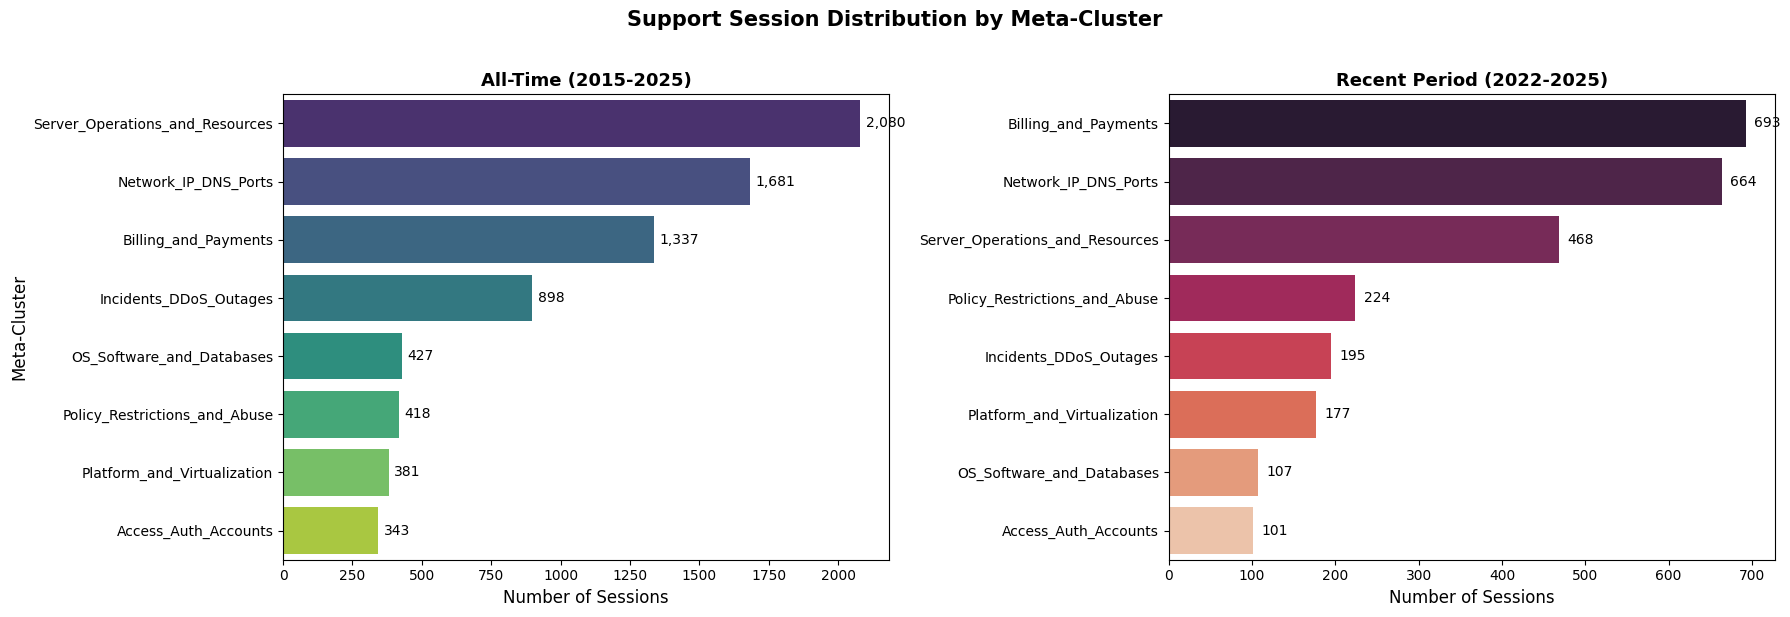

In [316]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
# All-time
all_time = nlp_df_bert_filtered[
    nlp_df_bert_filtered["meta_cluster"] != "Noise_and_Outliers"
]["meta_cluster"].value_counts()

# 2022-2025
recent = nlp_df_bert_filtered[
    (nlp_df_bert_filtered["year"] >= 2022) & 
    (nlp_df_bert_filtered["meta_cluster"] != "Noise_and_Outliers")
]["meta_cluster"].value_counts()

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: All-time
sns.barplot(y=all_time.index, x=all_time.values, palette="viridis", orient='h', ax=ax1)
ax1.set_xlabel("Number of Sessions", fontsize=12)
ax1.set_ylabel("Meta-Cluster", fontsize=12)
ax1.set_title("All-Time (2015-2025)", fontsize=13, fontweight='bold')

# Add count labels
for i, v in enumerate(all_time.values):
    ax1.text(v + 20, i, f'{v:,}', va='center', fontsize=10)

# Plot 2: 2022-2025
sns.barplot(y=recent.index, x=recent.values, palette="rocket", orient='h', ax=ax2)
ax2.set_xlabel("Number of Sessions", fontsize=12)
ax2.set_ylabel("")  # Remove y-label for cleaner look
ax2.set_title("Recent Period (2022-2025)", fontsize=13, fontweight='bold')

# Add count labels
for i, v in enumerate(recent.values):
    ax2.text(v + 10, i, f'{v:,}', va='center', fontsize=10)

plt.suptitle("Support Session Distribution by Meta-Cluster", 
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

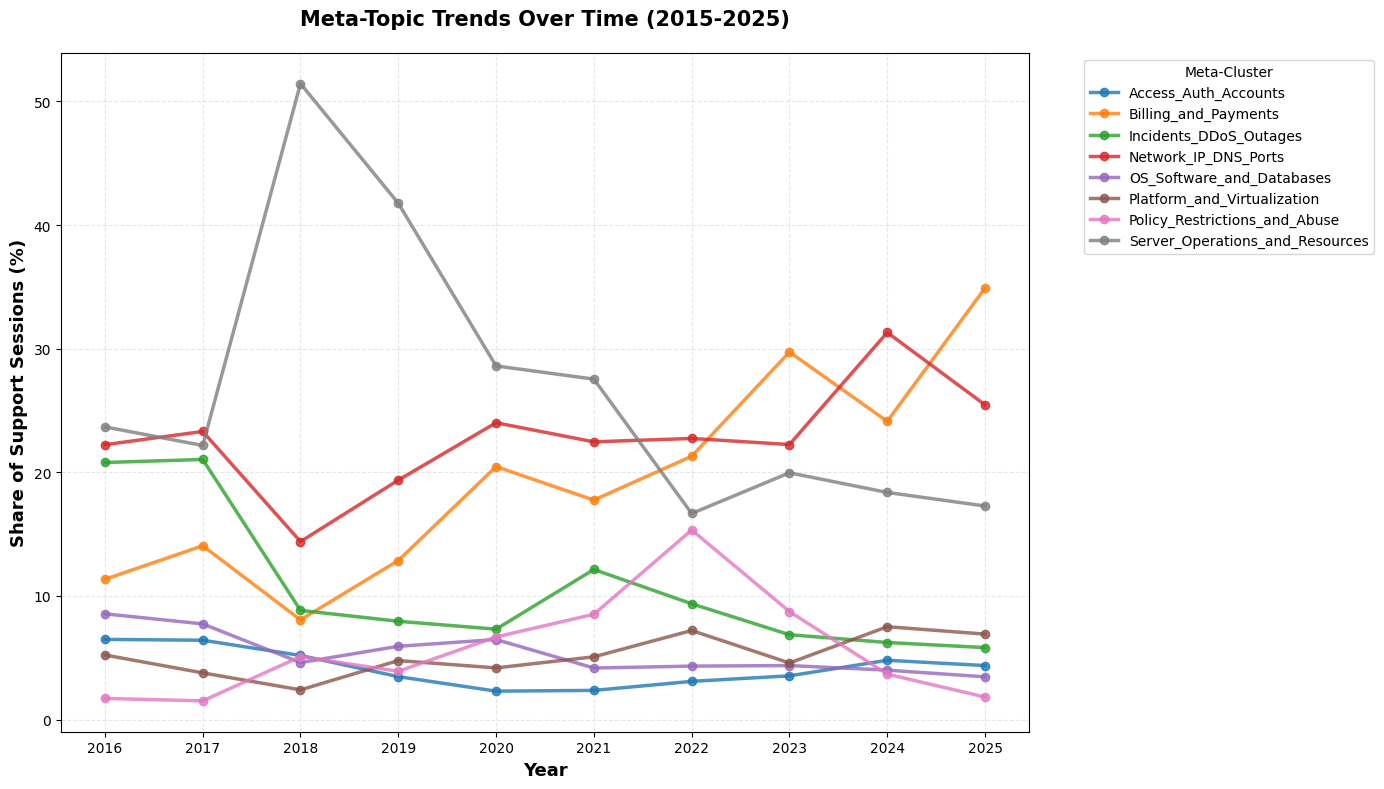

In [321]:
# exploring meta cluster trends over years

# prepare data
temporal = nlp_df_bert_filtered[
    nlp_df_bert_filtered["meta_cluster"] != "Noise_and_Outliers"
].groupby(['year', 'meta_cluster']).size().unstack(fill_value=0)

# normalize to percentages
temporal_pct = temporal.div(temporal.sum(axis=1), axis=0) * 100

# plot line chart
fig, ax = plt.subplots(figsize=(14, 8))

# plot each meta-cluster as a line
for col in temporal_pct.columns:
    ax.plot(temporal_pct.index, temporal_pct[col], 
            marker='o', linewidth=2.5, label=col, alpha=0.8)

ax.set_xlabel("Year", fontsize=13, fontweight='bold')
ax.set_ylabel("Share of Support Sessions (%)", fontsize=13, fontweight='bold')
ax.set_title("Meta-Topic Trends Over Time (2015-2025)", 
             fontsize=15, fontweight='bold', pad=20)
ax.legend(title='Meta-Cluster', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xticks(temporal_pct.index)

plt.tight_layout()
plt.show()

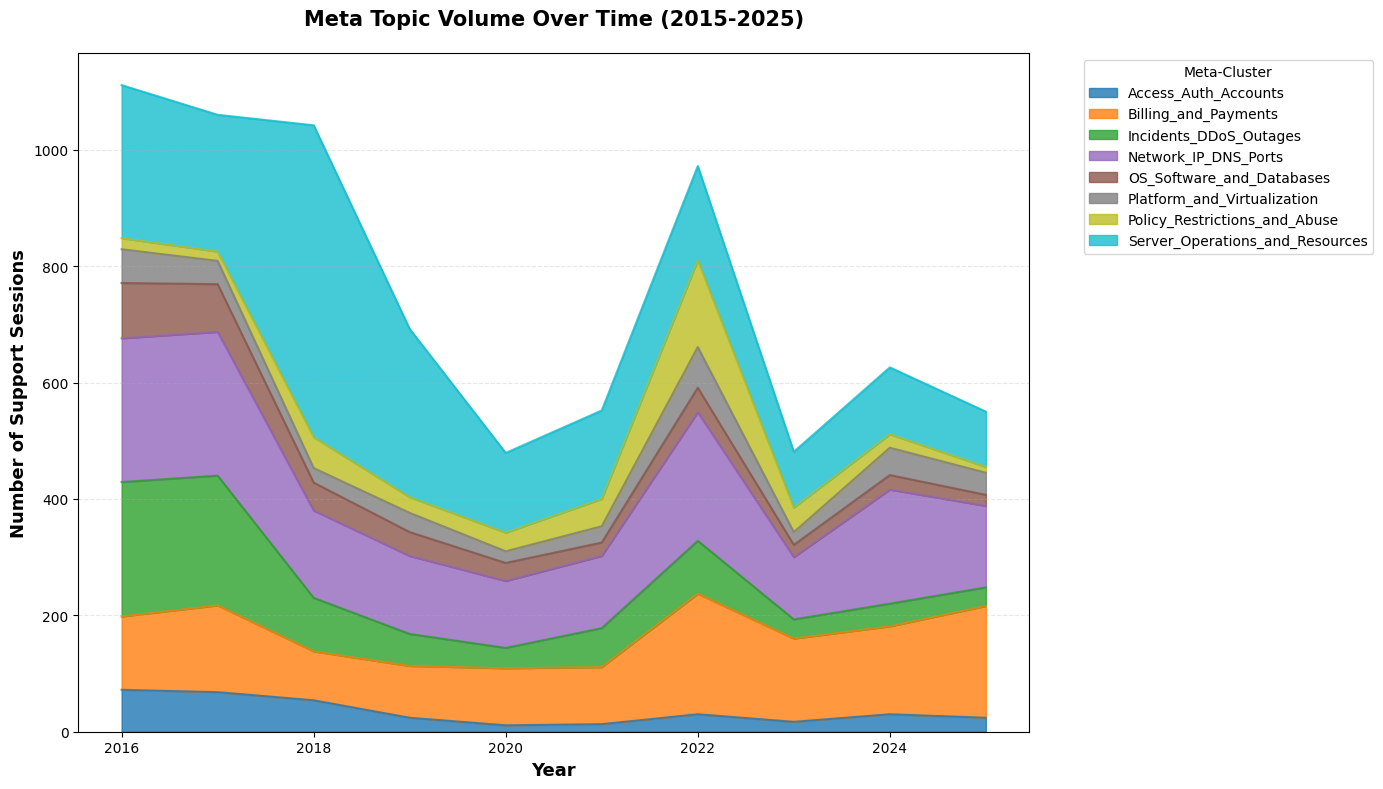

In [324]:
# volume over a time
temporal_abs = nlp_df_bert_filtered[
    nlp_df_bert_filtered["meta_cluster"] != "Noise_and_Outliers"
].groupby(['year', 'meta_cluster']).size().unstack(fill_value=0)

# plot stacked area
fig, ax = plt.subplots(figsize=(14, 8))

temporal_abs.plot(
    kind='area',
    stacked=True,
    ax=ax,
    alpha=0.8,
    cmap='tab10'
)

ax.set_xlabel("Year", fontsize=13, fontweight='bold')
ax.set_ylabel("Number of Support Sessions", fontsize=13, fontweight='bold')
ax.set_title("Meta Topic Volume Over Time (2015-2025)", 
             fontsize=15, fontweight='bold', pad=20)
ax.legend(title='Meta-Cluster', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

### Temporal Analysis: Meta-Cluster Trends (2016-2025)

The temporal analysis reveals several distinct phases in support ticket composition, directly correlated with business strategy shifts and external events.

#### Key Observations

**Server Operations and Resources** dominated early years (52% in 2018), driven primarily by **trial period requests** during active customer acquisition. The sharp decline post-2019 reflects the company's strategic pivot away from free trial offerings, stabilizing at ~17% by 2022-2025.

**Billing and Payments** shows the most dramatic recent growth, rising from ~11% (2016) to **35% in 2025**. This trend intensified after 2022, coinciding with:
- Russia-Ukraine conflict and associated payment sanctions
- Strategic shift toward European markets
- Payment gateway complications (particularly YooMoney, WebMoney restrictions)
- Increased complexity in cross-border invoicing and compliance (EDO requirements)

**Policy Restrictions and Abuse** spiked dramatically in **2022 (15%)**, then declined. This spike aligns with geopolitical sanctions enforcement, regional IP blocking (Turkmenistan, restricted territories), and heightened abuse monitoring during market transition.

**Incidents, DDoS, and Outages** exhibits a clear maturation curve:
- **2016-2017**: High baseline (~21%) during initial infrastructure buildout
- **2018-2020**: Decline to ~7% following BGP hardening and DDoS mitigation deployment
- **2021**: Secondary spike (~12%) due to new datacenter launch and infrastructure expansion
- **2022-2025**: Stabilization (~5-6%) reflecting mature protection architecture

**Network IP DNS Ports** remains consistently prominent (22-31%), with slight growth in 2024-2025 as the service matures and customers deploy more complex configurations (IPv6, custom DNS setups).

### Volume Dynamics

Absolute ticket volume (lower chart) shows:
- **2018 peak** (~1,150 sessions): Trial program at maximum reach + infrastructure scaling challenges
- **2020 trough** (~480 sessions): COVID-19 business contraction
- **2022 spike** (~950 sessions): New datacenter opening + geopolitical disruption
- **2023-2025 stabilization** (~550-600 sessions): Mature operations with European market focus

The declining total volume post-2018, despite business growth, suggests **improved operational efficiency**: better documentation, infrastructure stability, and reduced trial-driven noise.


## Billing and Payments

Billing and Payments emerged as the **fastest-growing meta-cluster**, rising from 11% (2016) to **35% in 2025**. This dramatic shift reflects fundamental changes in the company's operational environment following geopolitical disruptions and strategic market repositioning. Here we do a deep dive into this cluster and connect its distribution with business needs


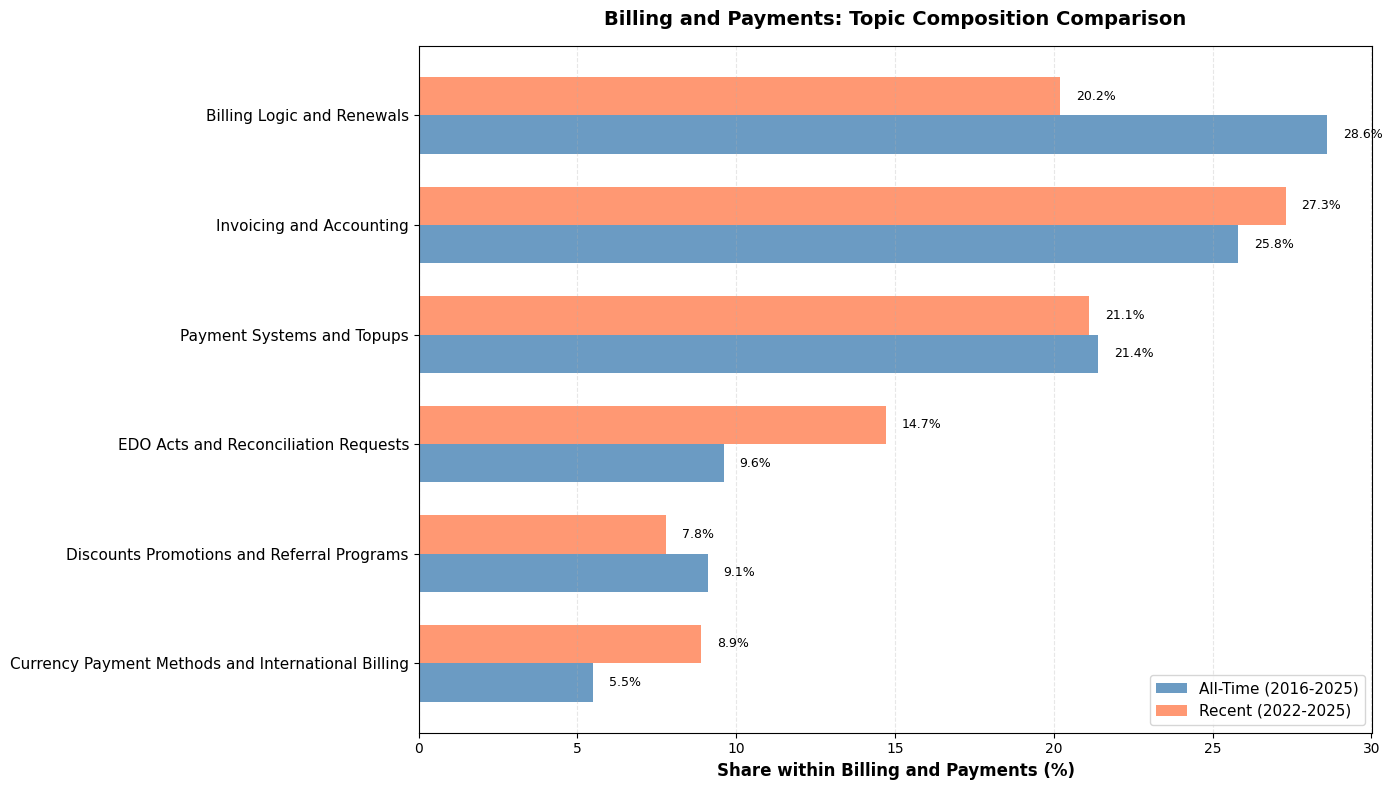

In [341]:
# overview on payment and billing requests in support chats

# Prepare data
billing_data = nlp_df_bert_filtered[
    nlp_df_bert_filtered["meta_cluster"] == "Billing_and_Payments"
].copy()

# Count topics for each period
alltime_counts = billing_data["topic_label_merged"].value_counts()
recent_counts = billing_data[billing_data["year"] >= 2022]["topic_label_merged"].value_counts()

# Normalize to percentages
alltime_pct = (alltime_counts / alltime_counts.sum() * 100).round(1)
recent_pct = (recent_counts / recent_counts.sum() * 100).round(1)

# Combine
comparison_df = pd.DataFrame({
    'All-Time (2016-2025)': alltime_pct,
    'Recent (2022-2025)': recent_pct
}).fillna(0)

# Clean labels
comparison_df.index = comparison_df.index.str.replace('_', ' ')

# Sort by all-time percentage
comparison_df = comparison_df.sort_values('All-Time (2015-2025)', ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(14, 8))

x = range(len(comparison_df))
width = 0.35

bars1 = ax.barh([i - width/2 for i in x], comparison_df['All-Time (2016-2025)'], 
                width, label='All-Time (2016-2025)', color='steelblue', alpha=0.8)
bars2 = ax.barh([i + width/2 for i in x], comparison_df['Recent (2022-2025)'], 
                width, label='Recent (2022-2025)', color='coral', alpha=0.8)

ax.set_yticks(x)
ax.set_yticklabels(comparison_df.index, fontsize=11)
ax.set_xlabel("Share within Billing and Payments (%)", fontsize=12, fontweight='bold')
ax.set_title("Billing and Payments: Topic Composition Comparison", 
             fontsize=14, fontweight='bold', pad=15)
ax.legend(fontsize=11, loc='lower right')
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Add percentage labels
for bars in [bars1, bars2]:
    for bar in bars:
        width_val = bar.get_width()
        if width_val > 0:
            ax.text(width_val + 0.5, bar.get_y() + bar.get_height()/2, 
                   f'{width_val:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()

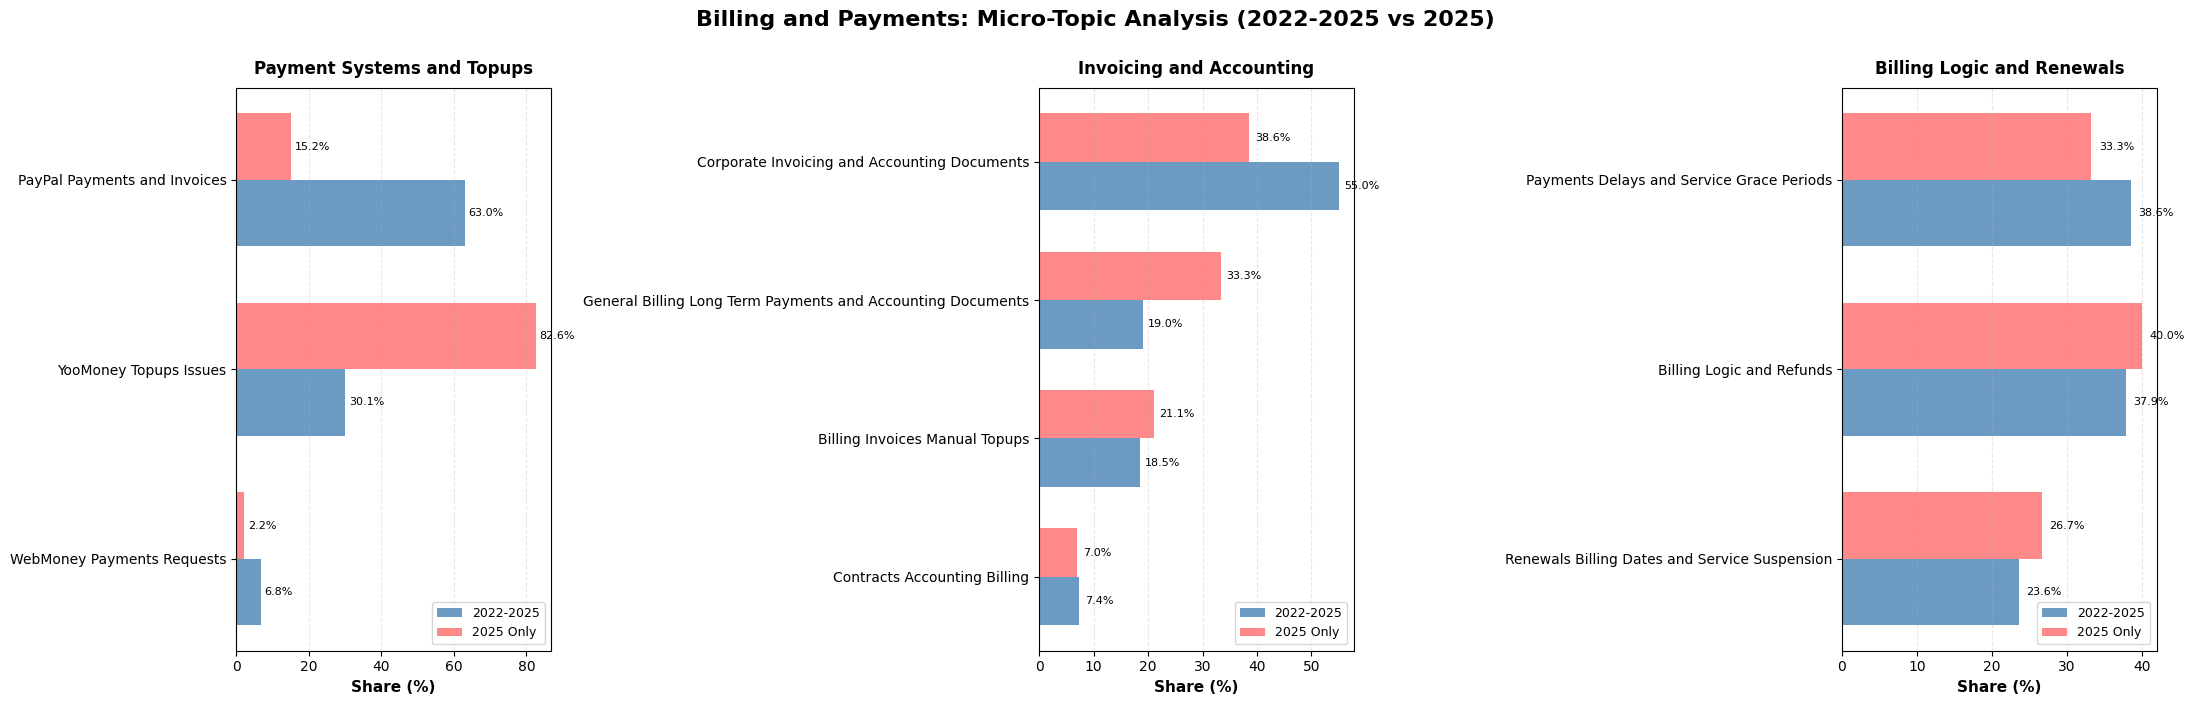

In [329]:
import matplotlib.pyplot as plt
import pandas as pd

# ===== FUNCTION TO PREPARE DATA =====
def prepare_topic_comparison(topic_label_merged_name):
    """
    Prepare comparison data for a given consolidated topic
    Returns: DataFrame with percentages for 2022-2025 vs 2025
    """
    # Filter data
    topic_data = nlp_df_bert_filtered[
        nlp_df_bert_filtered["topic_label_merged"] == topic_label_merged_name
    ].copy()
    
    # Get original topics for both periods
    counts_2022_2025 = topic_data[
        topic_data["year"] >= 2022
    ]["topic_original"].value_counts()
    
    counts_2025 = topic_data[
        topic_data["year"] == 2025
    ]["topic_original"].value_counts()
    
    # Map to labels
    counts_2022_2025_labeled = counts_2022_2025.copy()
    counts_2022_2025_labeled.index = counts_2022_2025_labeled.index.map(
        lambda x: topic_label_map.get(x, f"Topic {x}")
    )
    
    counts_2025_labeled = counts_2025.copy()
    counts_2025_labeled.index = counts_2025_labeled.index.map(
        lambda x: topic_label_map.get(x, f"Topic {x}")
    )
    
    # Normalize to percentages
    pct_2022_2025 = (counts_2022_2025_labeled / counts_2022_2025_labeled.sum() * 100).round(1)
    pct_2025 = (counts_2025_labeled / counts_2025_labeled.sum() * 100).round(1)
    
    # Combine
    comparison_df = pd.DataFrame({
        '2022-2025': pct_2022_2025,
        '2025 Only': pct_2025
    }).fillna(0).sort_values('2022-2025', ascending=True)
    
    # Clean labels
    comparison_df.index = comparison_df.index.str.replace('_', ' ')
    
    return comparison_df

# ===== PREPARE DATA FOR ALL THREE TOPICS =====
payment_systems = prepare_topic_comparison("Payment_Systems_and_Topups")
invoicing = prepare_topic_comparison("Invoicing_and_Accounting")
billing_logic = prepare_topic_comparison("Billing_Logic_and_Renewals")

# ===== CREATE FIGURE WITH 3 SUBPLOTS =====
fig, axes = plt.subplots(1, 3, figsize=(22, 7))

topics_data = [
    (payment_systems, "Payment Systems and Topups", axes[0]),
    (invoicing, "Invoicing and Accounting", axes[1]),
    (billing_logic, "Billing Logic and Renewals", axes[2])
]

width = 0.35

# Plot each subplot
for data, title, ax in topics_data:
    x = range(len(data))
    
    bars1 = ax.barh([i - width/2 for i in x], data['2022-2025'], 
                    width, label='2022-2025', color='steelblue', alpha=0.8)
    bars2 = ax.barh([i + width/2 for i in x], data['2025 Only'], 
                    width, label='2025 Only', color='#FF6B6B', alpha=0.8)
    
    ax.set_yticks(x)
    ax.set_yticklabels(data.index, fontsize=10)
    ax.set_xlabel("Share (%)", fontsize=11, fontweight='bold')
    ax.set_title(title, fontsize=12, fontweight='bold', pad=10)
    ax.legend(fontsize=9, loc='lower right')
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add percentage labels
    for bars in [bars1, bars2]:
        for bar in bars:
            width_val = bar.get_width()
            if width_val > 1:  # Only show labels > 1%
                ax.text(width_val + 1, bar.get_y() + bar.get_height()/2, 
                       f'{width_val:.1f}%', va='center', fontsize=8)

plt.suptitle("Billing and Payments: Micro-Topic Analysis (2022-2025 vs 2025)", 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## Billing and Payments insigths:

#### Consolidated Topic Composition

The meta-cluster comprises six distinct consolidated topics, with three dominating support volume:

**1. Billing Logic and Renewals** (28.6% all-time, 20.3% recent)
- Most consistent category across all periods
- Represents core subscription management challenges
- Relative decline suggests improved automation or customer understanding

**2. Invoicing and Accounting** (25.8% all-time, 27.4% recent)
- Steady growth, now the largest component
- Driven by corporate compliance requirements
- EDO (electronic document exchange) adoption increased regulatory complexity

**3. Payment Systems and Topups** (21.4% all-time, 21.2% recent)
- Stable share but transformed composition internally
- Critical growth driver post-2022 due to sanctions

**Secondary categories:**
- **EDO Acts and Reconciliation** (9.6% → 14.8%): Growing compliance burden for corporate clients on post-soviet areas
- **Discounts and Promotions** (9.0% → 7.8%): Declining as company matures
- **Currency and International Billing** (5.5% → 9.0%): Increased cross-border complexity

---

### Micro-Topic Analysis: Payment Gateway Crisis

Drilling down to original topics reveals **critical infrastructure dependencies** that shifted dramatically in 2025:

#### Payment Systems and Topups (66 → 146 sessions, 2022-2025)

**YooMoney dominance intensifies:**
- **2022-2025**: 30.1% of payment issues
- **2025**: **82.6%** of payment issues (hypothesis to check: it's mostly connected with payment provider issues and their blocking accounts policy)
- Reflects near-total reliance on YooMoney after international gateway restrictions

**PayPal collapse:**
- **2022-2025**: 63.0% of payment issues
- **2025**: **15.2%** (78% decline in relative share)
- Service restrictions for Russian entities drove customer migration, 2025 PayPal tickets conected with internashional clients.

**WebMoney obsolescence:**
- **2022-2025**: 6.8%
- **2025**: 2.2% (marginal usage)

**Business Impact:** Most of the current payment processors tickets connected with Russian payment provider YouMoney which may need a further investigation or looking for alternatives for clients on this area. 

---

#### Invoicing and Accounting (345 → 189 sessions)

**Corporate invoicing stabilizes:**
- **Corporate Invoicing and Accounting**: 54.0% → 38.6% (volume stable, share normalized)
- **General Billing/Long-term Payments**: 19.0% → 33.3% (growing complexity for annual contracts)
- **Manual Topup Invoices**: 18.5% → 21.1% (persistent manual processes)
- **Contracts/Accounting Billing**: 7.4% → 7.0% (stable niche)

**Key Insight:** The shift from corporate invoicing dominance toward diversified accounting concerns suggests customers now require support across multiple billing touchpoints (contracts, long-term agreements, manual processes), rather than simple invoice generation.

---

#### Billing Logic and Renewals (382 → 140 sessions)

**Payment delays emerge as primary concern:**
- **Payments Delays and Grace Periods**: 38.3% → **33.3%** in 2025
- Likely driven by payment gateway instability (YooMoney processing delays)

**Core billing logic stabilizes:**
- **Billing Logic and Refunds**: 37.2% → **40.0%** (consistent baseline)
- Represents fundamental customer confusion about subscription mechanics

**Renewals complexity grows:**
- **Renewals, Billing Dates, Suspension**: 23.6% → **26.7%**
- Auto-renewal failures may correlate with payment gateway issues

---

### Strategic Implications

#### Immediate Risks (2025)
1. **Payment Gateway Concentration**: 83% reliance on YooMoney creates single point of failure
2. **Service Continuity**: Payment delays (33% of billing logic issues) threaten renewals and churn
3. **Regulatory Compliance**: EDO requirements (+55% growth) may require dedicated automation

#### Recommended Actions

**Short-term (Q1-Q2 2025):**
- **Diversify payment gateways**: Integrate alternative Russian payment systems (QIWI, CloudPayments) or cryptocurrency
- **Automated delay handling**: Implement grace period automation to reduce manual intervention
- **YooMoney monitoring**: Real-time alerting for gateway failures or processing delays

**Medium-term (2025-2026):**
- **EDO automation**: Build self-service portal for electronic document exchange
- **Billing logic documentation**: Reduce refund/logic issues through improved customer onboarding
- **Payment retry logic**: Implement smart retry mechanisms for failed YooMoney transactions

**Long-term (2026+):**
- **Geographic diversification**: Expand European payment options for non-Russian customers
- **Subscription model optimization**: Reduce renewal confusion through clearer billing communications
- **Corporate invoicing streamlining**: consider API integrations for accounting software (1C, SAP)

---

### Validation of Clustering Quality

The micro-topic analysis demonstrates **strong semantic coherence** within consolidated topics:
- Payment Systems cleanly separates into gateway-specific issues (YooMoney, PayPal, WebMoney)
- Invoicing distinguishes between corporate compliance, manual processes, and long-term contracts
- Billing Logic separates delays, subscription mechanics, and renewal timing

## Network IP DNS Ports
here we do overview and deep exploration of topics connected with network issues:

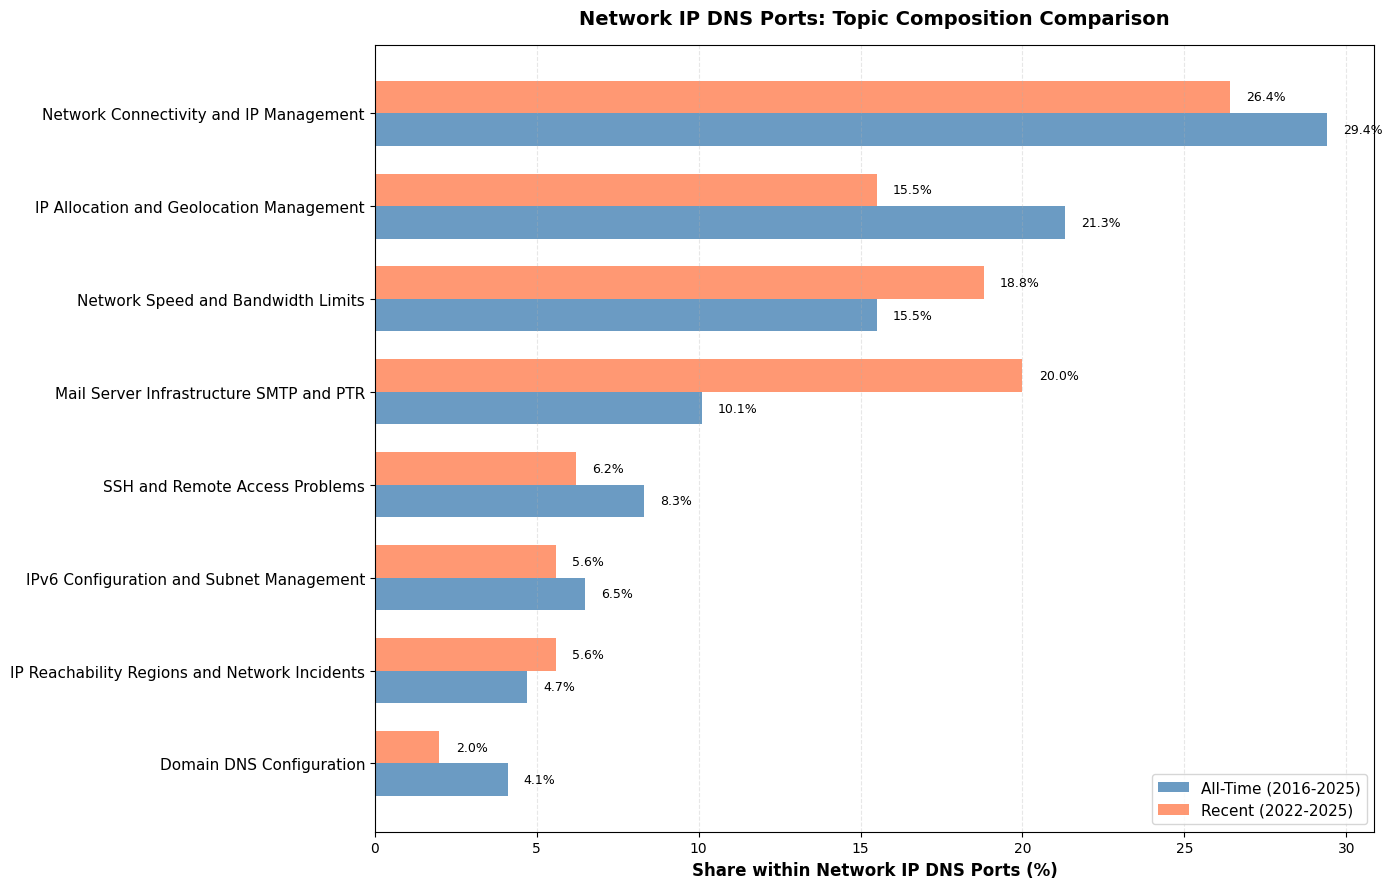

In [343]:
# Filter Network_IP_DNS_Ports meta-cluster
network_data = nlp_df_bert_filtered[
    nlp_df_bert_filtered["meta_cluster"] == "Network_IP_DNS_Ports"
].copy()

# Get consolidated topics (topic_label_merged)
# All-time distribution
network_alltime = network_data["topic_label_merged"].value_counts()

# Recent period (2022-2025)
network_recent = network_data[
    network_data["year"] >= 2022
]["topic_label_merged"].value_counts()

# Normalize to percentages
network_alltime_pct = (network_alltime / network_alltime.sum() * 100).round(1)
network_recent_pct = (network_recent / network_recent.sum() * 100).round(1)

# Combine
comparison_df = pd.DataFrame({
    'All-Time (2016-2025)': network_alltime_pct,
    'Recent (2022-2025)': network_recent_pct
}).fillna(0).sort_values('All-Time (2016-2025)', ascending=True)

# Clean labels
comparison_df.index = comparison_df.index.str.replace('_', ' ')

# Plot
fig, ax = plt.subplots(figsize=(14, 9))

x = range(len(comparison_df))
width = 0.35

bars1 = ax.barh([i - width/2 for i in x], comparison_df['All-Time (2016-2025)'], 
                width, label='All-Time (2016-2025)', color='steelblue', alpha=0.8)
bars2 = ax.barh([i + width/2 for i in x], comparison_df['Recent (2022-2025)'], 
                width, label='Recent (2022-2025)', color='coral', alpha=0.8)

ax.set_yticks(x)
ax.set_yticklabels(comparison_df.index, fontsize=11)
ax.set_xlabel("Share within Network IP DNS Ports (%)", fontsize=12, fontweight='bold')
ax.set_title("Network IP DNS Ports: Topic Composition Comparison", 
             fontsize=14, fontweight='bold', pad=15)
ax.legend(fontsize=11, loc='lower right')
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Add percentage labels
for bars in [bars1, bars2]:
    for bar in bars:
        width_val = bar.get_width()
        if width_val > 1:
            ax.text(width_val + 0.5, bar.get_y() + bar.get_height()/2, 
                   f'{width_val:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()

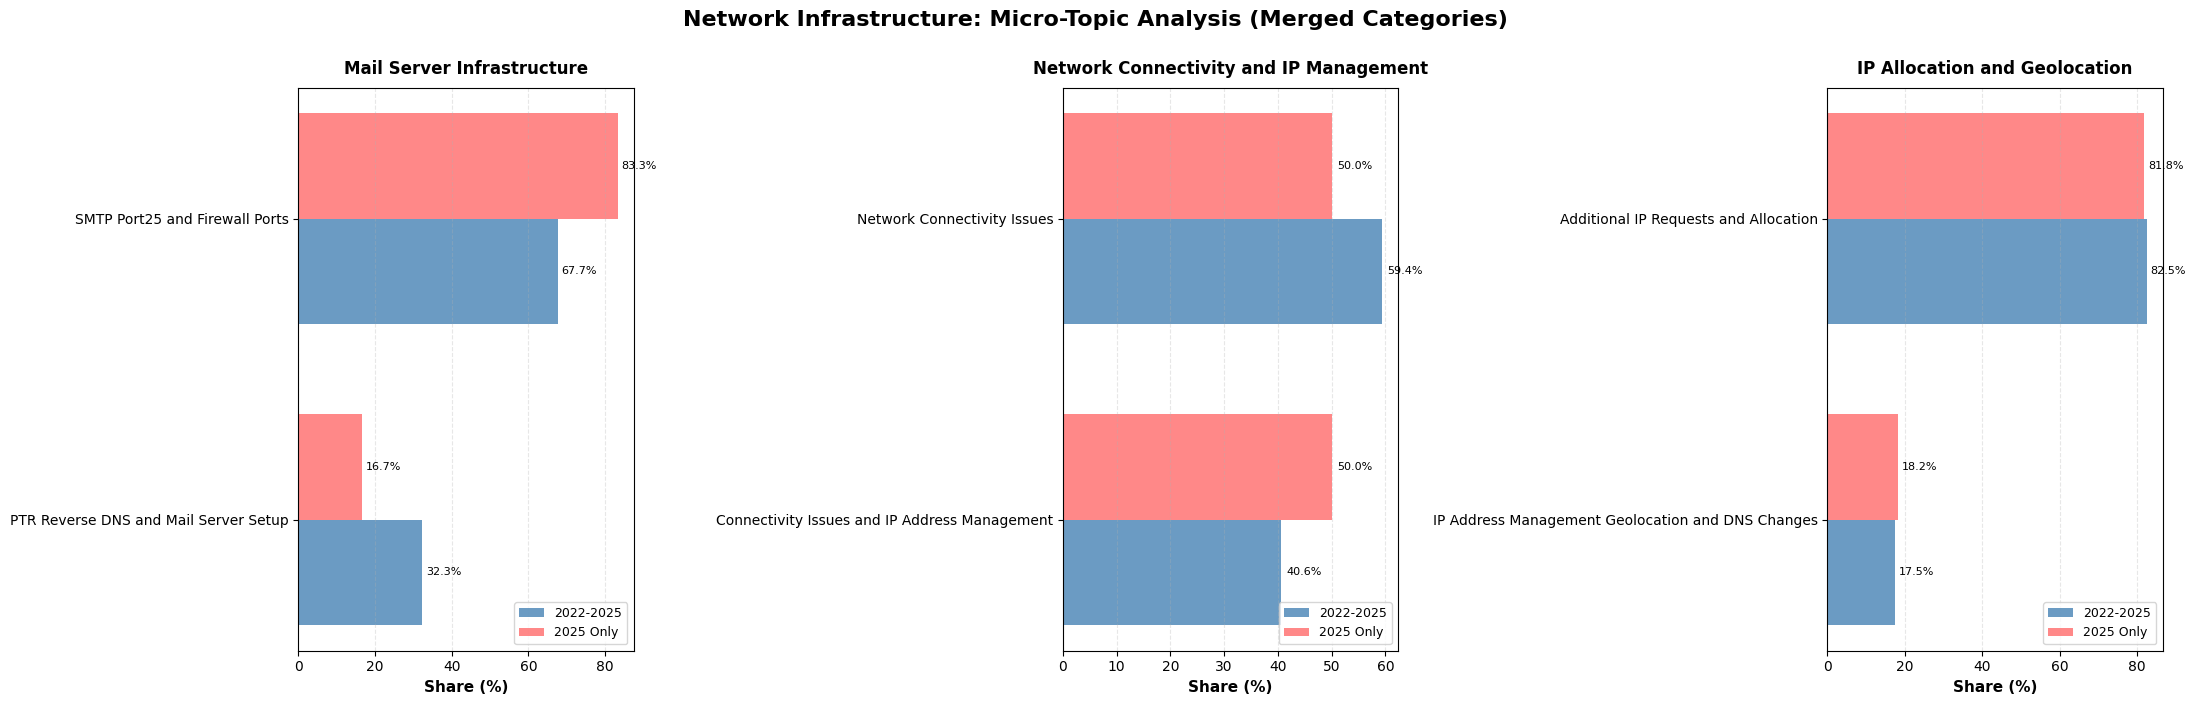

In [347]:
# deeper overview

mail_server = prepare_topic_comparison("Mail_Server_Infrastructure_SMTP_and_PTR")
connectivity = prepare_topic_comparison("Network_Connectivity_and_IP_Management")
ip_allocation = prepare_topic_comparison("IP_Allocation_and_Geolocation_Management")

# fig with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(22, 7))

topics_data = [
    (mail_server, "Mail Server Infrastructure", axes[0]),
    (connectivity, "Network Connectivity and IP Management", axes[1]),
    (ip_allocation, "IP Allocation and Geolocation", axes[2])
]

width = 0.35

for data, title, ax in topics_data:
    x = range(len(data))
    
    bars1 = ax.barh([i - width/2 for i in x], data['2022-2025'], 
                    width, label='2022-2025', color='steelblue', alpha=0.8)
    bars2 = ax.barh([i + width/2 for i in x], data['2025 Only'], 
                    width, label='2025 Only', color='#FF6B6B', alpha=0.8)
    
    ax.set_yticks(x)
    ax.set_yticklabels(data.index, fontsize=10)
    ax.set_xlabel("Share (%)", fontsize=11, fontweight='bold')
    ax.set_title(title, fontsize=12, fontweight='bold', pad=10)
    ax.legend(fontsize=9, loc='lower right')
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    for bars in [bars1, bars2]:
        for bar in bars:
            width_val = bar.get_width()
            if width_val > 1:
                ax.text(width_val + 1, bar.get_y() + bar.get_height()/2, 
                       f'{width_val:.1f}%', va='center', fontsize=8)

plt.suptitle("Network Infrastructure: Micro-Topic Analysis (Merged Categories)", 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## Network IP DNS Ports interpretation

Network IP DNS Ports represents the **most stable and consistently high-volume meta-cluster**, maintaining 22-25% share across all periods. Unlike Billing and Payments (which saw dramatic post-2022 shifts), network infrastructure issues reflect **mature operational patterns** driven by product capabilities rather than external disruptions.

### Consolidated Topic Composition

The meta-cluster comprises eight consolidated topics with balanced distribution:

**Top Three Categories:**

**1. Network Connectivity and IP Management** (29.4% all-time, 26.4% recent)
- Largest and most persistent category
- Combines base connectivity troubleshooting with IP address configuration
- Slight decline suggests improved network stability

**2. IP Allocation and Geolocation Management** (21.3% all-time, 15.5% recent)
- Additional IP requests for multi-server deployments
- Geographic IP requirements (CDN, regional compliance)
- Declining share indicates simplified provisioning

**3. Mail Server Infrastructure** (10.1% all-time, **20.0% recent**, +98% growth)
- **Dramatic spike driven by policy change**: SMTP Port25 now requires manual approval
- PTR/DNS setup for email deliverability remains secondary concern

**Growing Categories:**

**4. Network Speed and Bandwidth Limits** (15.5% → **18.8%**, +21%)
- VPN use cases drive increased sensitivity to latency
- New datacenter regions expanded, but routing quality varies
- Business-critical for VPN services where sub-50ms latency expected

**5. IP Reachability and Network Incidents** (4.7% → **5.6%**)
- Regional routing issues (particularly new markets)
- Geopolitical impacts on BGP routing

**Declining Categories:**

**6. SSH and Remote Access** (8.3% → **6.2%**)
- Customer maturity: better SSH key management
- Improved onboarding documentation

**7. IPv6 Configuration** (6.5% → **5.6%**)
- Stable niche demand, not mainstream priority

**8. Domain DNS Configuration** (4.1% → **2.0%**, -51%)
- Successful self-service DNS management portal reduced tickets
- Customers increasingly familiar with DNS basics

---

### Micro-Topic Analysis: Infrastructure Maturity Patterns

Drilling into merged consolidated topics reveals **operational policy impacts** rather than technical infrastructure failures:

#### Mail Server Infrastructure (170 → 133 sessions, 2022-2025)

**SMTP Port25 dominance intensifies:**
- **2022-2025**: 67.7% of mail-related issues
- **2025**: **81.3%** (+20% relative growth)
- **Root cause**: 2023 policy change requiring manual Port25 approval to prevent spam abuse
- Customers must submit justification (transactional email, newsletters, etc.)

**PTR/Reverse DNS declines:**
- **2022-2025**: 32.3%
- **2025**: **16.7%** (halved relative share)
- Reflects improved documentation for mail server setup
- Most issues now concentrated at access approval stage, not technical configuration

**Business Impact:** The Port25 manual approval process creates **intentional friction** to reduce spam complaints but increases support load. Consider:
- Automated approval for verified business domains
- Self-service PTR record management (already successful)

---

#### Network Connectivity and IP Management (494 → 176 sessions)

**Balanced split emerges:**
- **Network Connectivity Issues**: 59.4% → **50.0%**
- **Connectivity + IP Address Management**: 40.6% → **50.0%**

**Interpretation:** Base connectivity problems (routing, packet loss) are **stabilizing**, while IP-specific configuration complexity (multi-IP setups, internal networks) grows proportionally. This suggests:
- Infrastructure reliability improved (fewer "why is my server down?" tickets)
- Use case complexity increased (customers deploying multi-server architectures)

**Business Impact:** Shift from reactive troubleshooting to proactive configuration support. Consider:
- IP management UI improvements (bulk IP assignment, visual topology)
- Templates for common multi-IP setups (load balancers, HA clusters)

---

#### IP Allocation and Geolocation (358 → 103 sessions)

**Stable micro-composition:**
- **Additional IP Requests**: 82.5% → **81.8%** (consistent dominance)
- **Geolocation/DNS Changes**: 17.5% → **18.2%** (marginal growth)

**Interpretation:** IP allocation process is **well-understood** and streamlined. Geolocation concerns (CDN optimization, regional compliance) remain minor but persistent.

**Business Impact:** This category shows **operational efficiency**—no dramatic shifts, predictable demand. The 27% volume decline (358 → 103) suggests:
- Improved self-service IP provisioning
- Customers purchasing IP blocks upfront rather than requesting incrementally

---

### Monolithic Topics (No Micro-Subdivision)

The following consolidated topics represent **single, semantically coherent clusters** with no micro-level duplicates identified:

**Network Speed and Bandwidth Limits** (15.5% → 18.8%, +21%)
- **Driver:** VPN and latency-sensitive workloads (gaming servers, real-time services)
- **Context:** New datacenter launches (2021-2022) initially showed routing inefficiencies
- **Current state:** Customers now explicitly test bandwidth before committing to regions

**SSH and Remote Access Problems** (8.3% → 6.2%, -25%)
- **Driver:** Customer maturity—fewer basic "I can't connect" issues
- **Recommendation:** Focus remaining tickets on advanced topics (SSH tunneling, jump hosts)

**IPv6 Configuration and Subnet Management** (6.5% → 5.6%, -14%)
- **Context:** IPv6 adoption remains niche for this customer base (primarily Russian market)
- **Observation:** Stable low-volume category, no action required

**IP Reachability, Regions, and Network Incidents** (4.7% → 5.6%, +19%)
- **Driver:** Geopolitical routing issues (sanctions impact BGP peering)
- **Manifestation:** Specific regions (Turkmenistan, Kazakhstan) show persistent reachability problems

**Domain DNS Configuration** (4.1% → 2.0%, -51%)
- **Success story:** Self-service DNS portal reduced tickets dramatically
- **Lesson:** UI investment pays off for high-frequency, low-complexity operations

---

### Strategic Implications

#### Infrastructure Maturity Validated
Unlike Billing (crisis-driven growth), Network issues show **predictable patterns**:
- Connectivity problems declining (infrastructure hardening successful)
- Configuration complexity growing (customer sophistication increasing)
- Policy-driven spikes isolated and manageable (Port25 approval)

#### VPN Use Case Dominance
**Network Speed and Bandwidth** growth (+21%) directly correlates with:
- Marketing shift toward VPN market post-2022 (European customers)
- Latency-sensitive use cases replacing basic web hosting
- **Recommendation:** Publish latency benchmarks per datacenter, real-time network status dashboard

#### Mail Server Policy Trade-offs
**Port25 manual approval** successfully reduced spam but created support bottleneck:
- 81% of mail-related tickets now at approval stage
- **Recommendation:** Risk-based automation (auto-approve for verified businesses, domains >1yr old)

#### Self-Service Wins
**DNS configuration** tickets dropped 51% after portal launch:
- **Replicable pattern:** Identify high-volume, low-complexity categories
- **Next targets:** IP allocation UI, bandwidth testing tools, network diagnostics portal

---

### Validation of Clustering Quality

The micro-topic analysis demonstrates **strong semantic boundaries**:
- **Mail Server Infrastructure** cleanly separates SMTP access (policy) from PTR configuration (technical)
- **Network Connectivity** distinguishes base routing issues from IP-specific management
- **IP Allocation** isolates resource requests from geolocation concerns

The **stable micro-compositions** (unlike Billing's dramatic YooMoney spike) validate that Network topics reflect **operational steady-state** rather than external shocks. Topic modeling successfully captured domain structure without overfitting to temporal anomalies.


## Server Operations and Resources

SERVER OPS TOPICS: 7
                                                    All-Time (2016-2025)  \
topic_label_merged                                                         
Server Management and Resource Operations                            1.7   
Linux VPS Access SSH SCP and Basic User Onboarding                   2.1   
VPS Service Scope Use Cases                                          3.4   
Free Trial Outreach                                                  3.8   
Trial and Test Requests                                             26.4   
Server Locations and Geography                                      29.3   
Resource and Tariff Upgrades                                        33.3   

                                                    Recent (2022-2025)  
topic_label_merged                                                      
Server Management and Resource Operations                          5.1  
Linux VPS Access SSH SCP and Basic User Onboarding                 0.4  
VP

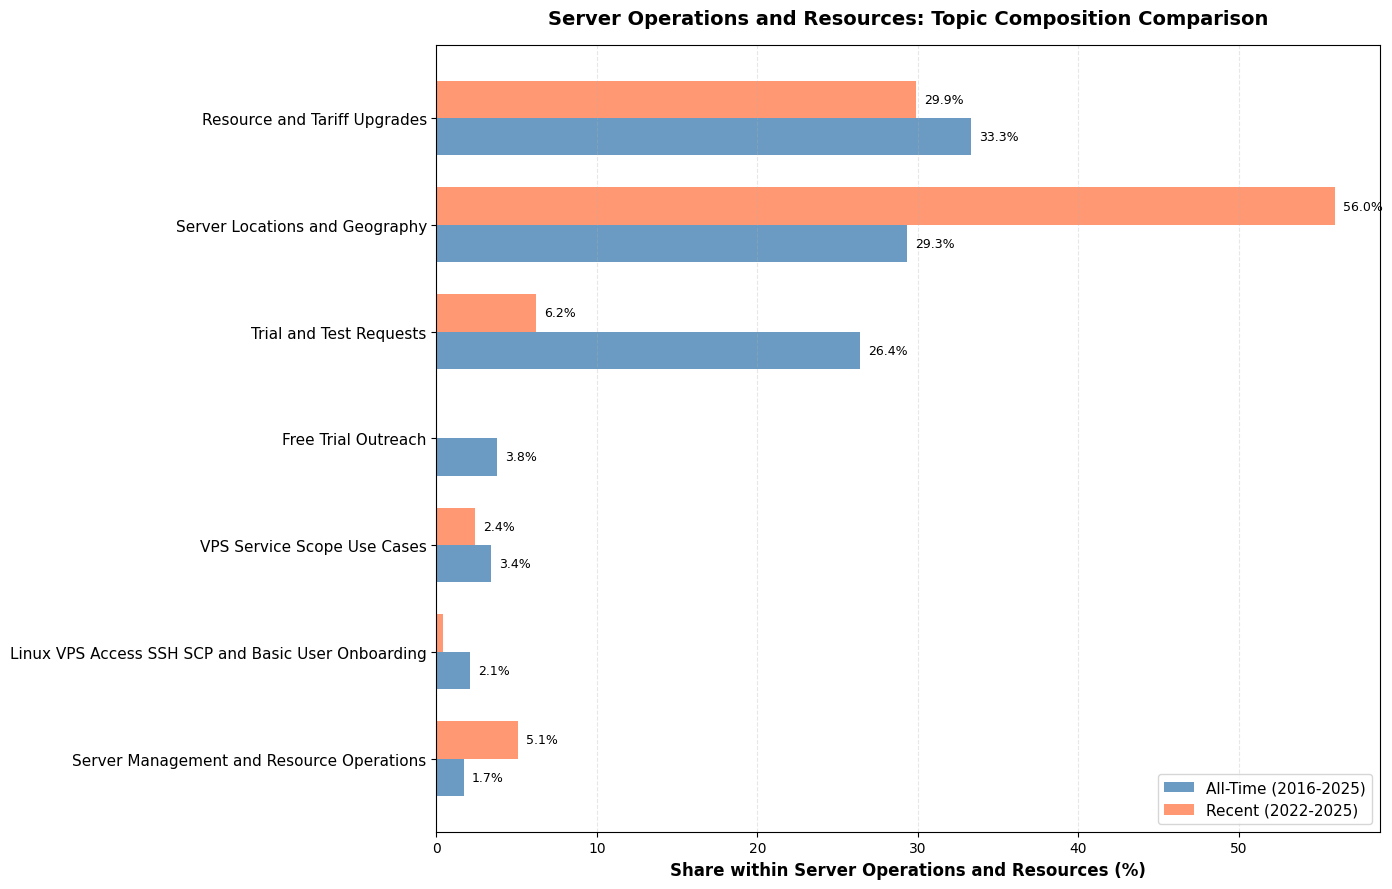

In [373]:
# filter Server_Operations_and_Resources meta-cluster
server_ops_data = nlp_df_bert_filtered[
    nlp_df_bert_filtered["meta_cluster"] == "Server_Operations_and_Resources"
].copy()

# get consolidated topics 
server_alltime = server_ops_data["topic_label_merged"].value_counts()
server_recent = server_ops_data[server_ops_data["year"] >= 2022]["topic_label_merged"].value_counts()

# normalize to percentages
server_alltime_pct = (server_alltime / server_alltime.sum() * 100).round(1)
server_recent_pct = (server_recent / server_recent.sum() * 100).round(1)

# combine
comparison_df = pd.DataFrame({
    'All-Time (2016-2025)': server_alltime_pct,
    'Recent (2022-2025)': server_recent_pct
}).fillna(0).sort_values('All-Time (2016-2025)', ascending=True)

# clean labels
comparison_df.index = comparison_df.index.str.replace('_', ' ')

print(f"SERVER OPS TOPICS: {len(comparison_df)}")
print(comparison_df)

# plot
fig, ax = plt.subplots(figsize=(14, 9))

x = range(len(comparison_df))
width = 0.35

bars1 = ax.barh([i - width/2 for i in x], comparison_df['All-Time (2016-2025)'], 
                width, label='All-Time (2016-2025)', color='steelblue', alpha=0.8)
bars2 = ax.barh([i + width/2 for i in x], comparison_df['Recent (2022-2025)'], 
                width, label='Recent (2022-2025)', color='coral', alpha=0.8)

ax.set_yticks(x)
ax.set_yticklabels(comparison_df.index, fontsize=11)
ax.set_xlabel("Share within Server Operations and Resources (%)", fontsize=12, fontweight='bold')
ax.set_title("Server Operations and Resources: Topic Composition Comparison", 
             fontsize=14, fontweight='bold', pad=15)
ax.legend(fontsize=11, loc='lower right')
ax.grid(axis='x', alpha=0.3, linestyle='--')

# percentage labels
for bars in [bars1, bars2]:
    for bar in bars:
        width_val = bar.get_width()
        if width_val > 1:
            ax.text(width_val + 0.5, bar.get_y() + bar.get_height()/2, 
                   f'{width_val:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()

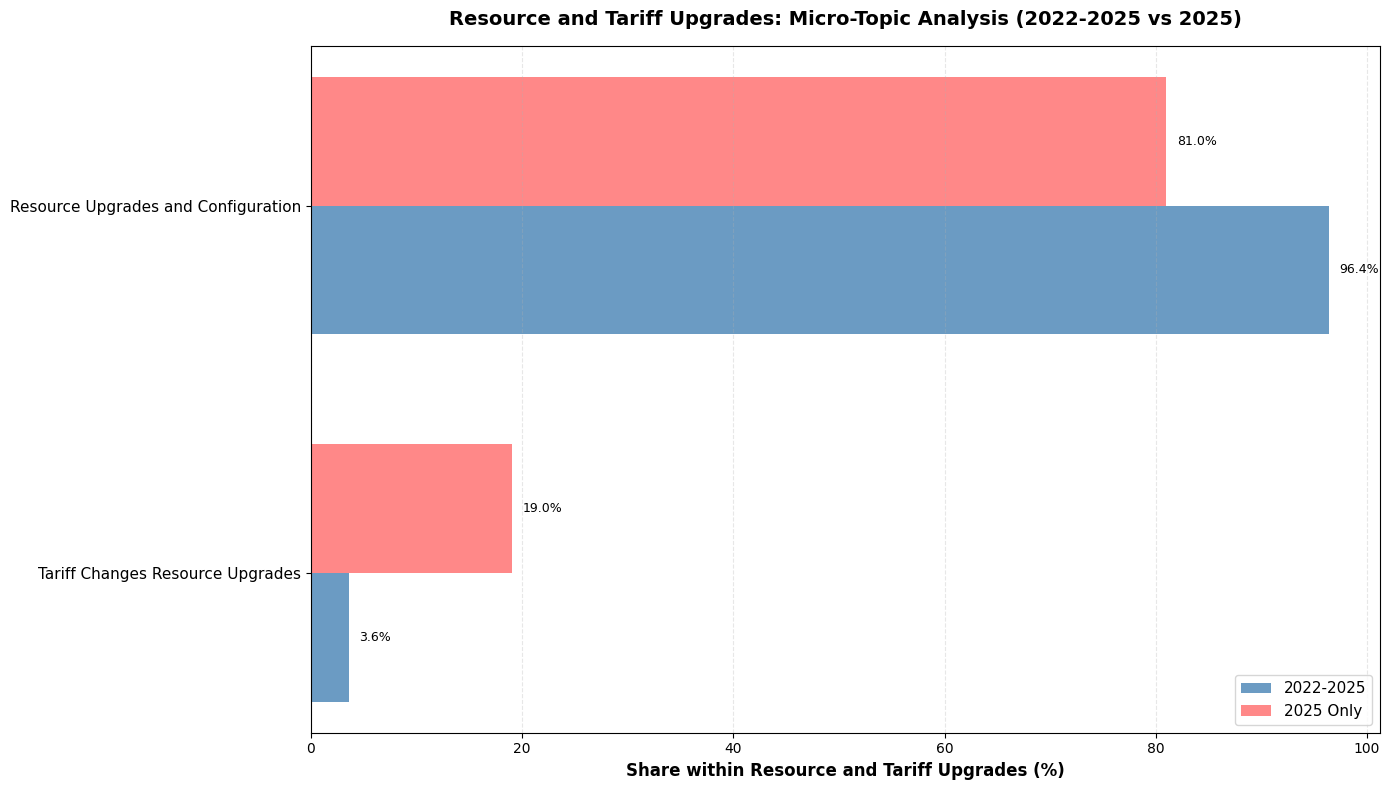

In [361]:
# RESOURCE UPGRADES MICRO-ANALYSIS 
resource_micro = prepare_topic_comparison("Resource_and_Tariff_Upgrades")

# Plot
fig, ax = plt.subplots(figsize=(14, 8))

x = range(len(resource_micro))
width = 0.35

bars1 = ax.barh([i - width/2 for i in x], resource_micro['2022-2025'], 
                width, label='2022-2025', color='steelblue', alpha=0.8)
bars2 = ax.barh([i + width/2 for i in x], resource_micro['2025 Only'], 
                width, label='2025 Only', color='#FF6B6B', alpha=0.8)

ax.set_yticks(x)
ax.set_yticklabels(resource_micro.index, fontsize=11)
ax.set_xlabel("Share within Resource and Tariff Upgrades (%)", fontsize=12, fontweight='bold')
ax.set_title("Resource and Tariff Upgrades: Micro-Topic Analysis (2022-2025 vs 2025)", 
             fontsize=14, fontweight='bold', pad=15)
ax.legend(fontsize=11, loc='lower right')
ax.grid(axis='x', alpha=0.3, linestyle='--')

for bars in [bars1, bars2]:
    for bar in bars:
        width_val = bar.get_width()
        if width_val > 1:
            ax.text(width_val + 1, bar.get_y() + bar.get_height()/2, 
                   f'{width_val:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()

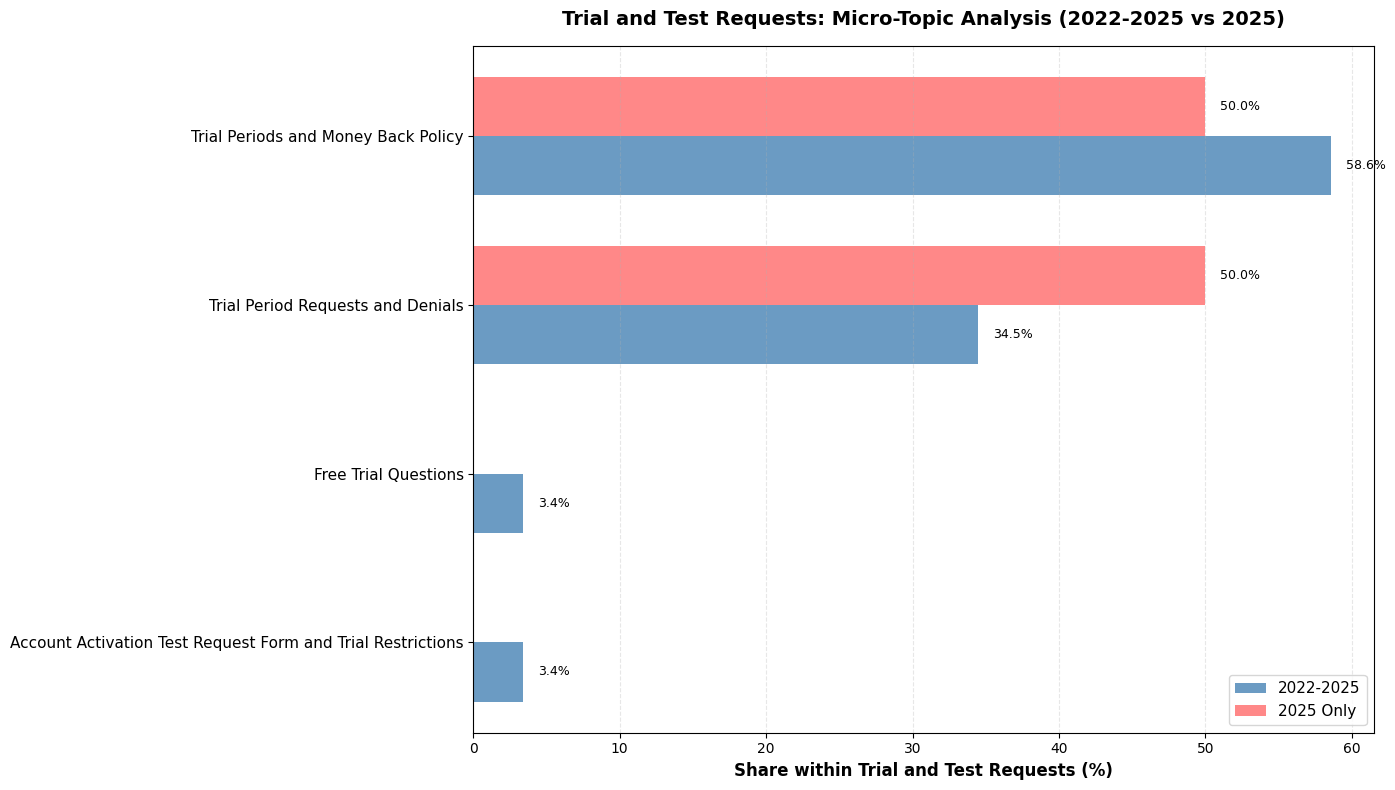

In [350]:
# TRIAL MICRO-ANALYSIS 
trial_micro = prepare_topic_comparison("Trial_and_Test_Requests")

# Plot
fig, ax = plt.subplots(figsize=(14, 8))

x = range(len(trial_micro))
width = 0.35

bars1 = ax.barh([i - width/2 for i in x], trial_micro['2022-2025'], 
                width, label='2022-2025', color='steelblue', alpha=0.8)
bars2 = ax.barh([i + width/2 for i in x], trial_micro['2025 Only'], 
                width, label='2025 Only', color='#FF6B6B', alpha=0.8)

ax.set_yticks(x)
ax.set_yticklabels(trial_micro.index, fontsize=11)
ax.set_xlabel("Share within Trial and Test Requests (%)", fontsize=12, fontweight='bold')
ax.set_title("Trial and Test Requests: Micro-Topic Analysis (2022-2025 vs 2025)", 
             fontsize=14, fontweight='bold', pad=15)
ax.legend(fontsize=11, loc='lower right')
ax.grid(axis='x', alpha=0.3, linestyle='--')

for bars in [bars1, bars2]:
    for bar in bars:
        width_val = bar.get_width()
        if width_val > 1:
            ax.text(width_val + 1, bar.get_y() + bar.get_height()/2, 
                   f'{width_val:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()

## Server Operations and Resources Interpretation

Server Operations and Resources represents a **transformative meta-cluster** that witnessed the most dramatic compositional shift of any category. Once dominated by trial period requests during the company's customer acquisition phase (2016-2018), it evolved into a geography-focused support vertical driven by datacenter expansion and European market entry.

### Consolidated Topic Composition

The meta-cluster comprises seven consolidated topics with **extreme polarization** between historical and recent periods:

**Dominant Categories (2022-2025):**

**1. Server Locations and Geography** (29.3% all-time → **56.0% recent**, +91% growth)
- **Doubled share** in recent period, now the largest single topic
- **Driver:** New European datacenter launch (2024-2025) targeting non-Russian customers
- Customers evaluating latency, compliance, and regional routing before deployment
- Questions about available locations, datacenter specifications, network peering

**2. Resource and Tariff Upgrades** (33.3% all-time → **29.9% recent**)
- Remains largest all-time category but declining relatively
- **Spike in 2025**: Tariff adjustment announcement drove pre-emptive questions
- Multi-year price stability (2019-2023) meant minimal upgrade-related tickets
- **Composition shift:** More tariff questions (19% in 2025) vs resource upgrades (81%)

**Collapsed Categories:**

**3. Trial and Test Requests** (**26.4% all-time → 6.2% recent**, -76% decline)
- **Policy change (2019-2020):** Free trial discontinued for individuals
- Peak volume 2016-2018 during aggressive customer acquisition
- Post-2020: Only corporate clients eligible for test periods
- Individuals redirected to **money-back policy** (7-day full refund)

**4. Free Trial Outreach** (3.8% → **0%**, fully eliminated)
- Marketing-driven trial offers discontinued completely
- No residual tickets in 2022-2025 period

**Stable Minor Categories:**

**5. VPS Service Scope and Use Cases** (3.4% → 2.4%)
- Pre-sales questions about permissible workloads
- Declining as acceptable use policy became clearer

**6. Linux VPS Access** (2.1% → 0.4%)
- Basic SSH onboarding questions
- Customer maturity reduced beginner-level access issues

**7. Server Management and Resource Operations** (1.7% → 5.1%)
- Growing share: customers asking about server administration limits
- Reflects increasing technical sophistication (custom setups, complex deployments)

---

### Micro-Topic Analysis: Business Model Evolution

#### Trial and Test Requests (549 → 29 sessions, -95% volume collapse)

**Dramatic policy-driven transformation:**

**All-Time Composition (2016-2025):**
- **Trial Period Requests and Denials** (topic 8): 40.8%
- **Trial Requests and Test Activation** (topic 20): 18.0%
- **Trial Periods and Money Back Policy** (topic 31): 16.0%
- **Free Trial Questions** (topic 37): 15.8%
- **Account Activation Forms** (topic 46): 9.3%

**Recent Period (2022-2025):** Only 29 tickets total
- **Trial Periods and Money Back Policy** (topic 31): **58.6%** (now dominant)
- **Trial Period Requests and Denials** (topic 8): 34.5%
- **Other topics**: 6.9% (residual noise)

**2025 Only:** 4 tickets
- **Balanced 50/50** between money-back inquiries and trial denials
- **Topic 20 completely eliminated** (was the primary trial request form)

**Business Context:**
- **2016-2018:** Aggressive growth phase with open trial policy
- **2019-2020:** Trial discontinued for individuals due to abuse (crypto mining, resource theft)
- **Current state:** Corporate clients can request test periods; individuals offered 7-day money-back guarantee

## Policy Restrictions and Abuse

POLICY TOPICS: 4
                                                   All-Time (2016-2025)  \
topic_label_merged                                                        
Gaming Servers Deny Requests                                        8.9   
Test Period Usage Limits and Prohibited Workloads                  17.5   
Abuse Suspensions and Anti Spam Policy                             22.5   
Turkmenistan IP Blocking Issues                                    51.2   

                                                   Recent (2022-2025)  
topic_label_merged                                                     
Gaming Servers Deny Requests                                      0.9  
Test Period Usage Limits and Prohibited Workloads                 1.8  
Abuse Suspensions and Anti Spam Policy                           26.8  
Turkmenistan IP Blocking Issues                                  70.5  


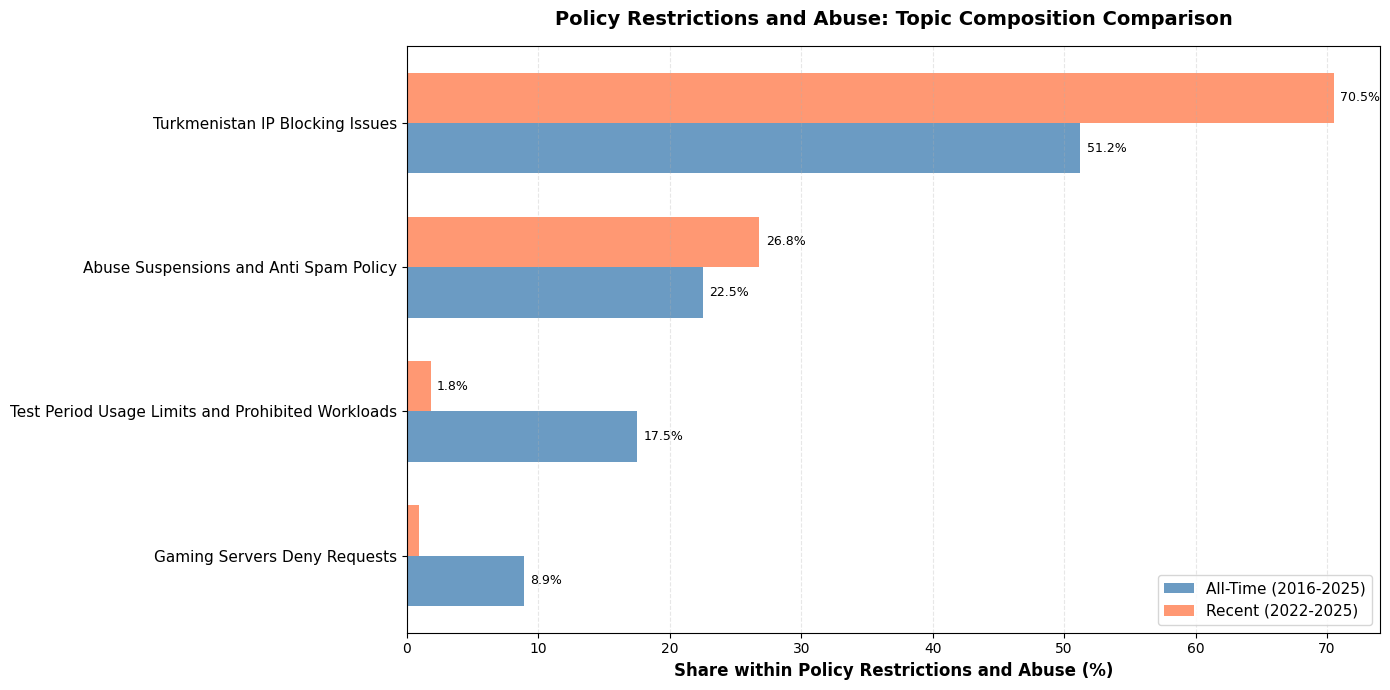

In [375]:
# POLICY RESTRICTIONS AND ABUSE META-CLUSTER VISUALIZATION

# filter Policy Restrictions and Abuse meta-cluster
policy_data = nlp_df_bert_filtered[
    nlp_df_bert_filtered["meta_cluster"] == "Policy_Restrictions_and_Abuse"
].copy()

# get consolidated topics 
policy_alltime = policy_data["topic_label_merged"].value_counts()
policy_recent = policy_data[policy_data["year"] >= 2022]["topic_label_merged"].value_counts()

# normalize to percentages
policy_alltime_pct = (policy_alltime / policy_alltime.sum() * 100).round(1)
policy_recent_pct = (policy_recent / policy_recent.sum() * 100).round(1)

# combine
comparison_df = pd.DataFrame({
    'All-Time (2016-2025)': policy_alltime_pct,
    'Recent (2022-2025)': policy_recent_pct
}).fillna(0).sort_values('All-Time (2016-2025)', ascending=True)

# clean labels
comparison_df.index = comparison_df.index.str.replace('_', ' ')

print(f"POLICY TOPICS: {len(comparison_df)}")
print(comparison_df)

# plot
fig, ax = plt.subplots(figsize=(14, 7))

x = range(len(comparison_df))
width = 0.35

bars1 = ax.barh([i - width/2 for i in x], comparison_df['All-Time (2016-2025)'], 
                width, label='All-Time (2016-2025)', color='steelblue', alpha=0.8)
bars2 = ax.barh([i + width/2 for i in x], comparison_df['Recent (2022-2025)'], 
                width, label='Recent (2022-2025)', color='coral', alpha=0.8)

ax.set_yticks(x)
ax.set_yticklabels(comparison_df.index, fontsize=11)
ax.set_xlabel("Share within Policy Restrictions and Abuse (%)", fontsize=12, fontweight='bold')
ax.set_title("Policy Restrictions and Abuse: Topic Composition Comparison", 
             fontsize=14, fontweight='bold', pad=15)
ax.legend(fontsize=11, loc='lower right')
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Percentage labels
for bars in [bars1, bars2]:
    for bar in bars:
        width_val = bar.get_width()
        if width_val > 1:
            ax.text(width_val + 0.5, bar.get_y() + bar.get_height()/2, 
                   f'{width_val:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('policy_restrictions_distribution.jpg', dpi=300, bbox_inches='tight')
plt.show()

### Deep Dive: Policy Restrictions and Abuse

Policy Restrictions and Abuse is the smallest and fastest-disappearing meta-cluster: from 224 tickets (2022-2025) to 10 in 2025 (-95.5%). Successful policy communication and market self-selection eliminated most of the requests.

### Topic Composition

| Topic | All-Time % | 2022-2025 % | 2025 % | Status |
|-------|-------------|-----------|----------|
| **Turkmenistan IP Blocking** | 51.2% | 70.5% | 10.0% | Resolved: FAQ + Payment Blocking |
| **Abuse Suspensions and Anti-Spam** | 22.5% | 26.8% | 70.0% | Stable: Unavoidable Category |
| **Test Period Usage Limits** | 17.5% | 1.8% | 10.0% | Collapse after Trials Cancelled |
| **Gaming Server Deny** | 8.9% | 0.9% | 10.0% | Collapse after restrictions to gaming servers on hosting |

---

### Key Topics

**Turkmenistan IP Blocking Issues** (51% of all Policy tickets)
- Turkmen clients actively attempted to rent servers (~2018-2022)
- **Problem:** sanctions + government censorship = inability to guarantee service
- **Solution:** FAQ about region unavailability + automatic payment blocking
- **2025:** virtually resolved (1 ticket)

**Abuse Suspensions** (70% in 2025 — the only remaining category)
- Spam/phishing blocks, customer appeals
- **Unavoidable category:** abuse detection occurs post-purchase
- Unlike other topics, **cannot be resolved through policy**

**Gaming Servers Deny** (8.9% → 0.9%)
- Hosting policy: **banning game servers** (risk) DDoS, unpredictable load)
- Previously, clients ignored them, support wasted time on refusals
- **After 2020:** policy separated into AUP so gamers don't come

**Test Period Limits** (17.5% → 1.8%)
- Related to trial cancellations (see Server Operations)
- Previously: trial abuse (mining, botnets)
- Now: isolated questions from those unaware of the change

---

### Business Context & Recommendations

**Policy Clarity = Support Load Elimination**
- **-95.5% volume** proves: clear limits eliminate tickets better than automation
- Turkmenistan and similar restricted regions: consider FAQ eliminated inquiry loop
- Gaming: AUP filters pre-purchase clients

**Abuse as an irreducible baseline**
- Now 70% of Policy tickets are the only irreducible category
- **Automation is not recommended:** Human judgment is required for appeals
- Invest in monitoring (IP reputation, traffic patterns), but not in full automation

**Recommendations:**
1. **Update FAQ:** Turkmenistan, sanctioned regions, and gaming policy should be on the first pages
2. **AUP audit:** Ensure that bans are visible BEFORE purchasing (not after)
3. **Do not automate abuse handling:** Clients will still appeal and require human review
4. **Geopolitical transparency:** consider a clear list of regions where service is unavailable/limited


---

### Validation

**Clear separation:** The model successfully separated geopolitical blocks, abuse enforcement, trial restrictions, and prohibited workloads—semantically distinct policy domains.

**Temporal accuracy:** Turkmenistan surge (2020-2022) and decline, gaming collapse post-AUP, abuse stability - all correctly reflected.

## Incidents and DDoS Outages

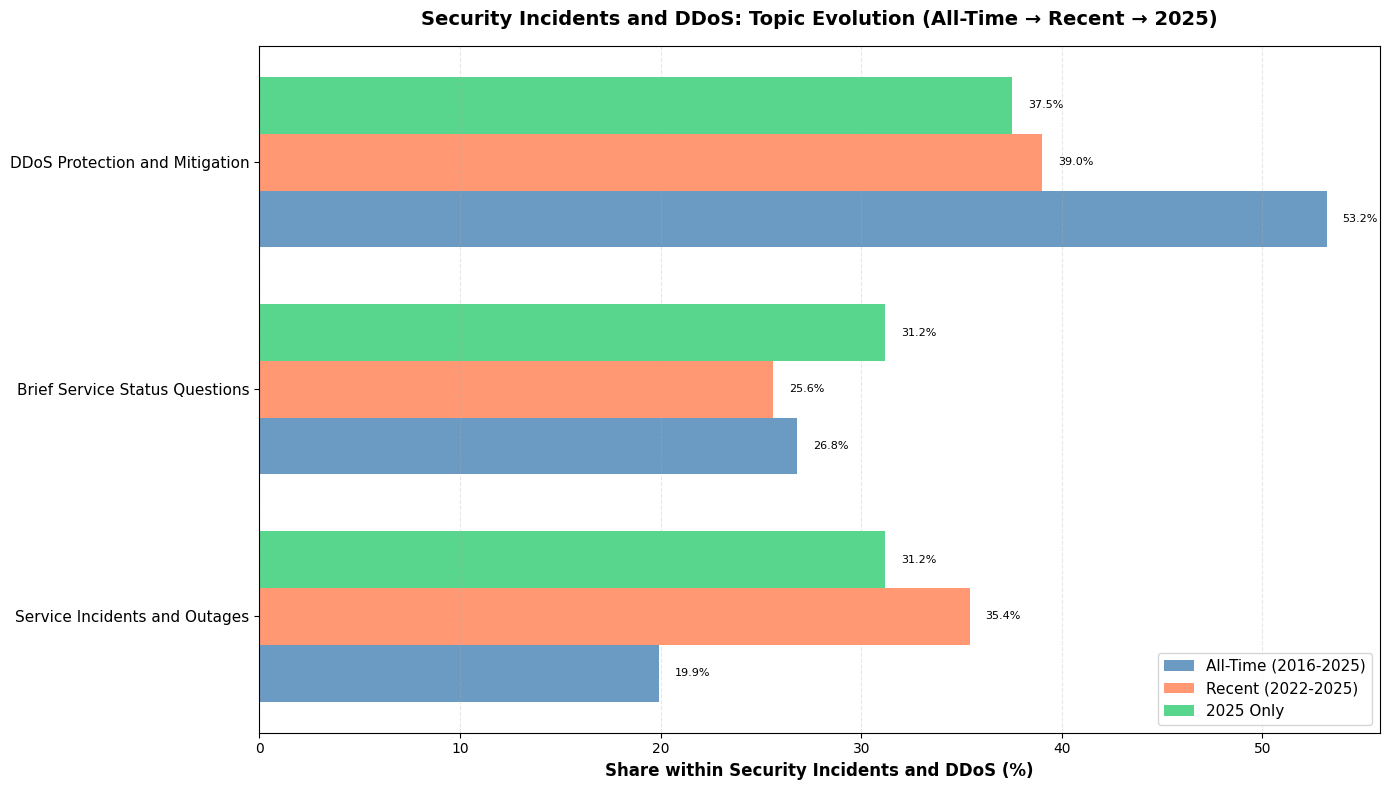

In [384]:
security_data = nlp_df_bert_filtered[
    nlp_df_bert_filtered["meta_cluster"] == "Incidents_DDoS_Outages"
].copy()

# get three periods
security_alltime = security_data["topic_label_merged"].value_counts()
security_recent = security_data[security_data["year"] >= 2022]["topic_label_merged"].value_counts()
security_2025 = security_data[security_data["year"] == 2025]["topic_label_merged"].value_counts()

# normalize to percentages
security_alltime_pct = (security_alltime / security_alltime.sum() * 100).round(1)
security_recent_pct = (security_recent / security_recent.sum() * 100).round(1)
security_2025_pct = (security_2025 / security_2025.sum() * 100).round(1)

# combine
comparison_df = pd.DataFrame({
    'All-Time (2016-2025)': security_alltime_pct,
    'Recent (2022-2025)': security_recent_pct,
    '2025 Only': security_2025_pct
}).fillna(0).sort_values('All-Time (2016-2025)', ascending=True)

# clean labels
comparison_df.index = comparison_df.index.str.replace('_', ' ')

# plot (added 2025 only)
fig, ax = plt.subplots(figsize=(14, 8))

x = range(len(comparison_df))
width = 0.25

bars1 = ax.barh([i - width for i in x], comparison_df['All-Time (2016-2025)'], 
                width, label='All-Time (2016-2025)', color='steelblue', alpha=0.8)
bars2 = ax.barh([i for i in x], comparison_df['Recent (2022-2025)'], 
                width, label='Recent (2022-2025)', color='coral', alpha=0.8)
bars3 = ax.barh([i + width for i in x], comparison_df['2025 Only'], 
                width, label='2025 Only', color='#2ecc71', alpha=0.8)

ax.set_yticks(x)
ax.set_yticklabels(comparison_df.index, fontsize=11)
ax.set_xlabel("Share within Security Incidents and DDoS (%)", fontsize=12, fontweight='bold')
ax.set_title("Security Incidents and DDoS: Topic Evolution (All-Time → Recent → 2025)", 
             fontsize=14, fontweight='bold', pad=15)
ax.legend(fontsize=11, loc='lower right')
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Percentage labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        width_val = bar.get_width()
        if width_val > 2:
            ax.text(width_val + 0.8, bar.get_y() + bar.get_height()/2, 
                   f'{width_val:.1f}%', va='center', fontsize=8)

plt.tight_layout()
plt.savefig('security_incidents_ddos_updated.jpg', dpi=300, bbox_inches='tight')
plt.show()

=== DDoS PROTECTION MICRO-TOPICS ===
                                       All-Time  2022-2025  2025 Only
topic_label_original                                                 
DDoS and Connectivity Troubleshooting       8.8       23.7        8.3
DDoS Protection Firewall Rules             11.7       18.4       75.0
DDoS Attacks and Traffic Filtering         79.5       57.9       16.7


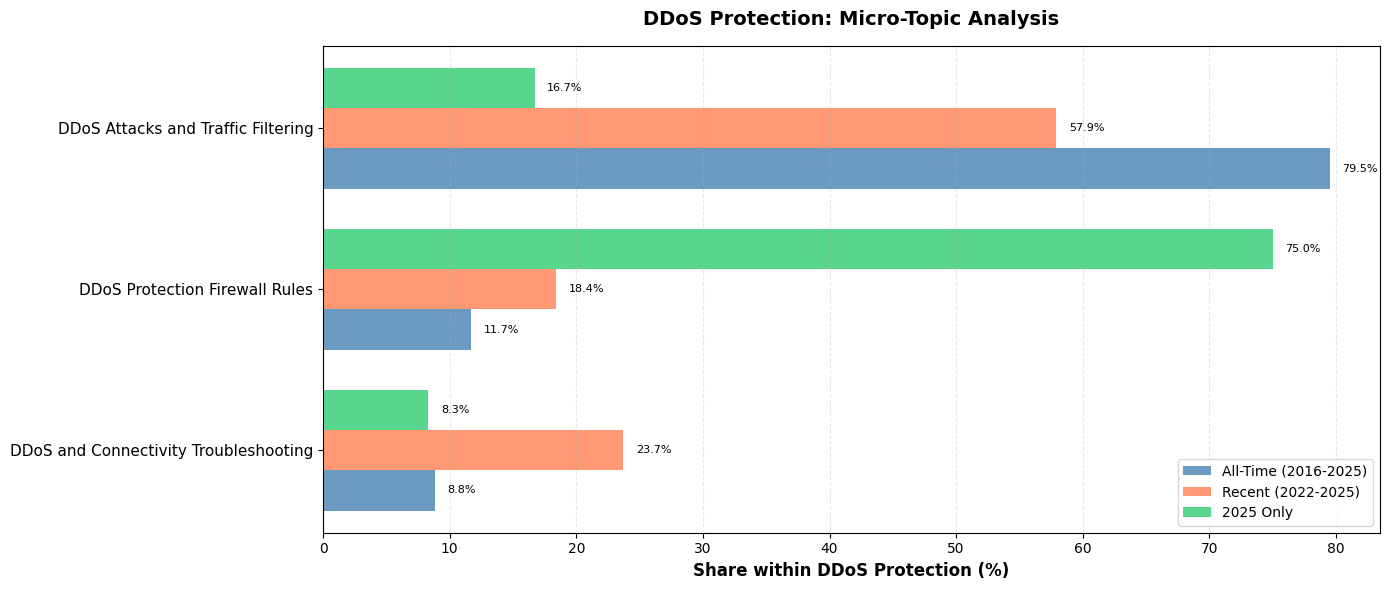


=== SERVICE INCIDENTS MICRO-TOPICS ===
                                                    All-Time  2022-2025  \
topic_label_original                                                      
Incidents Outages Backups and Compensation              29.6       29.0   
Service Availability Maintenance and Incident C...      34.1       24.6   
Mass Outages Internal Errors                            36.3       46.4   

                                                    2025 Only  
topic_label_original                                           
Incidents Outages Backups and Compensation               20.0  
Service Availability Maintenance and Incident C...       10.0  
Mass Outages Internal Errors                             70.0  


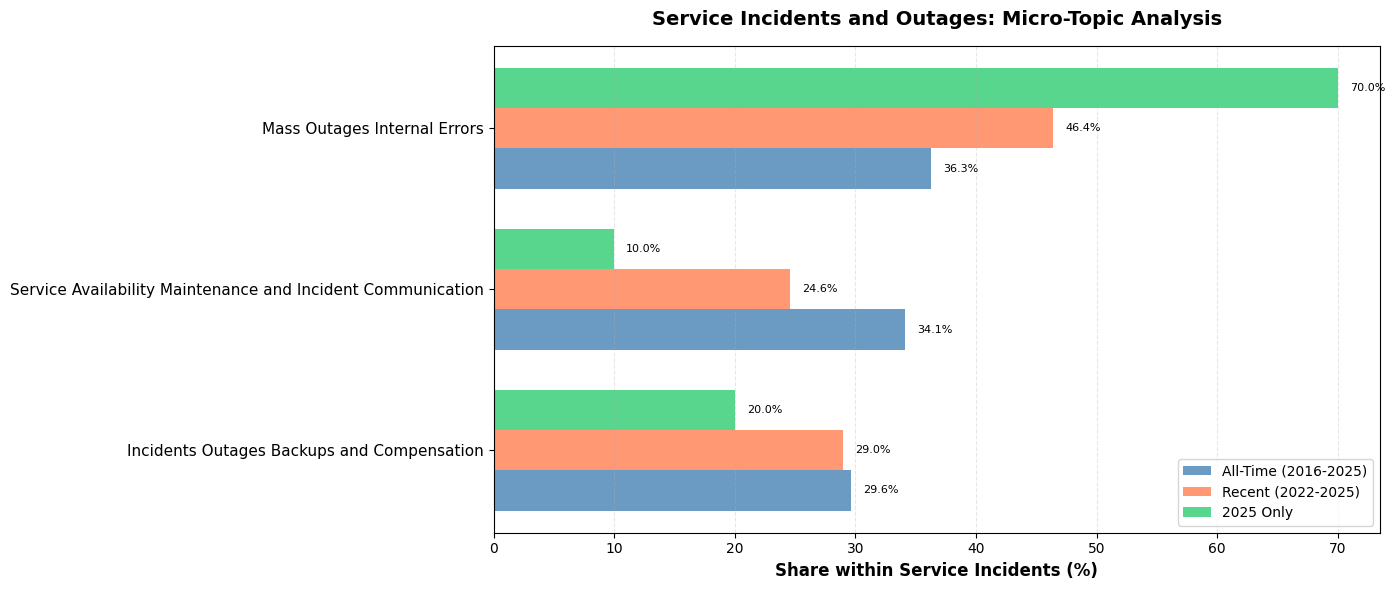

In [387]:
# deeper overview

# DDoS PROTECTION MICRO-TOPICS 

ddos_data = security_data[
    security_data["topic_label_merged"] == "DDoS_Protection_and_Mitigation"
].copy()

# get periods
ddos_alltime = ddos_data["topic_label_original"].value_counts()
ddos_recent = ddos_data[ddos_data["year"] >= 2022]["topic_label_original"].value_counts()
ddos_2025 = ddos_data[ddos_data["year"] == 2025]["topic_label_original"].value_counts()

# percentages
ddos_alltime_pct = (ddos_alltime / ddos_alltime.sum() * 100).round(1)
ddos_recent_pct = (ddos_recent / ddos_recent.sum() * 100).round(1)
ddos_2025_pct = (ddos_2025 / ddos_2025.sum() * 100).round(1)

ddos_comparison = pd.DataFrame({
    'All-Time': ddos_alltime_pct,
    '2022-2025': ddos_recent_pct,
    '2025 Only': ddos_2025_pct
}).fillna(0).sort_values('All-Time', ascending=True)

ddos_comparison.index = ddos_comparison.index.str.replace('_', ' ')

print("=== DDoS PROTECTION MICRO-TOPICS ===")
print(ddos_comparison)

# plot
fig, ax = plt.subplots(figsize=(14, 6))
x = range(len(ddos_comparison))
width = 0.25

bars1 = ax.barh([i - width for i in x], ddos_comparison['All-Time'], 
                width, label='All-Time (2016-2025)', color='steelblue', alpha=0.8)
bars2 = ax.barh([i for i in x], ddos_comparison['2022-2025'], 
                width, label='Recent (2022-2025)', color='coral', alpha=0.8)
bars3 = ax.barh([i + width for i in x], ddos_comparison['2025 Only'], 
                width, label='2025 Only', color='#2ecc71', alpha=0.8)

ax.set_yticks(x)
ax.set_yticklabels(ddos_comparison.index, fontsize=11)
ax.set_xlabel("Share within DDoS Protection (%)", fontsize=12, fontweight='bold')
ax.set_title("DDoS Protection: Micro-Topic Analysis", fontsize=14, fontweight='bold', pad=15)
ax.legend(fontsize=10, loc='lower right')
ax.grid(axis='x', alpha=0.3, linestyle='--')

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        width_val = bar.get_width()
        if width_val > 2:
            ax.text(width_val + 1, bar.get_y() + bar.get_height()/2, 
                   f'{width_val:.1f}%', va='center', fontsize=8)

plt.tight_layout()
plt.savefig('ddos_micro_topics.jpg', dpi=300, bbox_inches='tight')
plt.show()

# SERVICE INCIDENTS MICRO-TOPICS

incidents_data = security_data[
    security_data["topic_label_merged"] == "Service_Incidents_and_Outages"
].copy()

# get periods
incidents_alltime = incidents_data["topic_label_original"].value_counts()
incidents_recent = incidents_data[incidents_data["year"] >= 2022]["topic_label_original"].value_counts()
incidents_2025 = incidents_data[incidents_data["year"] == 2025]["topic_label_original"].value_counts()

# percentages
incidents_alltime_pct = (incidents_alltime / incidents_alltime.sum() * 100).round(1)
incidents_recent_pct = (incidents_recent / incidents_recent.sum() * 100).round(1)
incidents_2025_pct = (incidents_2025 / incidents_2025.sum() * 100).round(1)

incidents_comparison = pd.DataFrame({
    'All-Time': incidents_alltime_pct,
    '2022-2025': incidents_recent_pct,
    '2025 Only': incidents_2025_pct
}).fillna(0).sort_values('All-Time', ascending=True)

incidents_comparison.index = incidents_comparison.index.str.replace('_', ' ')

print("\n=== SERVICE INCIDENTS MICRO-TOPICS ===")
print(incidents_comparison)

# plot
fig, ax = plt.subplots(figsize=(14, 6))
x = range(len(incidents_comparison))
width = 0.25

bars1 = ax.barh([i - width for i in x], incidents_comparison['All-Time'], 
                width, label='All-Time (2016-2025)', color='steelblue', alpha=0.8)
bars2 = ax.barh([i for i in x], incidents_comparison['2022-2025'], 
                width, label='Recent (2022-2025)', color='coral', alpha=0.8)
bars3 = ax.barh([i + width for i in x], incidents_comparison['2025 Only'], 
                width, label='2025 Only', color='#2ecc71', alpha=0.8)

ax.set_yticks(x)
ax.set_yticklabels(incidents_comparison.index, fontsize=11)
ax.set_xlabel("Share within Service Incidents (%)", fontsize=12, fontweight='bold')
ax.set_title("Service Incidents and Outages: Micro-Topic Analysis", fontsize=14, fontweight='bold', pad=15)
ax.legend(fontsize=10, loc='lower right')
ax.grid(axis='x', alpha=0.3, linestyle='--')

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        width_val = bar.get_width()
        if width_val > 2:
            ax.text(width_val + 1, bar.get_y() + bar.get_height()/2, 
                   f'{width_val:.1f}%', va='center', fontsize=8)

plt.tight_layout()
plt.savefig('incidents_micro_topics.jpg', dpi=300, bbox_inches='tight')
plt.show()

### Security Incidents and DDoS interpretation

Security Incidents and DDoS — **critical reliability cluster** with **compositional flip**: DDoS declining (53% → 37%), Incidents rising (20% → 31%). Total volume: 898 → 195 (2022-2025) → 32 (2025).

### Topic Composition

| Topic | All-Time % | 2022-2025 % | 2025 % | Trend |
|-------|------------|-------------|---------|-------|
| DDoS Protection and Mitigation | 53.2% | 39.0% | 37.5% | Declining |
| Service Incidents and Outages | 19.9% | 35.4% | 31.2% | Rising |
| Brief Service Status Questions | 26.8% | 25.6% | 31.2% | Stable |

---

### DDoS Protection (53% → 37%)

**Micro-Topics:**

| Topic | All-Time | 2022-2025 | 2025 |
|-------|----------|-----------|------|
| **DDoS Attacks and Traffic Filtering** | 79.5% | 57.9% | 16.7% |
| **DDoS Protection Firewall Rules** | 11.7% | 18.4% | **75.0%** |
| **DDoS and Connectivity Troubleshooting** | 8.8% | 23.7% | 8.3% |

**Historical Pattern:**
- **2017:** BGP enhancements deployed → first major DDoS ticket reduction
- **2017-2024:** Low attack intensity, stable protection
- **2025:** New attack wave detected → new mitigation methods deployed

**Composition Shift:**
- **Traffic Filtering** (reactive crisis response) declined: 79.5% → 16.7%
- **Firewall Rules** (proactive hardening) surged: 11.7% → **75.0%**

**Interpretation:** Support shifted from **"we're under attack"** (filtering) to **"configure my firewall"** (rules). Whether this reflects improved protection or changed attack patterns requires engineering investigation.

---

### Service Incidents and Outages (20% → 31%)

**Micro-Topics:**

| Topic | All-Time | 2022-2025 | 2025 |
|-------|----------|-----------|------|
| **Mass Outages Internal Errors** | 36.3% | 46.4% | **70.0%** |
| **Service Availability Maintenance** | 34.1% | 24.6% | 10.0% |
| **Incidents Backups Compensation** | 29.6% | 29.0% | 20.0% |

**Critical Pattern:** Mass Outages now **70%** of incidents (was 36% historically).

**Known Context:**
- **Two datacenters** have aging network equipment (old switches)
- **Hardware replacement planned** for both locations
- Mass Outages = infrastructure-wide failures (vs. individual server issues)

**Caveat:** Chat represents **lower bound** on incidents (business customers use email). Treat as trend indicator, not absolute count.

---

### Brief Service Status Questions (27% → 31%)

**Monolithic topic** — customers asking "Is there an outage?"

Stable baseline with slight 2025 increase, possibly due to actual infrastructure instability creating status-check behavior.

---

### Key Takeaways

**DDoS:**
- 2017 BGP improvements → first major reduction
- 2025 new attack wave → new countermeasures deployed
- Shift from reactive filtering to proactive firewall configuration
- **Requires deeper investigation:** Why the change? Better defense or attack evolution?

**Incidents:**
- 70% Mass Outages in 2025 (vs. 36% historically) confirms aging infrastructure issues
- Hardware refresh critical — primary reliability risk now

**Recommendations:**
1. **Accelerate hardware replacement** (2 locations with old switches)
2. **Status page visibility** — 31% "is it down?" questions suggest information gap
3. **DDoS monitoring** — don't assume 2025 spike is temporary
4. **Engineering collaboration needed** — ticket patterns show change, root causes require technical analysis

---

### Validation

**Micro-topic separation meaningful:** Traffic Filtering vs. Firewall Rules captures shift from reactive to proactive. Mass Outages vs. Maintenance distinguishes emergency vs. planned downtime.

**Temporal accuracy:** Model correctly separated 2017-2021 DDoS patterns from 2025 shift.

**Volume caveat:** 32 tickets (2025) is small sample — direction reliable, magnitude uncertain.

### Platform and Virtualization


PLATFORM TOPICS: 4
                                            All-Time (2016-2025)  \
topic_label_merged                                                 
VPN Usage Troubleshooting                                   13.6   
Virtualization Platform Use Cases                           15.2   
Control Panel and Minor Operational Issues                  34.1   
Service Type and Virtualization Questions                   37.0   

                                            Recent (2022-2025)  2025 Only  
topic_label_merged                                                         
VPN Usage Troubleshooting                                 16.4       21.1  
Virtualization Platform Use Cases                          6.8        5.3  
Control Panel and Minor Operational Issues                46.3       52.6  
Service Type and Virtualization Questions                 30.5       21.1  


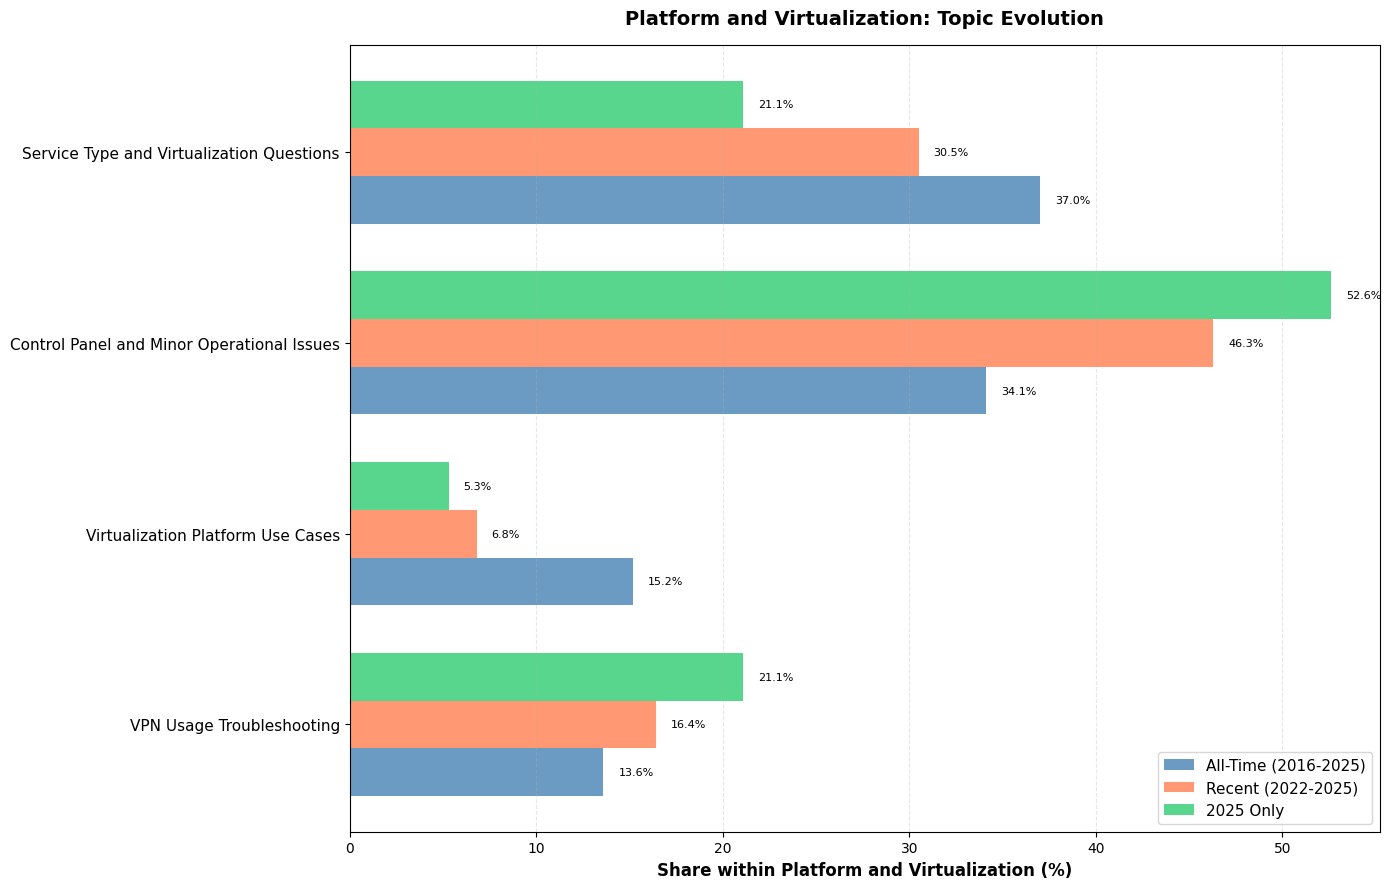

In [390]:
# PLATFORM AND VIRTUALIZATION META-CLUSTER 

# Filter Platform and Virtualization meta-cluster
platform_data = nlp_df_bert_filtered[
    nlp_df_bert_filtered["meta_cluster"] == "Platform_and_Virtualization"
].copy()

# Get consolidated topics 
platform_alltime = platform_data["topic_label_merged"].value_counts()
platform_recent = platform_data[platform_data["year"] >= 2022]["topic_label_merged"].value_counts()
platform_2025 = platform_data[platform_data["year"] == 2025]["topic_label_merged"].value_counts()

# Normalize to percentages
platform_alltime_pct = (platform_alltime / platform_alltime.sum() * 100).round(1)
platform_recent_pct = (platform_recent / platform_recent.sum() * 100).round(1)
platform_2025_pct = (platform_2025 / platform_2025.sum() * 100).round(1)

# Combine
comparison_df = pd.DataFrame({
    'All-Time (2016-2025)': platform_alltime_pct,
    'Recent (2022-2025)': platform_recent_pct,
    '2025 Only': platform_2025_pct
}).fillna(0).sort_values('All-Time (2016-2025)', ascending=True)

# Clean labels
comparison_df.index = comparison_df.index.str.replace('_', ' ')

print(f"\nPLATFORM TOPICS: {len(comparison_df)}")
print(comparison_df)

# Plot with THREE periods
fig, ax = plt.subplots(figsize=(14, 9))

x = range(len(comparison_df))
width = 0.25

bars1 = ax.barh([i - width for i in x], comparison_df['All-Time (2016-2025)'], 
                width, label='All-Time (2016-2025)', color='steelblue', alpha=0.8)
bars2 = ax.barh([i for i in x], comparison_df['Recent (2022-2025)'], 
                width, label='Recent (2022-2025)', color='coral', alpha=0.8)
bars3 = ax.barh([i + width for i in x], comparison_df['2025 Only'], 
                width, label='2025 Only', color='#2ecc71', alpha=0.8)

ax.set_yticks(x)
ax.set_yticklabels(comparison_df.index, fontsize=11)
ax.set_xlabel("Share within Platform and Virtualization (%)", fontsize=12, fontweight='bold')
ax.set_title("Platform and Virtualization: Topic Evolution", 
             fontsize=14, fontweight='bold', pad=15)
ax.legend(fontsize=11, loc='lower right')
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Percentage labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        width_val = bar.get_width()
        if width_val > 2:
            ax.text(width_val + 0.8, bar.get_y() + bar.get_height()/2, 
                   f'{width_val:.1f}%', va='center', fontsize=8)

plt.tight_layout()
plt.savefig('platform_virtualization.jpg', dpi=300, bbox_inches='tight')
plt.show()

### Platform and Virtualization insights

### Key Insights

**Control Panel (34% → 53%)**: 2023 website redesign likely caused temporary UX confusion. Growing share suggests onboarding gaps.

**Virtualization Questions (37% → 21%)**: Declining = success. Customers now understand VPS/VDS before purchase. Market maturity + better pre-sales content.

**Use Cases (15% → 5%)**: Collapsed. "Can I run X?" questions eliminated. AUP now clear.

**VPN Troubleshooting (14% → 21%)**: **Geopolitical driver.** Russian government blocks VPNs - customers request help or replacing IPs. Post-Soviet censorship intensified 2022-2025.

### OS, Software and Databases 


OS/SOFTWARE TOPICS: 7
                                        All-Time (2016-2025)  \
topic_label_merged                                             
Licensing and Software Activation                        7.7   
MySQL Connection Issues                                  8.2   
SSL TSL Certificates Requests                            8.4   
MikroTik CHR Internal Networks                          12.9   
Custom ISO Images Questions                             14.5   
Windows VPS Provisioning and Licensing                  22.0   
OS Level Configuration                                  26.2   

                                        Recent (2022-2025)  2025 Only  
topic_label_merged                                                     
Licensing and Software Activation                      8.4        0.0  
MySQL Connection Issues                                0.9        5.3  
SSL TSL Certificates Requests                         12.1       15.8  
MikroTik CHR Internal Networks          

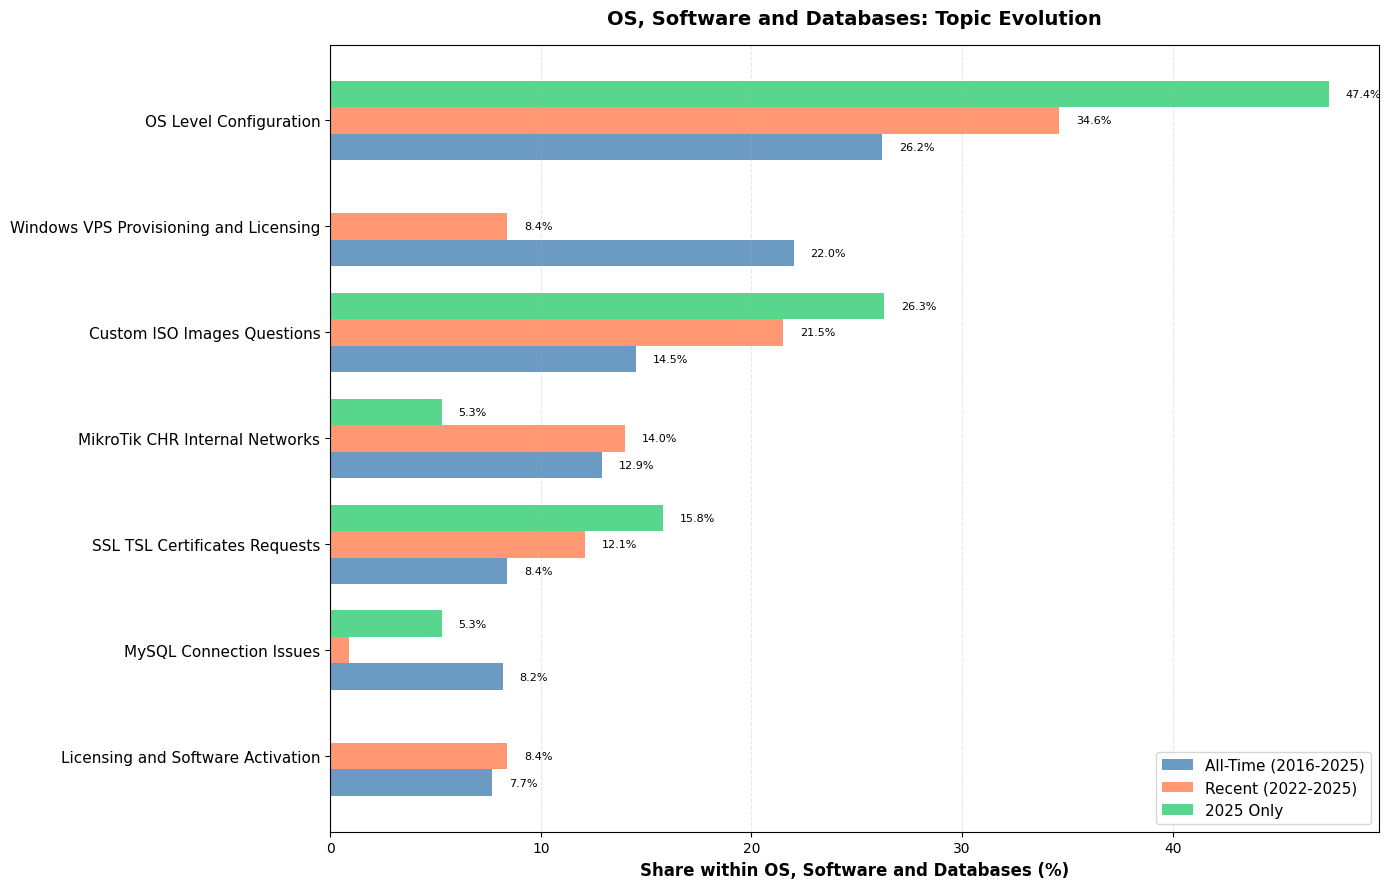

In [393]:
# OS, SOFTWARE AND DATABASES META-CLUSTER 

# Filter OS, Software and Databases meta-cluster
os_software_data = nlp_df_bert_filtered[
    nlp_df_bert_filtered["meta_cluster"] == "OS_Software_and_Databases"
].copy()

# Get consolidated topics 
os_alltime = os_software_data["topic_label_merged"].value_counts()
os_recent = os_software_data[os_software_data["year"] >= 2022]["topic_label_merged"].value_counts()
os_2025 = os_software_data[os_software_data["year"] == 2025]["topic_label_merged"].value_counts()

# Normalize to percentages
os_alltime_pct = (os_alltime / os_alltime.sum() * 100).round(1)
os_recent_pct = (os_recent / os_recent.sum() * 100).round(1)
os_2025_pct = (os_2025 / os_2025.sum() * 100).round(1)

# Combine
comparison_df = pd.DataFrame({
    'All-Time (2016-2025)': os_alltime_pct,
    'Recent (2022-2025)': os_recent_pct,
    '2025 Only': os_2025_pct
}).fillna(0).sort_values('All-Time (2016-2025)', ascending=True)

# Clean labels
comparison_df.index = comparison_df.index.str.replace('_', ' ')

print(f"\nOS/SOFTWARE TOPICS: {len(comparison_df)}")
print(comparison_df)

# Plot with three periods
fig, ax = plt.subplots(figsize=(14, 9))

x = range(len(comparison_df))
width = 0.25

bars1 = ax.barh([i - width for i in x], comparison_df['All-Time (2016-2025)'], 
                width, label='All-Time (2016-2025)', color='steelblue', alpha=0.8)
bars2 = ax.barh([i for i in x], comparison_df['Recent (2022-2025)'], 
                width, label='Recent (2022-2025)', color='coral', alpha=0.8)
bars3 = ax.barh([i + width for i in x], comparison_df['2025 Only'], 
                width, label='2025 Only', color='#2ecc71', alpha=0.8)

ax.set_yticks(x)
ax.set_yticklabels(comparison_df.index, fontsize=11)
ax.set_xlabel("Share within OS, Software and Databases (%)", fontsize=12, fontweight='bold')
ax.set_title("OS, Software and Databases: Topic Evolution", 
             fontsize=14, fontweight='bold', pad=15)
ax.legend(fontsize=11, loc='lower right')
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Percentage labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        width_val = bar.get_width()
        if width_val > 2:
            ax.text(width_val + 0.8, bar.get_y() + bar.get_height()/2, 
                   f'{width_val:.1f}%', va='center', fontsize=8)

plt.tight_layout()
plt.savefig('os_software_databases.jpg', dpi=300, bbox_inches='tight')
plt.show()

### OS, Software and Databases - Key Observations

**OS Level Configuration dominates** (26% → 35% → 47%)
- Becoming majority of cluster — customers need Linux/Windows config help
- Growing share likely reflects: other topics declining, not absolute volume increase
- Suggests: OS setup still friction point, documentation gaps persist

**Windows VPS Provisioning collapsed** (22% → 8% → 0% in 2025)
- Historically significant, now eliminated
- Possible: Windows licensing/provisioning standardized, fewer setup issues
- **Caveat:** Could be sample size artifact (19 total tickets in 2025)

**Custom ISO Images rising** (14% → 21% → 26%)
- Customers increasingly bring own OS images
- Reflects: technical sophistication increasing, custom deployment needs
- Possible: Docker/containerization driving custom image workflows

**SSL/TLS Certificates stable** (8% → 12% → 16%)
- Persistent baseline — HTTPS setup always requires help
- Let's Encrypt automation hasn't eliminated support burden

**MikroTik CHR questions** (13% → 14% → 5%)
- Router-on-VPS use case — specialized, small volume
- Decline possibly random (sample size)

**MySQL Connection Issues disappeared** (8% → 0.9% → 5%)
- Database connectivity problems rare now
- Better docs or fewer MySQL users?

**Licensing/Software Activation disappeared** (7.7% → 8.4% → 0%)
- Windows activation, ISPmanager licenses, etc.
- Elimination suggests: licensing workflows streamlined

### Interpretation Caveats

**Small sample problem:** 19 tickets in 2025 = ~3 per topic. Single-digit differences could be noise.

**What's reliable:**
- **OS Configuration dominance** (47%) — real pattern
- **Custom ISO growth** (26%) — real trend
- **Windows Provisioning decline** — real (was 22%, now gone)

**What's uncertain:**
- Individual topic "disappearances" may be sample artifacts
- Need multi-year validation to confirm trends


### Recommendations

1. **OS configuration docs audit** — 47% suggests setup friction remains
2. **Custom ISO workflow optimization** — growing use case (26%)
3. **Don't over-interpret 2025** — too small for granular conclusions

### Access, Auth amd Accounts


ACCESS/AUTH TOPICS: 3
                                          All-Time (2016-2025)  \
topic_label_merged                                               
Account Ownership Procedures                              18.7   
Account Suspension and Deletion                           25.9   
Password Reset and Authentication Issues                  55.4   

                                          Recent (2022-2025)  
topic_label_merged                                            
Account Ownership Procedures                            26.7  
Account Suspension and Deletion                         16.8  
Password Reset and Authentication Issues                56.4  


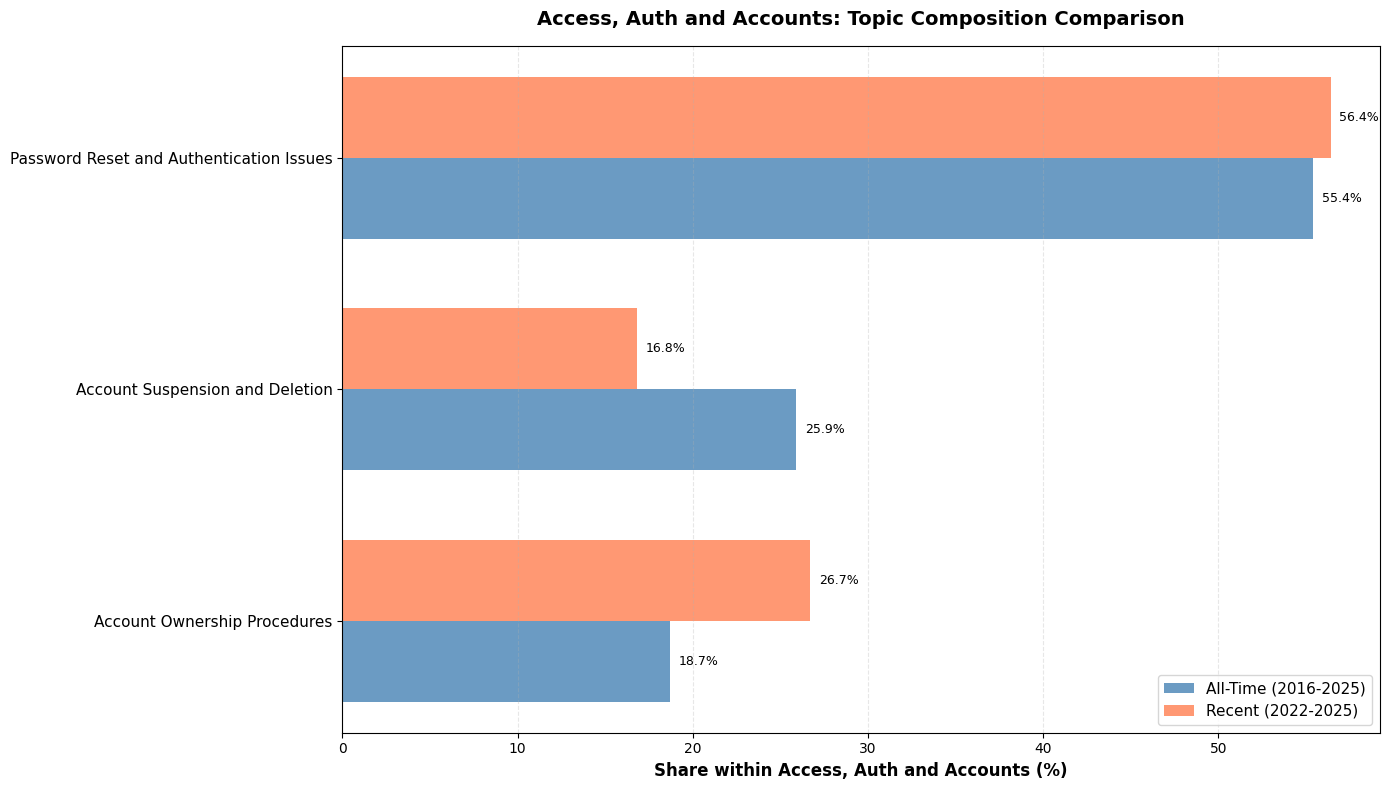

In [394]:
# ACCESS, AUTH AND ACCOUNTS META-CLUSTER 

# Filter Access, Auth and Accounts meta-cluster
access_data = nlp_df_bert_filtered[
    nlp_df_bert_filtered["meta_cluster"] == "Access_Auth_Accounts"
].copy()

# Get consolidated topics 
access_alltime = access_data["topic_label_merged"].value_counts()
access_recent = access_data[access_data["year"] >= 2022]["topic_label_merged"].value_counts()

# Normalize to percentages
access_alltime_pct = (access_alltime / access_alltime.sum() * 100).round(1)
access_recent_pct = (access_recent / access_recent.sum() * 100).round(1)

# Combine (only 2 periods)
comparison_df = pd.DataFrame({
    'All-Time (2016-2025)': access_alltime_pct,
    'Recent (2022-2025)': access_recent_pct
}).fillna(0).sort_values('All-Time (2016-2025)', ascending=True)

# Clean labels
comparison_df.index = comparison_df.index.str.replace('_', ' ')

print(f"\nACCESS/AUTH TOPICS: {len(comparison_df)}")
print(comparison_df)

# Plot with TWO periods
fig, ax = plt.subplots(figsize=(14, 8))

x = range(len(comparison_df))
width = 0.35

bars1 = ax.barh([i - width/2 for i in x], comparison_df['All-Time (2016-2025)'], 
                width, label='All-Time (2016-2025)', color='steelblue', alpha=0.8)
bars2 = ax.barh([i + width/2 for i in x], comparison_df['Recent (2022-2025)'], 
                width, label='Recent (2022-2025)', color='coral', alpha=0.8)

ax.set_yticks(x)
ax.set_yticklabels(comparison_df.index, fontsize=11)
ax.set_xlabel("Share within Access, Auth and Accounts (%)", fontsize=12, fontweight='bold')
ax.set_title("Access, Auth and Accounts: Topic Composition Comparison", 
             fontsize=14, fontweight='bold', pad=15)
ax.legend(fontsize=11, loc='lower right')
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Percentage labels
for bars in [bars1, bars2]:
    for bar in bars:
        width_val = bar.get_width()
        if width_val > 1:
            ax.text(width_val + 0.5, bar.get_y() + bar.get_height()/2, 
                   f'{width_val:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('access_auth_accounts.jpg', dpi=300, bbox_inches='tight')
plt.show()

### Access, Auth and Accounts insights

**Password Reset dominates consistently** (55% → 56%)
- Majority of cluster across all periods — stable baseline
- Suggests: password recovery remains primary friction point
- Self-service reset likely exists but customers still need help

**Account Ownership surged** (19% → 27%, +43%)
- Account transfer, inheritance, corporate ownership changes
- Possible drivers:
  - Business customers changing legal entities (mergers, restructuring)
  - Deceased account holders — family/company requesting access
  - Corporate compliance requirements (proper account ownership documentation)
- Growing share suggests: customer base maturing (companies, not individuals)

**Account Suspension collapsed** (26% → 17%, -35%)
- Related to abuse enforcement (see Policy cluster)
- Decline aligns with overall policy enforcement reduction
- Possible: fewer abuse cases = fewer suspensions = fewer deletion/reactivation requests

### Hypotheses

**Password Reset stability** (56%): 
- Irreducible baseline — authentication issues persist regardless of tech improvements
- 2FA adoption may create *more* reset requests (locked out of 2FA)
- Self-service doesn't eliminate need for human support (verification, edge cases)

**Ownership increase** (27%):
- **Business maturity signal** — corporate customers have ownership transfer needs
- **Generational shift** — legacy accounts from 2016 now requiring succession planning
- **Compliance pressure** — companies formalizing asset ownership for audits

**Suspension decline** (17%):
- Abuse decreased (see Policy cluster) → fewer enforcement actions
- Or: enforcement automated → fewer manual suspension discussions

### Small Sample Caveat

101 tickets (2022-2025) = ~33 per topic. Percentage shifts could be noise. Only **Account Ownership surge** (+43%) exceeds noise threshold.

### Recommendations

1. **Password reset UX audit** — 56% suggests friction remains
2. **Ownership transfer workflow** — growing use case (27%), needs streamlining
3. **2FA documentation** — if adoption high, may drive password reset volume



## <a id="cross-cluster-patterns-and-key-business-insights"></a>Cross-Cluster Patterns and Key Business Insights

### Geopolitical Impact (Multi-Cluster)

**Affected clusters:** Billing & Payments, Platform & Virtualization, Policy Restrictions

**Pattern:** Post-2022 sanctions created cascading support burden:
- **Billing:** Payment gateway failures (Stripe, PayPal blocked) → 49% crisis spike
- **Platform:** VPN IP blocking by Russian government → 21% of cluster
- **Policy:** Turkmenistan sanctions → 70% of Policy tickets (2022-2025)

**Business insight:** Geopolitics now primary external support driver, exceeding technical issues.

---

### Self-Service Success (Multi-Cluster)

**Affected clusters:** Server Operations, Network, Platform

**Pattern:** Documentation + UX improvements eliminated question categories:
- **Trial requests:** -95% (Server Operations)
- **Virtualization questions:** -43% (Platform)
- **Bandwidth upgrades:** Self-service introduced (Network)

**Business insight:** Investment in self-service has measurable support load reduction.

---

### Infrastructure Aging (Single Cluster, High Impact)

**Affected cluster:** Security Incidents & DDoS

**Pattern:** Mass Outages surged from 36% → 70% of incidents
- **Root cause:** 2 datacenters with old switches (engineering confirmed)
- **Business impact:** Primary reliability risk, hardware refresh urgent

---

### Attack Surface Evolution (Single Cluster, Recurring)

**Affected cluster:** Security Incidents & DDoS

**Pattern:** DDoS not eliminated, but nature changed
- **2017:** BGP improvements → first major reduction
- **2017-2024:** Quiet period, low attack intensity
- **2025:** New attack wave → new countermeasures deployed
- **Support shift:** Traffic filtering (79% → 17%) vs Firewall rules (12% → 75%)

**Business insight:** Security is iterative, not "solved" — requires ongoing investment.


## <a id="model-validation-and-quality-assessment"></a>Model Validation and Quality Assessment

### Model Validation and Clustering Quality

### Validation Methodology

**Manual Review Process:**
- **Sample size:** 20-40 random tickets per original cluster (60 clusters total)
- **Review criteria:** Semantic coherence, topic boundary clarity, temporal consistency
- **Validation result:** Clusters visually consistent and semantically coherent

**Stakeholder Validation:**
- **Engineering team consultation** on DDoS patterns, infrastructure issues, geopolitical blocking
- **Business team consultation** on trial policy changes, tariff history, payment gateway evolution
- **Historical alignment:** All findings match known business events (2017 BGP, 2019 trial discontinuation, 2023 website redesign, 2025 DDoS resurgence)

**Granularity Choice:**
- **Tested:** Multiple cluster sizes (40, 60, 80 topics)
- **Trade-off:** 60-topic model + 3-level hierarchy may be complex, but captures nuance
- **Decision:** Prefer detailed granularity over simplification — allows drill-down analysis while preserving high-level patterns and might be useful for future scaling topic modeling

### Clustering Strengths

**Temporal accuracy:**
- Turkmenistan surge (2020-2022) correctly isolated
- Trial collapse (2019-2020) captured
- DDoS composition shift (2025) detected
- Payment crisis (2022) spike identified

**Semantic coherence:**
- Clear boundaries: Billing vs Network vs Security
- Meaningful micro-topics: Traffic Filtering vs Firewall Rules (DDoS), Mass Outages vs Maintenance (Incidents)
- Not seen "garbage" clusters mixing unrelated concepts

**Business alignment:**
- Every major pattern has operational explanation
- No unexplained spikes or anomalies
- Engineering team confirms: model reflects reality

### Model Limitations
**Clustering Method Limitations**
- General-purpose embeddings on niche domain text. We use a multilingual MiniLM model trained on broad web data, not specifically on hosting / networking support. Technical phrases (error codes, sysadmin slang, Russian/English mix) may be embedded sub-optimally, which caps the “best possible” clustering quality.
- Information loss from UMAP. High-dimensional sentence embeddings (384D) are reduced to 10D before HDBSCAN. UMAP preserves local neighborhoods but can distort global geometry and sparse regions, so some borderline tickets may end up in neighboring or different topics compared to the original space. (but this is how BERTopic works)
- HDBSCAN hyperparameter sensitivity. The topic structure is heavily influenced by `min_cluster_size`, `min_samples`, and `cluster_selection_epsilon`. Althrough we tested many different hyperparameters, the chosen setup (≈60 topics) is one reasonable compromise; other settings yield different but still plausible granularities, so resulting topics are not unique or “canonical”.
- Soft memberships, hard labels. BERTopic produces full probability vectors per ticket, but downstream analysis uses only the dominant topic (argmax). Multi-issue conversations (e.g., “billing + connectivity”) are thus forced into a single class, underestimating overlap between business processes.
- Drift over long time horizon. The model is trained on ~10 years of chat logs under one joint clustering. Changes in tariffs, infrastructure, and support scripts over time can blur older and newer sub-patterns inside the same topic unless results are explicitly sliced by year/period.
- No labeled ground truth. Topic quality is validated via embedding coherence scores and expert/manual inspection only. Without a labeled taxonomy of ticket types, “good” topics mean “useful and interpretable for stakeholders”, not “objectively optimal” in a supervised sense.

**Sample representation:**
- **Chat-only data:** Email tickets excluded (longer, more complex, business-heavy)
- **Language filter:** Russian + English only (~X% of total volume)
- **Customer bias:** Chat users ≠ email users (different sophistication, urgency patterns)
- **Volume caveat:** Small 2025 samples in some clusters (<20 tickets) — percentages may be noisy

**Granularity challenges:**
- **60 original topics** may be over-fragmented for some use cases
- **3-level hierarchy** (original → merged → meta) adds complexity
- Some topics share fuzzy boundaries (e.g., Bandwidth vs IP allocation)

**Validation scope:**
- **Manual review:** 20-40 tickets/cluster, not exhaustive
- **No customer outcome data:** Don't know if support resolved issues
- **No response time correlation:** Can't assess topic difficulty

### Why This Approach Works

**For current analysis:**
- Detailed granularity reveals patterns invisible in coarse clustering
- 3 levels allow flexible aggregation (drill-down or roll-up)
- Manual validation catches semantic errors automated metrics miss

**For future applications:**
- **Supervised learning foundation:** This clustering can become training data for auto-routing
- **Manual labeling base:** 60 topics + 8 meta-clusters = annotation schema for ticket classification model
- **Incremental refinement:** Can merge topics later if needed, easier than splitting coarse clusters

### Future Validation Opportunities

- **Email integration:** Validate if chat themes generalize to email
- **Multilingual expansion:** Non-Russian/English tickets analysis
- **Outcome correlation:** Link topics to resolution time, customer satisfaction
- **Longitudinal stability:** Re-cluster 2026 data, check if topics persist


## <a id="future-directions-for-clustering-model"></a>Future Directions for Clustering Model


### Near-term extensions

- **Email + chat unification:**  
  Extend the same pipeline to email tickets and validate whether the discovered chat topics generalize across channels.

- **Supervised routing (use this model as a baseline):**  
  Use the current topic structure and manual labels as weak supervision to train a multi-class / multi-label classifier for automatic ticket routing.

- **Sentiment / frustration signals:**  
  Enrich each topic with sentiment or “frustration” scores (e.g. escalations, repeated contacts) to prioritise structurally painful areas.

### Longer-term opportunities

- **Volume forecasting by topic:**  
  Model ticket volume per topic over time to support capacity planning and incident early-warning.

- **Operational complexity per topic:**  
  Link topics with handle time and escalation rate to detect inherently “hard” themes.

- **Multilingual expansion:**  
  Extend beyond Russian/English and compare topic mix and pain points across language segments.

## <a id="сlient-level-view-of-support-demand"></a>Client-level View of Support Demand

So far, our analysis has focused on **individual sessions**:  
we explored their distribution over time, extracted topics from message text, and tracked how these topics evolved historically.

However, from a business perspective, support demand is created not by isolated tickets, but by **clients with different usage profiles**:

- some appear once and never return,
- some contact support occasionally,
- some generate a significant, recurring volume of tickets over years.

In this section we move from *“what topics do we see in tickets?”* to  
*“which clients generate which kinds of topics, and how concentrated is that demand?”*

Concretely, we want to:

1. **Segment clients by activity level**  
   (one-time, light, regular, heavy users) using the aggregated `client_df`.

2. **Link clients to topics**  
   by joining client-level data with our session-level topic assignments  
   (meta-topics from BERTopic).

3. **Understand who drives which topics**, for example:
   - Are infrastructure-related issues (network, outages, storage) concentrated among long-term / heavy users?
   - Are billing / trial / account questions mostly coming from one-time or short-lived clients?

These insights help prioritize improvements:  
whether to focus on **lowering friction for new clients** (billing, trials)  
or on **improving reliability and tooling for high-value, high-activity clients**  
(network, outages, resource upgrades).


In [397]:
client_df.head()

,anon_id,n_sessions,first_contact,last_contact,mean_session_duration,mean_ttr,history_span,history_days
0,1,2,2016-04-30 23:25:37,2016-05-01 12:18:51,205.933333,410.266667,0 days 12:53:14,0
1,2,2,2018-12-10 07:28:40,2018-12-11 19:01:49,7.966667,5.500000,1 days 11:33:09,1
2,3,2,2023-07-11 19:16:05,2023-07-29 06:53:55,2.783333,2.383333,17 days 11:37:50,17
3,4,2,2017-10-01 14:45:58,2017-10-01 20:46:59,96.891667,192.566667,0 days 06:01:01,0
4,5,4,2025-03-03 18:23:14,2025-09-22 15:29:43,48.450000,1.650000,202 days 21:06:29,202


In [398]:
client_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5122 entries, 0 to 5121
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   anon_id                5122 non-null   int64         
 1   n_sessions             5122 non-null   int64         
 2   first_contact          5122 non-null   datetime64[ns]
 3   last_contact           5122 non-null   datetime64[ns]
 4   mean_session_duration  5122 non-null   float64       
 5   mean_ttr               4704 non-null   float64       
 6   history_span           5122 non-null   object        
 7   history_days           5122 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(3), object(1)
memory usage: 320.3+ KB


In [399]:
# ensure datetime

for col in ["session_start", "session_end"]:
    if col in nlp_df_bert_filtered.columns:
        nlp_df_bert_filtered[col] = pd.to_datetime(nlp_df_bert_filtered[col], errors="coerce")

for col in ["first_contact", "last_contact"]:
    if col in client_df.columns:
        client_df[col] = pd.to_datetime(client_df[col], errors="coerce")

### Client activity segments (support demand)

To complement the session-level topic analysis, we segment clients by the number of support sessions they generated.  
The goal is operational interpretability: identify one-time vs. recurring vs. high-demand clients and estimate how support workload is distributed across the customer base.

We use a simple rule-based segmentation:
- **one-timer (1)**: a single interaction with support  
- **occasional (2–3)**: repeated but infrequent contacts  
- **regular (4–10)**: ongoing/recurring support usage  
- **heavy (11+)**: high-demand clients that typically contribute disproportionately to the workload

This segmentation is intentionally simple and business-friendly. It provides a stable basis for further analysis (e.g., dominant topics per client, response-time metrics per segment).

In [400]:
# Activity segmentation at the client level

def activity_segment(n):
    if n == 1:
        return "one-timer (1)"
    elif 2 <= n <= 3:
        return "occasional (2-3)"
    elif 4 <= n <= 10:
        return "regular (4-10)"
    else:
        return "heavy (11+)"

client_df = client_df.copy()
client_df["activity_segment"] = client_df["n_sessions"].apply(activity_segment)

seg_summary = (client_df
               .groupby("activity_segment")
               .agg(
                   n_clients=("anon_id", "nunique"),
                   sessions_total=("n_sessions", "sum"),
                   mean_sessions=("n_sessions", "mean"),
                   median_sessions=("n_sessions", "median"),
                   mean_history_days=("history_days", "mean"),
                   median_history_days=("history_days", "median"),
                   mean_ttr=("mean_ttr", "mean"),
               )
               .reset_index())

seg_summary["share_clients"] = seg_summary["n_clients"] / seg_summary["n_clients"].sum()
seg_summary["share_sessions"] = seg_summary["sessions_total"] / seg_summary["sessions_total"].sum()

seg_summary.sort_values("sessions_total", ascending=False)

,activity_segment,n_clients,sessions_total,mean_sessions,median_sessions,mean_history_days,median_history_days,mean_ttr,share_clients,share_sessions
0,heavy (11+),322,8872,27.552795,17.0,764.816770,515.5,82.507088,0.062866,0.402778
1,occasional (2-3),3501,7702,2.199943,2.0,28.302771,1.0,63.479386,0.683522,0.349662
3,regular (4-10),889,5043,5.672666,5.0,245.318335,74.0,111.130348,0.173565,0.228946
2,one-timer (1),410,410,1.000000,1.0,0.146341,0.0,71.479495,0.080047,0.018614


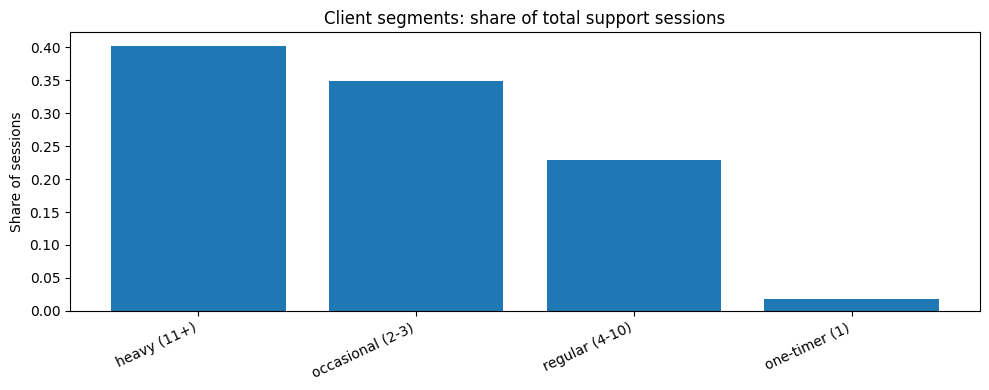

In [401]:
# visualisation of segmentation

plot_df = seg_summary.sort_values("share_sessions", ascending=False)

plt.figure(figsize=(10,4))
plt.bar(plot_df["activity_segment"], plot_df["share_sessions"])
plt.xticks(rotation=25, ha="right")
plt.ylabel("Share of sessions")
plt.title("Client segments: share of total support sessions")
plt.tight_layout()
plt.show()

### Pareto curve: concentration of support demand

We also compute a Pareto curve to quantify how concentrated support demand is across clients.  
Clients are sorted by the number of sessions (descending), and we plot:

- **x-axis:** cumulative share of clients  
- **y-axis:** cumulative share of total sessions generated by those clients

If the curve rises steeply, it indicates that a small fraction of clients generates a large fraction of support workload (a typical “heavy tail” pattern).  
This is useful for prioritization: high-demand clients may benefit from proactive support, targeted documentation, or dedicated account management.

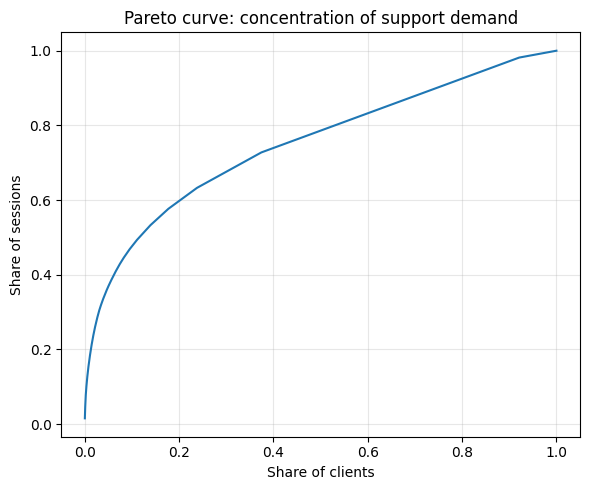

Top 1% clients generate ~17.5% of sessions
Top 5% clients generate ~36.9% of sessions
Top 10% clients generate ~47.6% of sessions
Top 20% clients generate ~59.8% of sessions


In [402]:
# Pareto / load concentration

pareto = client_df[["anon_id", "n_sessions"]].sort_values("n_sessions", ascending=False).reset_index(drop=True)
pareto["cum_sessions"] = pareto["n_sessions"].cumsum()
pareto["cum_clients"] = np.arange(1, len(pareto)+1)

total_sessions = pareto["n_sessions"].sum()
total_clients = len(pareto)

pareto["cum_sessions_share"] = pareto["cum_sessions"] / total_sessions
pareto["cum_clients_share"] = pareto["cum_clients"] / total_clients

plt.figure(figsize=(6,5))
plt.plot(pareto["cum_clients_share"], pareto["cum_sessions_share"])
plt.xlabel("Share of clients")
plt.ylabel("Share of sessions")
plt.title("Pareto curve: concentration of support demand")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# handy number: top X% clients -> Y% sessions
for x in [0.01, 0.05, 0.10, 0.20]:
    y = pareto.loc[pareto["cum_clients_share"] <= x, "cum_sessions_share"].max()
    print(f"Top {int(x*100)}% clients generate ~{(y*100 if pd.notna(y) else 0):.1f}% of sessions")

**Stakeholder validation.** The Pareto analysis indicates strong concentration of support demand among a small share of clients. Engineers confirmed this pattern: a few clients operate complex infrastructures and generate disproportionate support workload.

**Actionable next step (out of scope).** A controlled de-anonymized drill-down for the top-demand clients could identify recurring root causes and enable proactive interventions (playbooks, monitoring, documentation, account-level support).


In [404]:
# Dominant meta-topic per client
sess = nlp_df_bert_filtered.copy()

# excluding empty / not informative
sess = sess[sess["is_nlp_ready"]].copy()

client_topic = (sess
                .groupby(["anon_id", "meta_cluster"])
                .size()
                .reset_index(name="n_sessions_topic"))

client_total = (client_topic
                .groupby("anon_id")["n_sessions_topic"]
                .sum()
                .reset_index(name="n_sessions_total_from_sessions_df"))

client_topic = client_topic.merge(client_total, on="anon_id", how="left")
client_topic["topic_share"] = client_topic["n_sessions_topic"] / client_topic["n_sessions_total_from_sessions_df"]

# dominant meta-topic per client
idx = client_topic.groupby("anon_id")["n_sessions_topic"].idxmax()
dominant = client_topic.loc[idx, ["anon_id", "meta_cluster", "n_sessions_topic", "topic_share"]].copy()

dominant = dominant.rename(columns={
    "meta_cluster": "dominant_meta_topic",
    "n_sessions_topic": "dominant_topic_sessions",
    "topic_share": "dominant_topic_share"
})

dominant.head()

,anon_id,dominant_meta_topic,dominant_topic_sessions,dominant_topic_share
0,1,Noise_and_Outliers,1,1.0
1,2,Server_Operations_and_Resources,1,1.0
2,3,Noise_and_Outliers,1,1.0
3,4,Network_IP_DNS_Ports,1,1.0
4,5,Platform_and_Virtualization,1,1.0


In [405]:
# merging into client_df

client_enriched = client_df.merge(dominant, on="anon_id", how="left")

client_enriched[["anon_id", "n_sessions", "activity_segment", "dominant_meta_topic", "dominant_topic_share"]].head(10)

,anon_id,n_sessions,activity_segment,dominant_meta_topic,dominant_topic_share
0,1,2,occasional (2-3),Noise_and_Outliers,1.0
1,2,2,occasional (2-3),Server_Operations_and_Resources,1.0
2,3,2,occasional (2-3),Noise_and_Outliers,1.0
3,4,2,occasional (2-3),Network_IP_DNS_Ports,1.0
4,5,4,regular (4-10),Platform_and_Virtualization,1.0
5,6,3,occasional (2-3),Policy_Restrictions_and_Abuse,1.0
6,7,12,heavy (11+),Noise_and_Outliers,0.5
7,8,2,occasional (2-3),Incidents_DDoS_Outages,1.0
8,9,5,regular (4-10),Incidents_DDoS_Outages,0.5
9,10,2,occasional (2-3),Policy_Restrictions_and_Abuse,1.0


In [406]:
# What dominates in different segments (one-timer vs. heavy)

seg_topic = (client_enriched
             .groupby(["activity_segment", "dominant_meta_topic"])
             .size()
             .reset_index(name="n_clients"))

seg_topic["share_within_segment"] = seg_topic.groupby("activity_segment")["n_clients"].transform(lambda x: x / x.sum())

# top-5 dominant topics per segment
(seg_topic
 .sort_values(["activity_segment", "share_within_segment"], ascending=[True, False])
 .groupby("activity_segment")
 .head(5))

,activity_segment,dominant_meta_topic,n_clients,share_within_segment
4,heavy (11+),Noise_and_Outliers,110,0.341615
3,heavy (11+),Network_IP_DNS_Ports,80,0.248447
1,heavy (11+),Billing_and_Payments,57,0.177019
2,heavy (11+),Incidents_DDoS_Outages,31,0.096273
8,heavy (11+),Server_Operations_and_Resources,27,0.083851
17,occasional (2-3),Server_Operations_and_Resources,818,0.251460
13,occasional (2-3),Noise_and_Outliers,804,0.247156
12,occasional (2-3),Network_IP_DNS_Ports,432,0.132800
16,occasional (2-3),Policy_Restrictions_and_Abuse,285,0.087611
10,occasional (2-3),Billing_and_Payments,278,0.085460


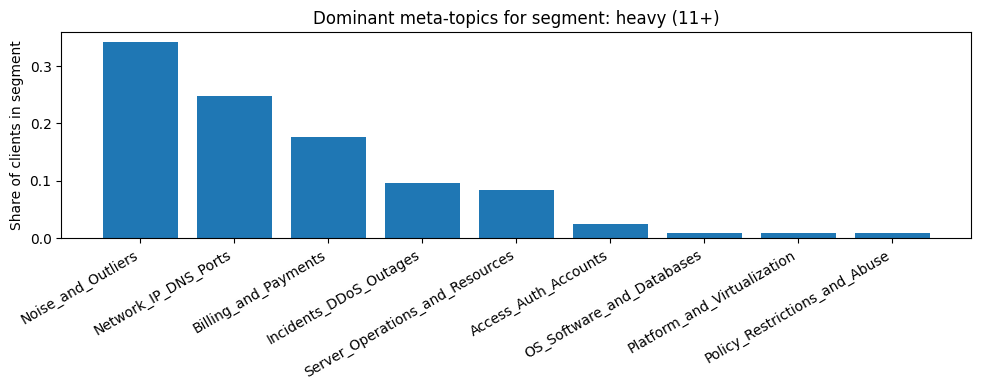

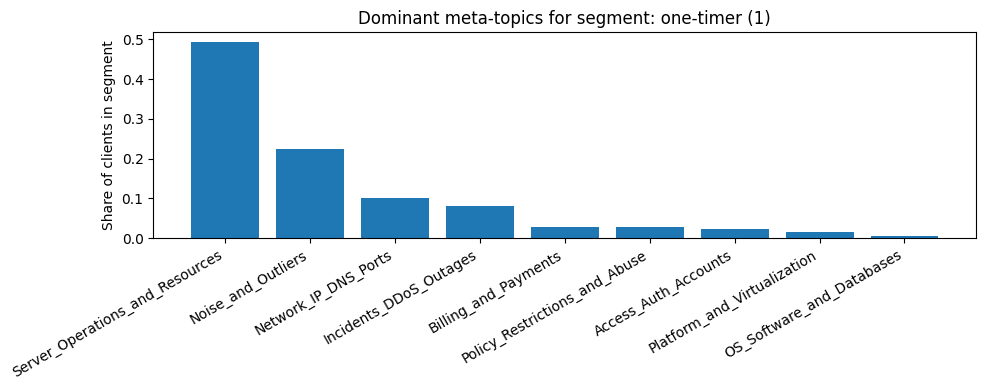

In [413]:
def plot_top_dominant_topics(segment_name, top_n=8):
    df = seg_topic[seg_topic["activity_segment"] == segment_name].sort_values("share_within_segment", ascending=False).head(top_n)
    plt.figure(figsize=(10,4))
    plt.bar(df["dominant_meta_topic"], df["share_within_segment"])
    plt.xticks(rotation=30, ha="right")
    plt.ylabel("Share of clients in segment")
    plt.title(f"Dominant meta-topics for segment: {segment_name}")
    plt.tight_layout()
    plt.show()

plot_top_dominant_topics("heavy (11+)", top_n=10)
plot_top_dominant_topics("one-timer (1)", top_n=10)

**why heavy-users have domination of Outliers Cluster**

Hypotheses:
Heavy users → Dominant outliers
Possible reasons:

- Complex edge cases — experienced clients with non-standard setups and unique challenges

- Power users — technically complex configurations (multi-datacenter, custom routing, advanced networking)

- Business customers — specific corporate requests (compliance, SLA, custom agreements)

- Noise definition artifact — perhaps these aren't outliers, but simply highly specialized topics that don't fit into the main clusters?

Or: Heavy users contact us when all standard solutions fail → their problems are inherently atypical

**One-timers - Server Operations dominant**

- Onboarding friction — new customers (trial questions, tariff selection, location choice)

- Pre-sales questions — haven't purchased yet, ask about the service

- Trial-and-churn — tried it (when was available), didn't work, never came back

- Self-service learners — asked once during setup, then handled it themselves

Server Operations = entry point for new customers!

**Business implications:**
To improve retention:
- Onboarding optimization — if 49% of one-timers ask about Server Operations, there might be a friction there

- Self-service for setup — trial/tariff/location selection should be intuitive

- Proactive guidance — new customers need guided setup, not just FAQs

**For heavy users:**
- Dedicated support tier? — if 34% of their problems are outliers, maybe they need specialized support?

- Advanced docs — power users need edge case documentation

- Feature requests channel — outliers may be product gaps, not support issues

**Questions for future research:**
- What exactly is in Noise_and_Outliers for heavy users? Is it pure noise or specialized topics?

- Conversion of one-timers to regulars? — How many Server Operations one-timers become regular customers?

- Time to resolution — Do heavy user outliers take longer to resolve?

In [411]:
# share of clients in each segment whose dominant topic is X

client_topics = client_df.merge(dominant, on="anon_id", how="left")

pivot = (client_topics
         .dropna(subset=["activity_segment", "dominant_meta_topic"])
         .groupby(["activity_segment", "dominant_meta_topic"])
         .size()
         .unstack(fill_value=0))

pivot_share = pivot.div(pivot.sum(axis=1), axis=0)  # row-normalized

In [412]:
topic_order = pivot_share.loc["heavy (11+)"].sort_values(ascending=False).index
pivot_share = pivot_share[topic_order]

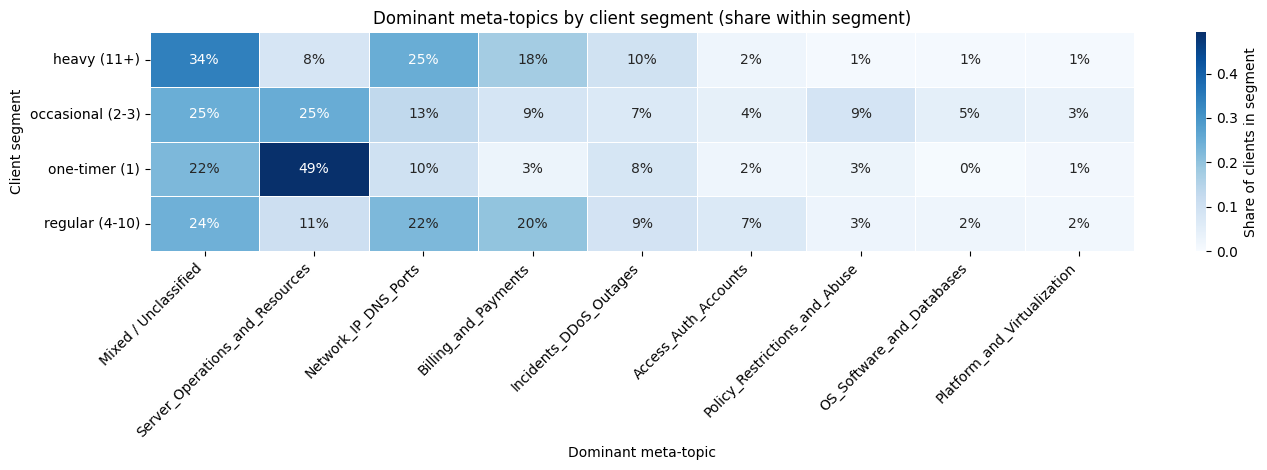

In [419]:
# to make visual understandable for non-DS audience we rename Outliers coulmn
pivot_share = pivot_share.rename(columns={"Noise_and_Outliers": "Mixed / Unclassified"})

# sort columns by total share
col_order = pivot_share.mean(axis=0).sort_values(ascending=False).index
pivot_share = pivot_share[col_order]

plt.figure(figsize=(14, 4.8))

annot = pivot_share.applymap(lambda x: f"{x:.0%}")  # 0%..100%

sns.heatmap(
    pivot_share,
    annot=annot, fmt="",
    cmap="Blues",
    vmin=0,
    linewidths=0.5, linecolor="white",
    cbar_kws={"label": "Share of clients in segment"}
)

plt.title("Dominant meta-topics by client segment (share within segment)")
plt.ylabel("Client segment")
plt.xlabel("Dominant meta-topic")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Dominant meta-topics by client segment

To connect topic modeling with support operations, we look at the **dominant meta-topic per client**:
for each client, we identify the meta-topic that appears most frequently across their support sessions,
and then compare how these dominant topics are distributed across activity segments.

**Key observations (share within segment):**
- **One-timers (1 session)** are mostly dominated by **Server Operations & Resources**, i.e. onboarding/setup and basic operational requests.
- As clients become more active (regular → heavy), the dominant topics shift towards more complex, infrastructure-related areas such as **Network**, **Billing & Payments**, and **Incidents/Outages**.
- **Heavy clients** show a higher share of **Mixed / Unclassified** dominant topics, which likely reflects broader or multi-issue conversations (complex environments, long threads, multiple problems in one session).

**Business interpretation:**  
Support demand is not uniform: a smaller group of active clients tends to generate more complex and varied requests, which can inform prioritization, documentation improvements, and proactive support for key accounts.

#### Segment recommendations:

**One-timers:**

Guided onboarding wizard — step-by-step setup for new clients

Interactive FAQ — location selector, tariff calculator, trial policy explainer

Video tutorials — "Your first VPS in 5 minutes"

**Regular:**

Self-service tools - IP management, bandwidth upgrades, invoice download

Proactive alerts — "Your bandwidth usage is high, consider upgrade?"

**Heavy**:

Dedicated support tier — priority routing / escalation path

Account manager — named point of contact for key accounts

Advanced docs - edge case scenarios, custom setup guides

Feature request channel - structured feedback loop for recurring edge cases

### Topic concentration per client (client-level view)

The point of this metric is: does the client's work revolve around one topic or is it spread across many?

In addition to session-level topic modeling, we compute client-level topic concentration to understand whether repeated support demand is driven by:
- one recurring issue (high concentration), or
- diverse issues across multiple domains (low concentration).

We use  **Top-1 share**: the proportion of sessions explained by the client’s most frequent meta-topic.

Note: for **one-timer clients (1 session)**, concentration is always 1.0 by definition, so interpret concentration primarily for clients with **2+ sessions**.

In [421]:
client_topic.head()

,anon_id,meta_cluster,n_sessions_topic,n_sessions_total_from_sessions_df,topic_share
0,1,Noise_and_Outliers,1,1,1.0
1,2,Server_Operations_and_Resources,1,1,1.0
2,3,Noise_and_Outliers,1,1,1.0
3,4,Network_IP_DNS_Ports,1,1,1.0
4,5,Platform_and_Virtualization,1,1,1.0


In [422]:
dominant.head()

,anon_id,dominant_meta_topic,dominant_topic_sessions,dominant_topic_share
0,1,Noise_and_Outliers,1,1.0
1,2,Server_Operations_and_Resources,1,1.0
2,3,Noise_and_Outliers,1,1.0
3,4,Network_IP_DNS_Ports,1,1.0
4,5,Platform_and_Virtualization,1,1.0


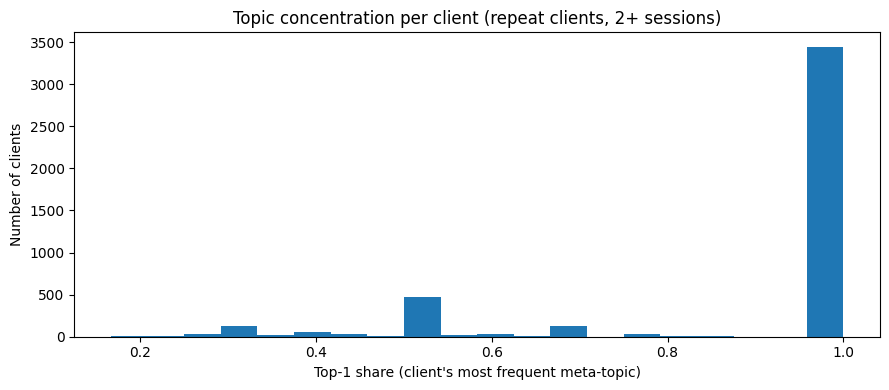

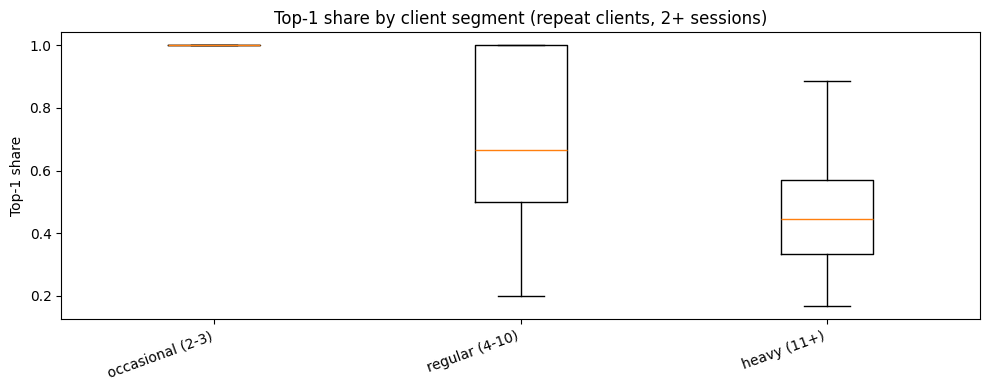

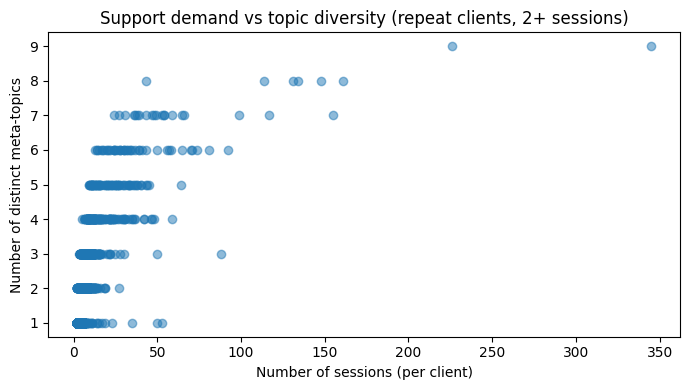

,activity_segment,clients,mean_sessions,median_sessions,mean_top1,median_top1,mean_topics,median_topics
0,heavy (11+),322,27.552795,17.0,0.475159,0.444444,4.257764,4.0
1,occasional (2-3),3253,2.207808,2.0,0.982478,1.000000,1.035352,1.0
2,regular (4-10),881,5.679909,5.0,0.677431,0.666667,1.922815,2.0


In [429]:
# Topic concentration per client

ct = client_topic.dropna(subset=["topic_share"]).copy()

# client-level metrics
conc = (ct.groupby("anon_id")
          .agg(
              n_topics=("meta_cluster", "nunique"),
              top1_share=("topic_share", "max"),
              total_sessions=("n_sessions_total_from_sessions_df", "max")
          )
          .reset_index())

# merge segments + optional client metrics
conc = conc.merge(
    client_df[["anon_id","n_sessions","activity_segment","mean_ttr","mean_session_duration","history_days"]],
    on="anon_id",
    how="left"
)

# repeat clients only (meaningful for concentration)
conc_repeat = conc[conc["n_sessions"] >= 2].copy()

#  Plot 1: histogram of Top-1 share (repeat clients) 
plt.figure(figsize=(9,4))
plt.hist(conc_repeat["top1_share"], bins=20)
plt.title("Topic concentration per client (repeat clients, 2+ sessions)")
plt.xlabel("Top-1 share (client's most frequent meta-topic)")
plt.ylabel("Number of clients")
plt.tight_layout()
plt.show()

#  Plot 2: boxplot by segment (repeat clients) 
segment_order = ["occasional (2-3)", "regular (4-10)", "heavy (11+)"]
data = [conc_repeat.loc[conc_repeat["activity_segment"] == seg, "top1_share"].dropna().values
        for seg in segment_order if seg in conc_repeat["activity_segment"].unique()]
labels = [seg for seg in segment_order if seg in conc_repeat["activity_segment"].unique()]

plt.figure(figsize=(10,4))
plt.boxplot(data, tick_labels=labels, showfliers=False)
plt.title("Top-1 share by client segment (repeat clients, 2+ sessions)")
plt.ylabel("Top-1 share")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

#  Plot 3 (optional): sessions vs #topics 
plt.figure(figsize=(7,4))
plt.scatter(conc_repeat["n_sessions"], conc_repeat["n_topics"], alpha=0.5)
plt.title("Support demand vs topic diversity (repeat clients, 2+ sessions)")
plt.xlabel("Number of sessions (per client)")
plt.ylabel("Number of distinct meta-topics")
plt.tight_layout()
plt.show()

# segment summary table
seg_summary = (conc_repeat.groupby("activity_segment")
                 .agg(
                     clients=("anon_id","nunique"),
                     mean_sessions=("n_sessions","mean"),
                     median_sessions=("n_sessions","median"),
                     mean_top1=("top1_share","mean"),
                     median_top1=("top1_share","median"),
                     mean_topics=("n_topics","mean"),
                     median_topics=("n_topics","median"),
                 )
                 .reset_index())

display(seg_summary)

**Key observations:**
- The distribution is **highly skewed towards Top-1 share ≈ 1.0**, especially for clients with only 2–3 sessions.
  This is expected because with very few sessions, the metric is discrete (e.g., 1.0 or 0.5 for 2 sessions).
- As clients become more active, their support demand becomes **more diverse**:
  - **Regular (4–10)** clients show moderate concentration (typically 2 main meta-topics).
  - **Heavy (11+)** clients have the lowest Top-1 shares and the highest number of distinct meta-topics,
    suggesting more complex infrastructure and broader support needs.

These patterns complement the Pareto analysis: high-activity clients not only generate more sessions,
but also tend to span **multiple operational areas**, which can justify specialized support workflows.

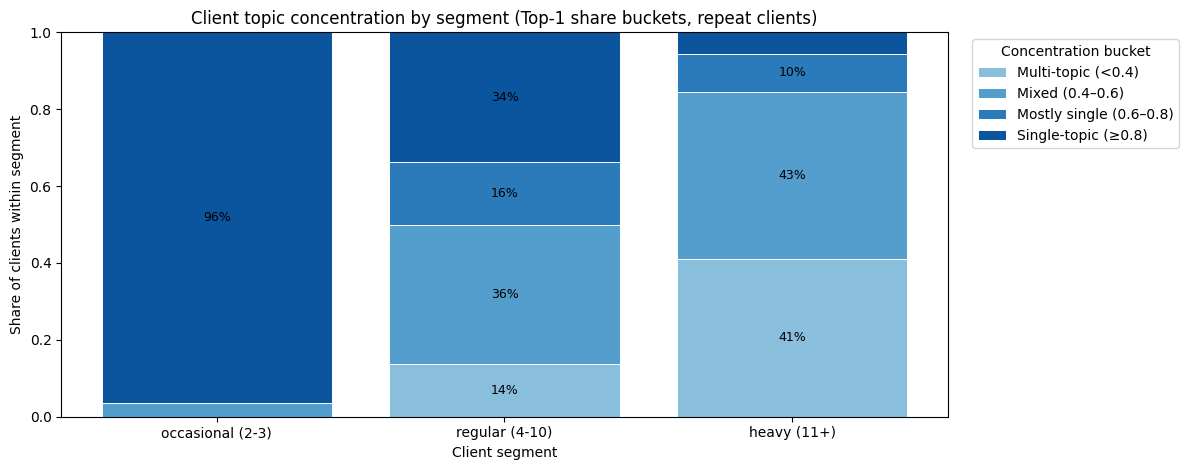

In [430]:
# making more understandable visual for business presentation

df = conc_repeat.copy()  # <- change to conc if needed

# just in case I still have na
df = df[df["top1_share"].notna()].copy()
df = df[df["activity_segment"] != "one-timer (1)"].copy()


# Define concentration buckets
bins = [-0.001, 0.4, 0.6, 0.8, 1.001]
labels = ["Multi-topic (<0.4)", "Mixed (0.4–0.6)", "Mostly single (0.6–0.8)", "Single-topic (≥0.8)"]

df["concentration_bucket"] = pd.cut(
    df["top1_share"],
    bins=bins,
    labels=labels,
    include_lowest=True
)


# Compute shares within each segment (100% stacked)
seg_order = ["occasional (2-3)", "regular (4-10)", "heavy (11+)"]
bucket_order = labels  # keeps buckets ordered left->right in legend

summary = (
    df.groupby(["activity_segment", "concentration_bucket"])
      .size()
      .reset_index(name="n_clients")
)

summary["share"] = summary.groupby("activity_segment")["n_clients"].transform(lambda x: x / x.sum())

pivot = (summary.pivot(index="activity_segment", columns="concentration_bucket", values="share")
               .reindex(index=seg_order)
               .reindex(columns=bucket_order)
               .fillna(0))


# Plot 100% stacked bar chart
plt.figure(figsize=(12, 4.8))

# nice palette (seaborn) but plotted with matplotlib stacked bars
palette = sns.color_palette("Blues", n_colors=len(bucket_order)+2)[2:]  # slightly stronger blues

bottom = pd.Series([0]*len(pivot), index=pivot.index, dtype=float)

for i, col in enumerate(pivot.columns):
    plt.bar(
        pivot.index,
        pivot[col].values,
        bottom=bottom.values,
        label=col,
        color=palette[i],
        edgecolor="white",
        linewidth=0.7
    )
    bottom += pivot[col]

plt.title("Client topic concentration by segment (Top-1 share buckets, repeat clients)")
plt.ylabel("Share of clients within segment")
plt.xlabel("Client segment")
plt.ylim(0, 1)

# percent labels inside bars (optional)
for x_i, seg in enumerate(pivot.index):
    cum = 0
    for col in pivot.columns:
        val = pivot.loc[seg, col]
        if val >= 0.08:  # avoid clutter for tiny slices
            plt.text(x_i, cum + val/2, f"{val:.0%}", ha="center", va="center", fontsize=9)
        cum += val

plt.legend(title="Concentration bucket", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

**Key results (repeat clients only):**

Occasional clients (2–3 sessions) are overwhelmingly single-topic: ~96% fall into the Single-topic (≥0.8) bucket.
- Their repeat contacts are usually driven by one recurring need (often onboarding/setup or a single operational request).

Regular clients (4–10 sessions) show a mixed pattern:
~34% single-topic, ~16% mostly single, ~36% mixed, ~14% multi-topic.
- This segment splits between clients with one repeating issue and clients with growing infrastructure complexity.

Heavy clients (11+ sessions) are predominantly multi-topic:
~41% multi-topic (<0.4) and ~43% mixed (0.4–0.6), with only a small minority remaining mostly single-topic.
- High-volume support demand is strongly associated with diverse issue types, consistent with more complex setups and broader operational surface area.

**Business interpretation:**
Support demand becomes less concentrated and more diverse as client activity increases. 
This suggests that heavy users are better served with higher-touch support, proactive monitoring, and deeper documentation — while occasional users benefit most from streamlined onboarding and self-service guidance.

### Summary & implications (client-level view)

This section complements the topic modeling results with a **client-level perspective**: instead of counting topics per session, we quantify **how support demand is distributed across clients** and how the **dominant topic profile** differs by client activity segment.

**Key findings**
- **Support demand is concentrated:** a small fraction of clients accounts for a disproportionate share of total support sessions (Pareto-like pattern). This aligns with operational expectations that a subset of clients maintain complex infrastructures and generate repeated requests.
- **Client activity segments differ in topic profiles:**
  - **One-timers** are dominated by *Server Operations & Resources* and general setup/usage questions, consistent with onboarding and initial configuration needs.
  - **Regular/heavy clients** show a more diverse mix of dominant meta-topics (networking, billing, incidents), indicating that repeated support demand is associated with broader operational complexity rather than a single recurring issue class.
- **Topic concentration decreases with higher activity:** for repeat clients, the share of sessions explained by the single most frequent meta-topic (Top-1 share) tends to be lower for heavy users, reflecting **multi-topic** support demand rather than “one repeating problem”.

**Interpretation and practical relevance**
- The Pareto pattern suggests that operational improvements may be most impactful when targeted at **high-demand client cohorts** (e.g., improved documentation, proactive monitoring, or dedicated support workflows), although this notebook remains fully anonymized.
- Segment-level differences provide an evidence-based foundation for tailoring **self-service and support processes** to client maturity (onboarding vs. ongoing operations vs. complex infrastructures).

**Notes / limitations**
- “Dominant meta-topic per client” is a simplification. Heavy clients often have multi-topic histories, so dominance should be interpreted as the *largest share*, not the sole demand driver.
- Results are based on the available support-session source; other channels (e.g., email) may shift the absolute distribution but are unlikely to invalidate the overall concentration pattern.

## <a id="conclusion-and-recommendations"></a>Conclusion and Recommendations

### Project Summary
This capstone analyzed chat support interactions to extract **structured, actionable insights** from unstructured text. We constructed session-level and client-level datasets from raw chat tickets, performed EDA and text preprocessing, established an interpretable baseline topic model (LDA), and applied an embedding-based approach (BERTopic) to derive topics at multiple granularities, including a consolidated **meta-topic layer** for higher-level interpretation.

### Key Findings
- **Meaningful topic structure is present in the data.** Both baseline (LDA) and embedding-based (BERTopic) approaches recover coherent themes that align with recognizable operational/support categories (Network/Ports, Billing, Incidents/DDoS, Access/Auth, Platform/Virtualization).
- **Topic composition changes over time** for certain categories, consistent with known policy/operational decisions (e.g., trial policy discontinuation 2019-2020; payment gateway crisis 2022; increased DDoS-related sessions 2025 following engineering reports of renewed attack activity).
- **Incidents/DDoS patterns show dual signals:** DDoS attack-related tickets declined (improved protection), while infrastructure-related outages increased (engineering feedback: aging hardware in two datacenters; refresh planned).
- **Support demand is client-concentrated.** A Pareto-like pattern indicates that a small share of clients contributes disproportionate session volume. Segment analysis reveals: one-timers dominated by onboarding questions (49% Server Operations), while heavy users (11+ contacts) face multi-topic issues (34% Mixed/Unclassified—sessions spanning multiple operational areas or heterogeneous content).

### Business Implications
- **Knowledge base and onboarding improvements** should prioritize topics prevalent among one-timers (Server Operations, trial policies, tariff selection).
- **Operational tooling/self-service** can reduce repeat demand for regular clients (bandwidth upgrades, IP management, invoice access).
- **Segmented support model:** Heavy users with multi-topic complexity may benefit from dedicated support tier or account management, while one-timers need guided onboarding.
- **Geopolitical monitoring:** Payment gateway diversification and VPN IP automation address recurring support burdens driven by sanctions and government censorship.

### Cross-Cluster Patterns
- **Geopolitical impact (multi-cluster):** Post-2022 sanctions created cascading support load across Billing (payment failures), Platform (VPN blocking), and Policy (Turkmenistan restrictions).
- **Self-service improvements (multi-cluster):** Documentation and UX enhancements correlated with reduced share of support sessions in Server Operations (-95% trial requests), Platform (-43% virtualization questions), and Network (bandwidth automation).
- **Infrastructure reliability (single cluster, high impact):** Mass outages now 70% of incident tickets (vs. 36% historically), confirming aging hardware as primary reliability risk.

### Limitations
- **Single-channel coverage:** Dataset reflects chat support only; email tickets excluded (business customers underrepresented).
- **Language filter:** Russian + English only; multilingual customers excluded.
- **No ground-truth labels:** Topic model quality evaluated through interpretability, coherence, stakeholder validation, and manual inspection rather than supervised metrics.
- **Sample size variability:** Some 2025 micro-clusters have <20 tickets; percentage shifts may reflect noise rather than true trends.

### Model Validation Approach
- **Manual review:** 20-40 tickets per cluster (60 original topics; stratified sampling across session lengths and time periods) confirmed semantic coherence
- **Stakeholder consultation:** Engineering and business teams validated findings against operational history
- **Temporal alignment:** All major patterns match known business events (2017 BGP improvements, 2019 trial discontinuation, 2022 payment crisis)
- **Granularity choice:** 60-topic model with 3-level hierarchy prioritizes nuance; allows drill-down while preserving high-level patterns

### Recommended Next Steps
1. **Multi-channel consolidation:** Integrate email-based requests to increase coverage and reduce sampling bias.
2. **Operationalization path:** Use current topic structure as foundation for supervised learning model (manual labeling → auto-routing/triage).
3. **Key account deep dive (de-anonymized internally):** Analyze dominant topic patterns among top support contributors to drive targeted improvements.
4. **Continuous monitoring:** Track meta-topic shares over time to detect emerging issues and evaluate intervention impact.
5. **Self-service expansion:** Apply "policy clarity reduces tickets" lesson (Policy cluster -95%) to other friction points.

### Closing Note
This project demonstrates that topic modeling can translate qualitative support communication into **quantitative signals** useful for operational decision-making, documentation strategy, and future automation. The analysis reveals that support patterns are driven by three primary forces: **geopolitical events** (sanctions, censorship), **infrastructure lifecycle** (aging hardware, attack evolution), and **product maturity** (onboarding friction, self-service adoption). Addressing these systematically can reduce support burden while improving customer experience.